- **Universidad:** Universidad Ramon Llull - La Salle
- **Master:** Master en Data Science
- **Curso:** MD001
- **Trabajo:** Trabajo de final de master (TFM)
- **Nombre:** Alvaro Javier Torres González.

**NOTA:** El notebook está seccionado por medio de un Indice. (ctrl + shift + k) para observar el indice en Jupyter Notebook. O seleccionar índice en barra lateral izquierda en google colab.

# RENDIMIENTO CORPORAL Y CAPACIDADES FÍSICAS DEL CUERPO HUMANO

## Descripción del dataset

- **age:** Edad en años (20 ~ 64)
- **gender:** Géneror (Fema - Male)
- **height_cm:** Altura (en centímetros)
- **weight_kg:** Peso (en kilogramos)
- **body fat_%:** Porcentaje de grasa corporala
- **diastolic:** Presión durante el descanso entre dos latidos (momento de presión mínima).
- **systolic:** Presión entre latidos cuando el corazón se está llenando de sangre (momento de presión máxima).
- **gripForce:** Fuerza de agarre en kilogramos - kilogram
- **sit and bend forward_cm:** Alcanse al encorvarse hacia adelante al estar sentado con las piernas estiradas (flexibilidad)
- **sit-ups counts:** Cantidad de abdominales en una sola ronda
- **broad jump_cm:** Salto largo partiendo del reposo
- **class:** Variable objetivo, tipo de cuerpo (atlética, saludable, sobre peso, obesidad)


---

## Librerías

---

In [1]:
# Instalación de paquetes necesarios
# !pip install pandas
# !pip install statsmodels
# !pip install scikit-optimize
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
import warnings
import random


from scipy import stats
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier,KernelDensity
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skopt import forest_minimize
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule

warnings.filterwarnings("ignore", message="The objective has been evaluated at point.*", category=UserWarning)

---

## 0- Carga y visualización de datos

---

In [2]:
data = pd.read_csv('bodyPerformance.csv', delimiter = ',')

# Guardar el tiempo de inicio
Inicio = time.time()

In [3]:
data.head(3)

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C

In [4]:
# Número de filas
print("Número de filas:", data.shape[0])

# Número de columnas
print("Número de columnas:", data.shape[1])

# Valores nulos
print("Valores nulos:", data.isna().any().any())   

Número de filas: 13393
Número de columnas: 12
Valores nulos: False


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB
None


In [6]:
# Cantidad de valores nulos
round(data.isnull().sum() / len(data) * 100,2)

age                        0.0
gender                     0.0
height_cm                  0.0
weight_kg                  0.0
body fat_%                 0.0
diastolic                  0.0
systolic                   0.0
gripForce                  0.0
sit and bend forward_cm    0.0
sit-ups counts             0.0
broad jump_cm              0.0
class                      0.0
dtype: float64

In [7]:
# Distribución de la variable target
data['class'].value_counts()

class
C    3349
D    3349
A    3348
B    3347
Name: count, dtype: int64

In [8]:
# Distribución entre hombres y mujeres
data['gender'].value_counts()

gender
M    8467
F    4926
Name: count, dtype: int64

In [9]:
data.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')

### Conclusiones

- Tenemos 13393 mediciones y 12 categorías incluyendo la variable objetivo
- No hay presencia de datos nulos
- Se observan 2 columnas categóricas: "gender" y "class" las cuales son género y la variable objetivo. El resto son variables numéricas.
- Tenemos una distribución de muestras de cuerpo balanceada, 25% de los datos pertenece al tipo de cuerpo A, 25% al tipo b, 25% al tipo C y 25% al tipo D.
- Hay más muestras de hombres que de mujeres, específicamente 8467 hombres y 4926 mujeres, equivalente a que el 63% del total de muestras son de hombres y 37% de mujeres.

---

## 1- Análisis inicial

---

In [10]:
# Definir una paleta de colores personalizada
colores = sns.color_palette(["#70AAFF","#CCB4FF"])  # Hombre - Mujer

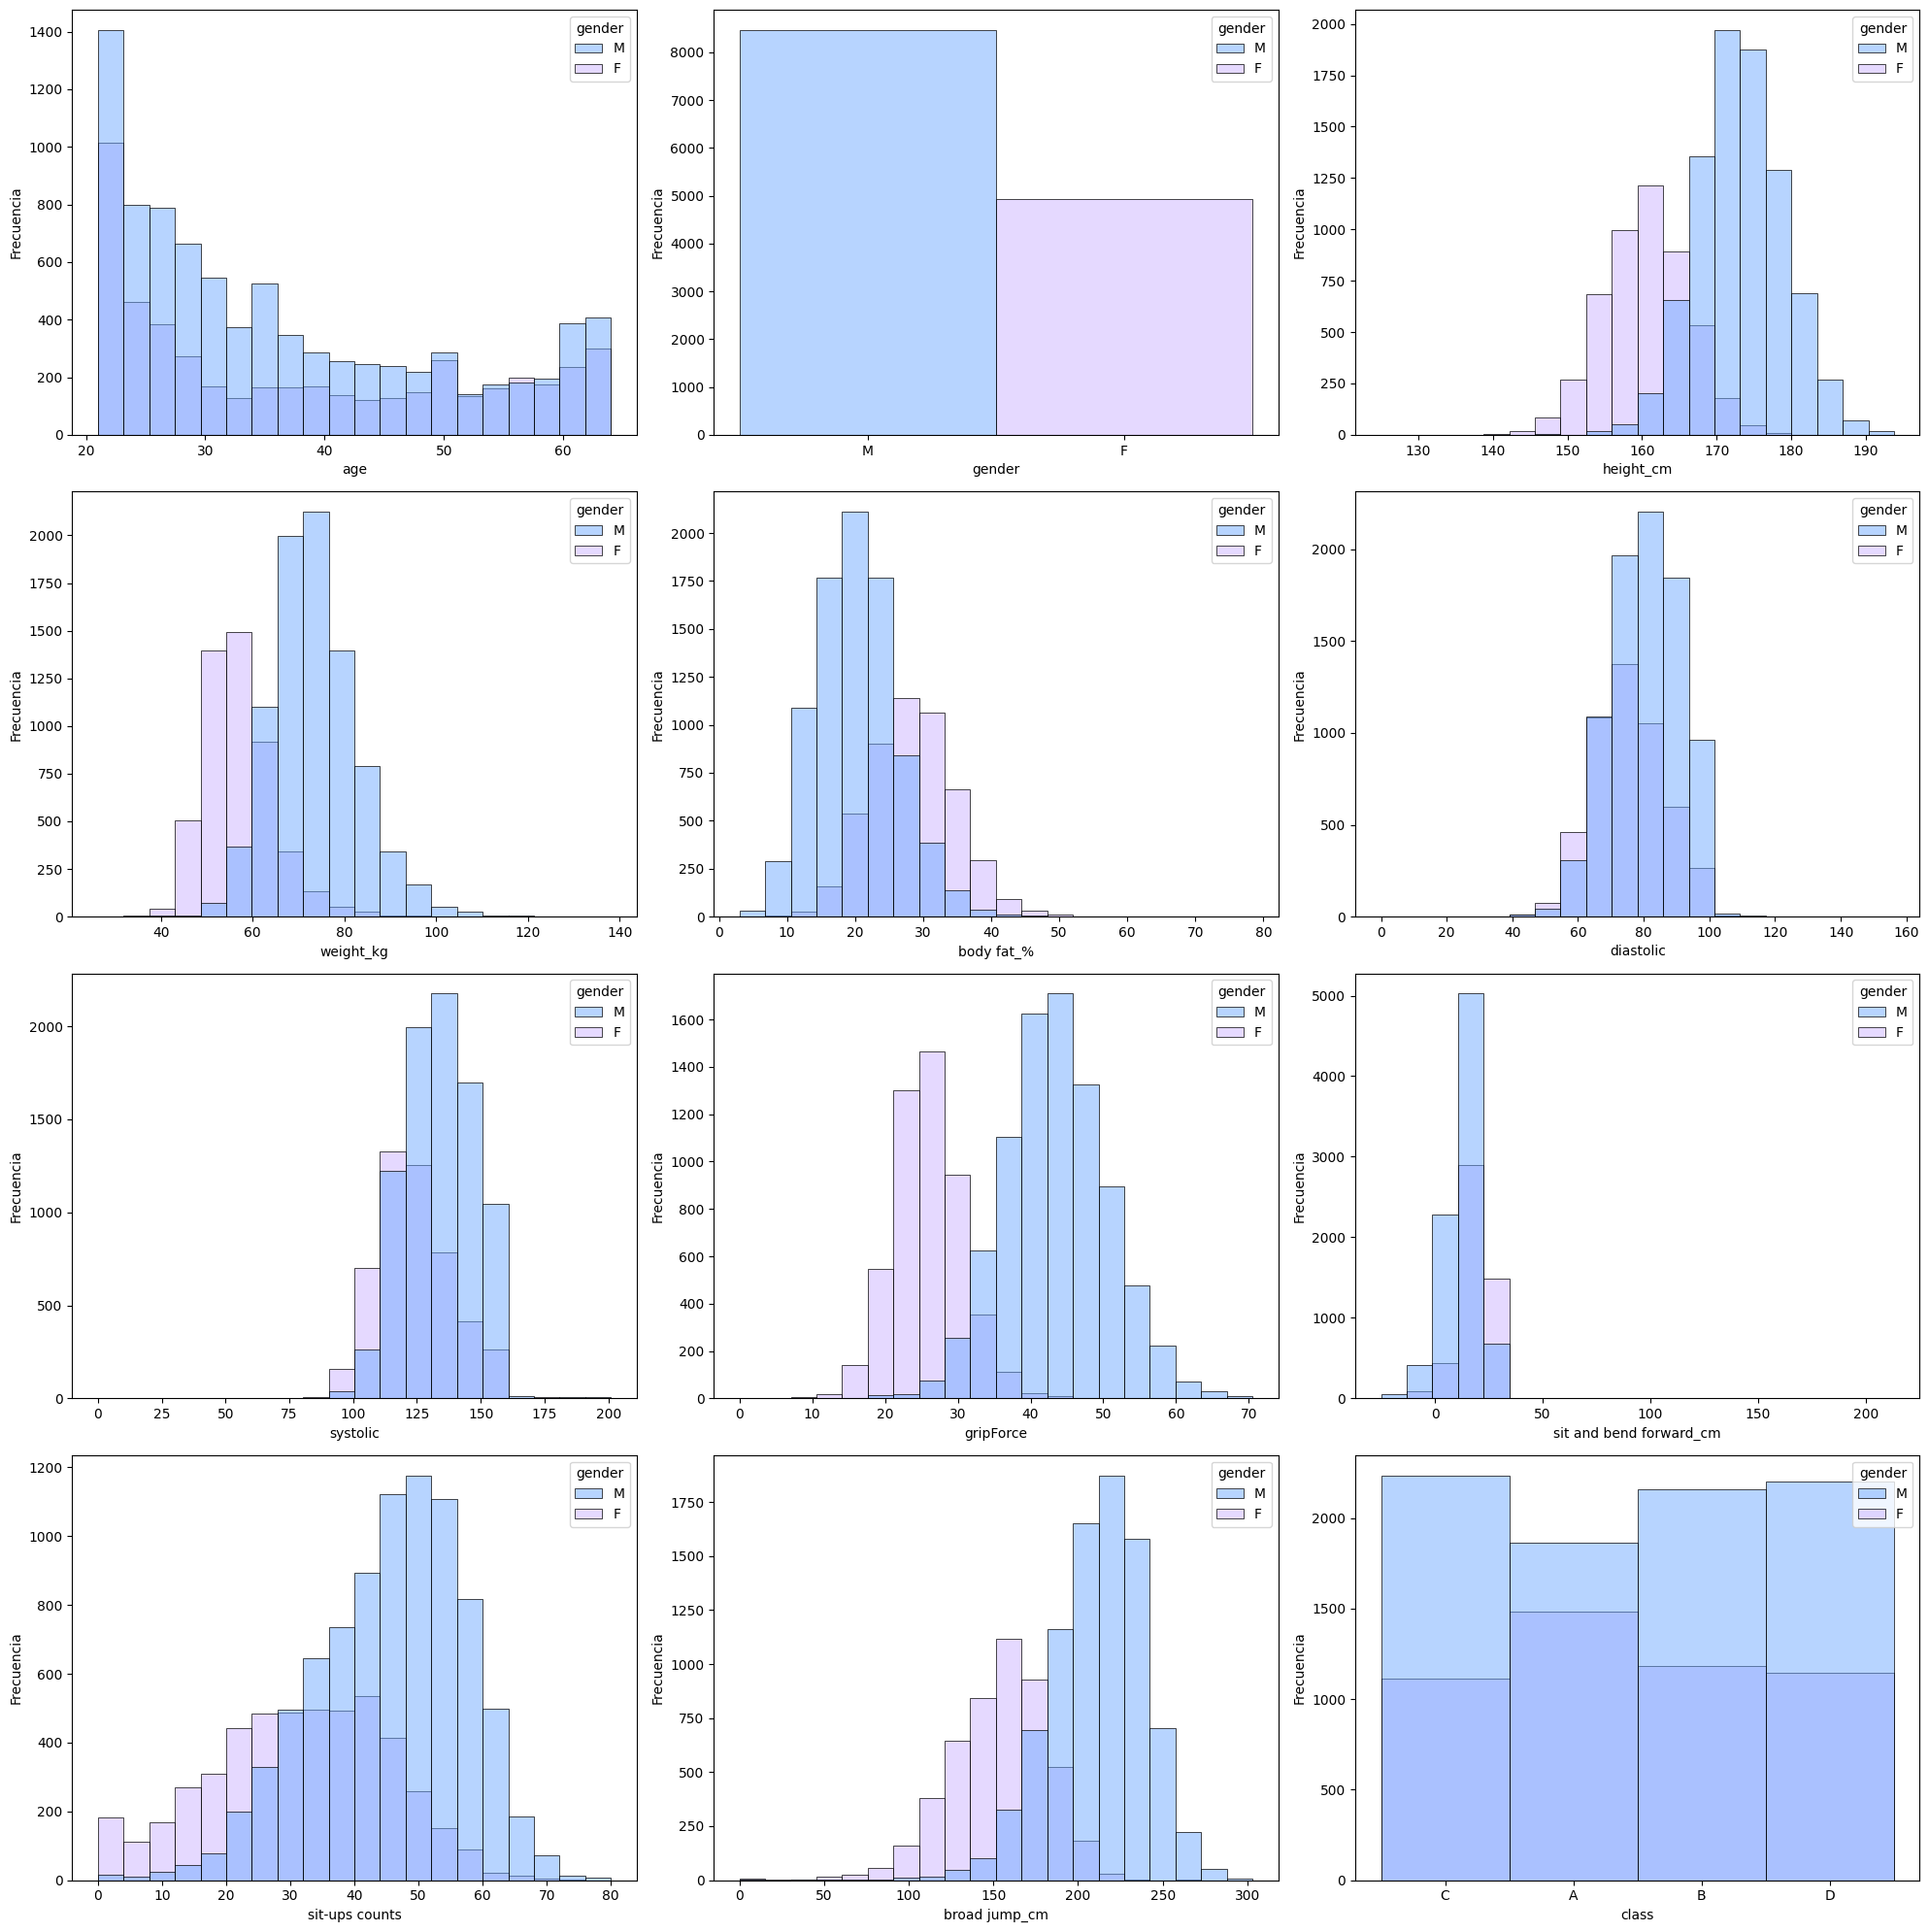

In [11]:
# Definir el tamaño de la figura
plt.figure(figsize=(20, 20))

# Iterar sobre las columnas y generar los histogramas
for i in range(len(data.columns)):
    x = data.columns[i]
    plt.subplot(4, 3, i+1)  # Subplot con 2 filas y 3 columnas, índice i+1
    sns.histplot(data=data, x=x, hue="gender", kde=False, legend=True, palette=colores, bins=20, linewidth=0.5)
    plt.xlabel(x)
    plt.ylabel("Frecuencia")

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

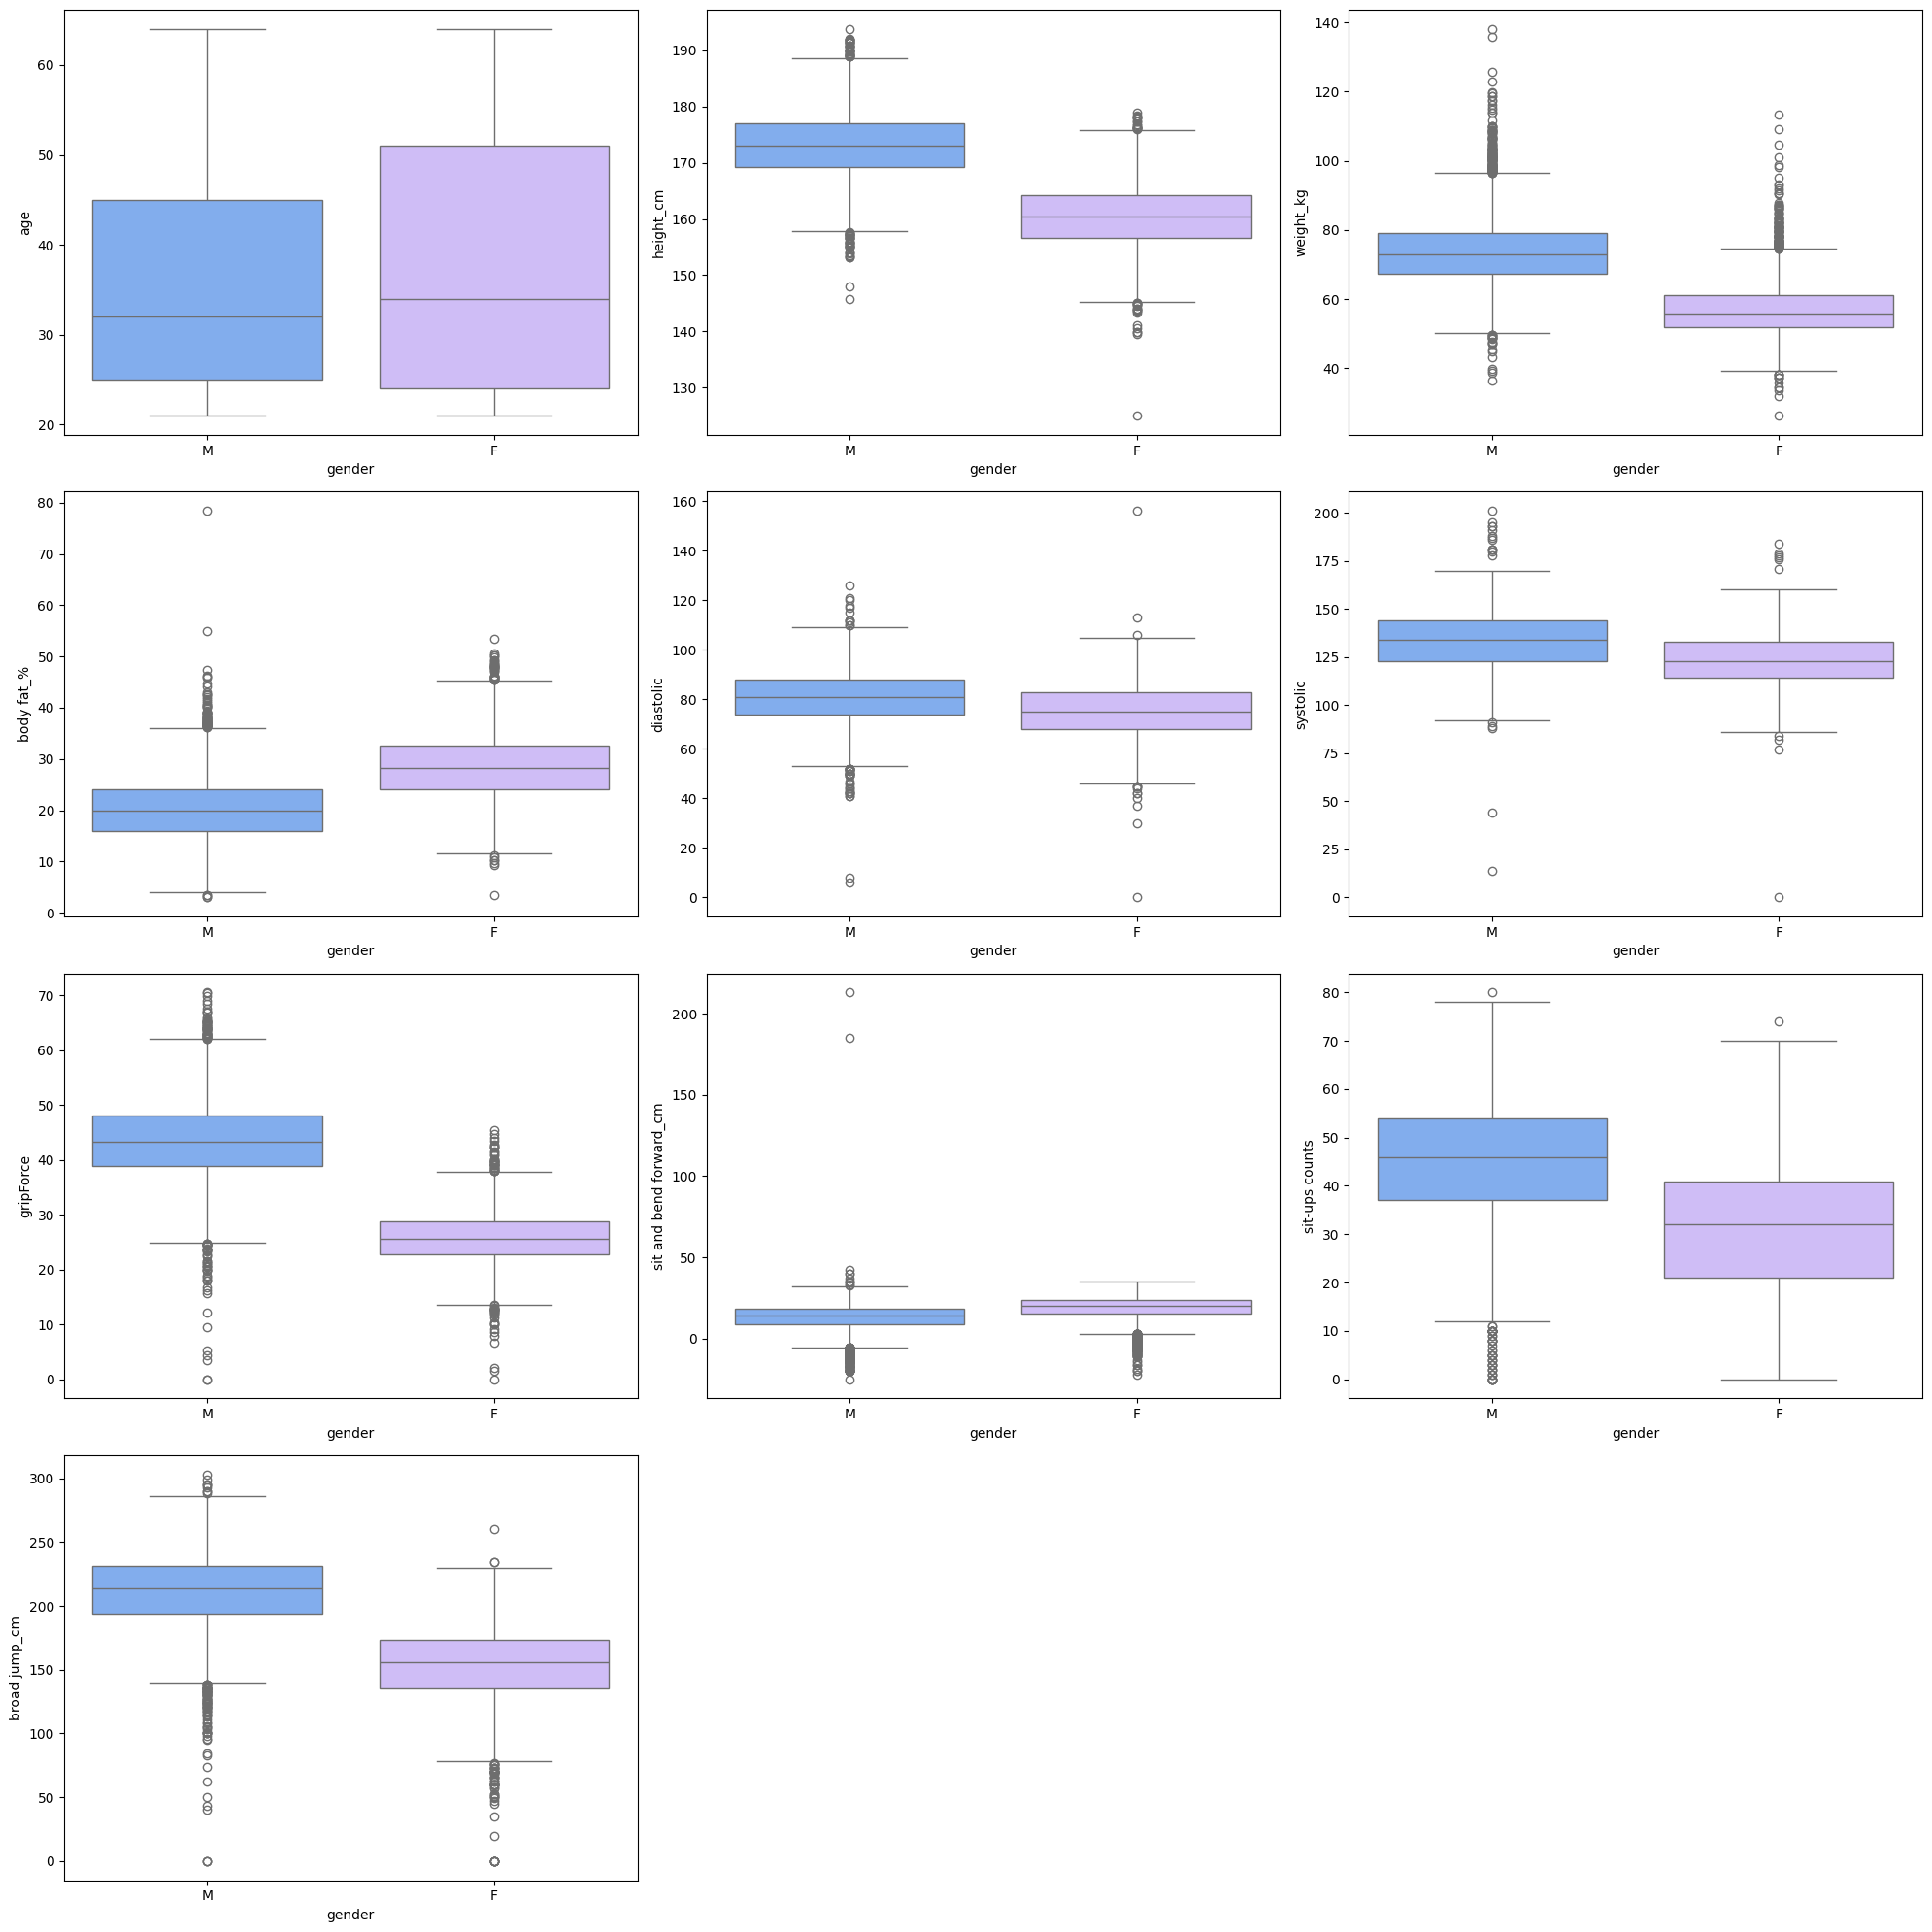

In [12]:
# Definir el tamaño de la figura
plt.figure(figsize=(20, 20))
pos = 1

# Iterar sobre las columnas y generar los boxplots
for i, x in enumerate(data.columns):
    if x != "gender" and x != "class":
        plt.subplot(4, 3, pos) 
        sns.boxplot(data=data, x="gender", y=x, hue="gender", palette=colores, dodge=False)
        plt.ylabel(x)
        pos = pos + 1

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

#### Prueba t de student

In [13]:
# DataFrame según el género
grupo_masculino = data[data['gender'] == 'M']
grupo_femenino = data[data['gender'] == 'F']

# Variables numéricas
variables_numericas = ['age', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm']

# Prueba T de Student 
for variable in variables_numericas:
    _, p_valor = stats.ttest_ind(grupo_masculino[variable], grupo_femenino[variable], equal_var=False, nan_policy='omit')
    print(f'Variable: {variable}, p-valor: {p_valor}')

Variable: age, p-valor: 1.0453884333235823e-11
Variable: height_cm, p-valor: 0.0
Variable: weight_kg, p-valor: 0.0
Variable: body fat_%, p-valor: 0.0
Variable: diastolic, p-valor: 9.575936549322122e-155
Variable: systolic, p-valor: 4.756866263895653e-308
Variable: gripForce, p-valor: 0.0
Variable: sit and bend forward_cm, p-valor: 0.0
Variable: sit-ups counts, p-valor: 0.0
Variable: broad jump_cm, p-valor: 0.0


### Observaciones

Existe una diferencia significativa en la cantidad de datos entre hombres (8,467) y mujeres (4,926), lo que podría llevar a una mayor tendencia de los modelos de clasificación a favorecer resultados similares a los datos de los hombres.

Es importante señalar que al evaluar aspectos físicos y mediciones de rendimiento, los resultados de las mujeres pueden diferir de los datos de los hombres. Por esta razón, se decidió separar las muestras por género y realizar un modelo para cada uno (hombres y mujeres), de modo que los datos se comparen dentro de sus respectivos grupos y no se vean influenciados por el peso o sesgo debidos a la disparidad en los datos. Además, se llevó a cabo la prueba de T de Student para verificar si existía una diferencia significativa en las mediciones según el género, confirmando la necesidad de tratar los datos por separado..


In [14]:
# Dataset con solo hombres
dataH = data[data["gender"] == "M"]

# Dataset con solo mujeres
dataM = data[data["gender"] == "F"]

---

## 2- Limpieza de datos

---

In [15]:
## FUNCIÓN QUE IMPRIME LAS MUESTRA LA DESCRIPCIÓN, HISTOGRAMA Y BOXPLOT
def informacion(data, columna, color):
    if color == 1:
        color_comun = "#CCB4FF"
        y = "F"
    elif color == 2:
        color_comun = "#70AAFF"
        y = "M"
    else:
        color_comun = "#FF5733"  # Un color predeterminado en caso de que el valor de color no sea ni 1 ni 2

    print(data.describe()[VAR])

    plt.figure(figsize=(10, 3))  # Ancho - Alto
    
    # Graficar histograma
    plt.subplot(1, 2, 1)   # Filas - Columnas - Posición
    sns.histplot(data=data, x=columna, kde=False, bins=20, linewidth=0.5, color=color_comun)
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
    plt.title("Histograma de {}".format(columna))
    
    # Graficar boxplot
    plt.subplot(1, 2, 2)   # Filas - Columnas - Posición
    sns.boxplot(data=data, y=columna, color=color_comun)
    plt.xlabel(y)
    plt.ylabel(columna)
    plt.title("Boxplot de {}".format(columna))

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()  
    
    # Ajustar el espacio entre los subgráficos
    plt.subplots_adjust(wspace=0.4)
    
    plt.show()

In [16]:
# def maxmin (data, columna, max, min):
#     # Mayor
#     print(f'Valores de {columna} mayores a {max}')
#     print(data[data[columna] > max])
    
#     # Menor
#     print(f'Valores de {columna} mayores a {min}')
#     print(data[data[columna] < min])

In [17]:
data.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')

### Data mujeres

#### Variable objetivo

In [18]:
# Distribución de la variable target
dataM['class'].value_counts()

class
A    1484
B    1185
D    1145
C    1112
Name: count, dtype: int64

In [19]:
# Número de filas
print("Número de filas:", dataM.shape[0])

# Número de columnas
print("Número de columnas:", dataM.shape[1])

# Valores nulos
print("Valores nulos:", dataM.isna().any().any())   

Número de filas: 4926
Número de columnas: 12
Valores nulos: False


In [20]:
dataM.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')

#### Edad

count    4926.000000
mean       37.850995
std        14.417859
min        21.000000
25%        24.000000
50%        34.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


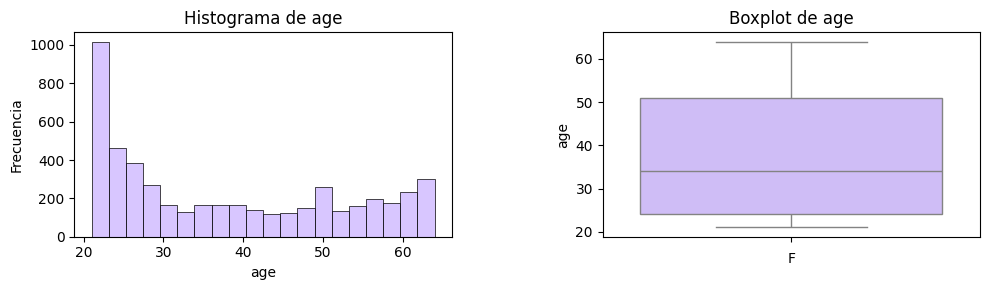

In [21]:
VAR = 'age'

# Función de información
informacion(dataM, VAR, 1)

In [22]:
dataM[dataM[VAR] > 50]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
11     57.0      F      153.0       49.0        20.9       69.0     106.0   
21     59.0      F      155.9       62.7        30.2       76.0     143.0   
57     58.0      F      146.5       46.4        32.9       71.0     127.0   
64     59.0      F      165.0       63.7        31.4       77.0     120.0   
68     56.0      F      160.2       62.4        33.3       67.0     103.0   
...     ...    ...        ...        ...         ...        ...       ...   
13355  55.0      F      164.1       70.1        38.2       68.0     125.0   
13366  53.0      F      155.1       60.0        31.2       78.0     125.0   
13384  64.0      F      152.4       55.9        33.1       87.0     158.0   
13386  62.0      F      156.2       40.0        20.2       61.0     115.0   
13391  64.0      F      146.1       57.7        40.4       68.0     121.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
11          21.5                     30.0             0.0           90.0     D  
21          36.8                     29.1            25.0          122.0     A  
57          18.7                     17.4            20.0          111.0     C  
64          20.8                     25.5            30.0          120.0     B  
68          28.8                     20.7            15.0          133.0     B  
...          ...                      ...             ...            ...   ...  
13355       24.7                     19.3            13.0          140.0     D  
13366       28.2                     17.6            19.0          139.0     B  
13384       23.5                     20.0            14.0          154.0     B  
13386       18.5                      5.7             1.0           81.0     D  
13391       19.3                      9.2             0.0           75.0     D  

[1289 rows x 12 columns]

#### Altura

count    4926.000000
mean      160.485404
std         5.648771
min       125.000000
25%       156.600000
50%       160.500000
75%       164.300000
max       179.000000
Name: height_cm, dtype: float64


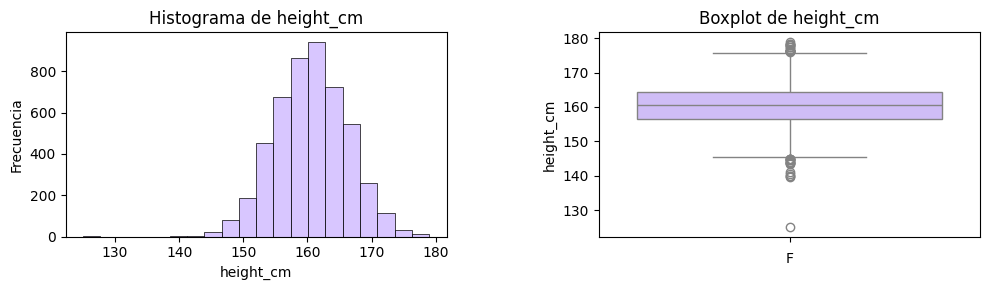

In [23]:
VAR = 'height_cm'

# Función de información
informacion(dataM, VAR, 1)

In [24]:
# Mayor y Minima
print("Altura máxima:",dataM[VAR].max())
print("Altura mínima:",dataM[VAR].min())

Altura máxima: 179.0
Altura mínima: 125.0


In [25]:
# Menores a
print("Mujeres menores a 147cm :",len(dataM[dataM[VAR] < 147]))
# dataM[dataM[VAR] < 147]

Mujeres menores a 147cm : 36


In [26]:
total_grupo = len(dataM)
valor_especifico = len(dataM[dataM[VAR] < 147])

porcentaje = (valor_especifico / total_grupo) * 100
print("Hay", valor_especifico, "mujeres menores de 147 cm, valor que equivale al", round(porcentaje,2), "% del total de los datos.")

Hay 36 mujeres menores de 147 cm, valor que equivale al 0.73 % del total de los datos.


In [27]:
dataM = dataM.drop(dataM[dataM[VAR] < 147].index)


**OBSERVACIONES**

En el conjunto de datos analizado, se identificó un grupo de 36 mujeres cuya estatura es inferior a 147 cm.

De acuerdo con datos del Centro Sequoia en México, especializado en el crecimiento pediátrico, la estatura promedio de las mujeres en Corea se sitúa en 162 cm. Se establece que una persona padece de acondroplasia, una enfermedad genética también conocida como enanismo, cuando su estatura adulta no supera los 147 cm.

Considerando que las mujeres cuya estatura es menor a 147 cm representan únicamente el 0.73% del total de datos analizados, se decidió excluir este subconjunto de 36 datos del dataset con el objetivo de obtener una muestra más representativa y generalizable.

https://centrosequoia.com.mx/estatura/promedio-corea-del-sur/#:~:text=La%20estatura%20promedio%20de%20los,de%20alrededor%20de%20162%20cm.
https://www.mayoclinic.org/es/diseases-conditions/dwarfism/symptoms-causes/syc-20371969#:~:text=Descripci%C3%B3n%20general,4%20pies%20(122%20cm).

#### Peso

count    4890.000000
mean       56.950683
std         7.627414
min        26.300000
25%        52.000000
50%        56.000000
75%        61.000000
max       113.300000
Name: weight_kg, dtype: float64


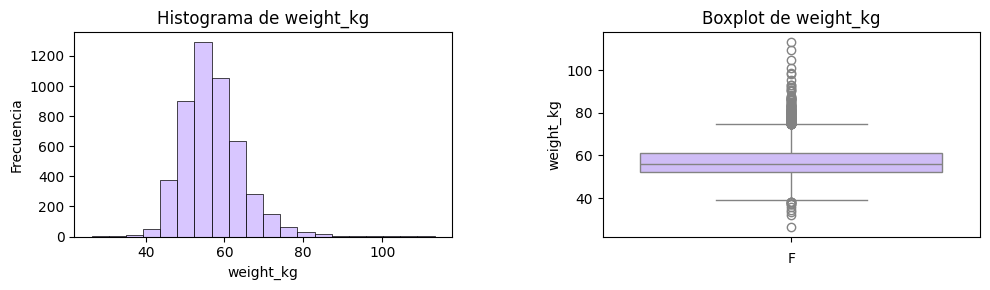

In [28]:
VAR = 'weight_kg'

# Función de información
informacion(dataM, VAR, 1)

In [29]:
# Mayor
dataM[dataM[VAR] > 90]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1400   30.0      F      162.5      113.3        53.5       82.0     135.0   
2630   37.0      F      165.1      104.7        48.3       86.0     148.0   
2958   22.0      F      168.1      101.1        44.6       96.0     148.0   
3642   60.0      F      160.6       90.3        48.9       81.0     156.0   
5014   23.0      F      170.0       98.1        41.0       86.0     137.0   
5423   42.0      F      158.0       93.1        47.3       85.0     135.0   
5533   40.0      F      155.0       91.9        48.6       93.0     158.0   
7350   58.0      F      168.6       92.9        45.0       91.0     134.0   
9178   48.0      F      160.0      109.2        50.6       94.0     141.0   
9375   33.0      F      165.3       91.6        42.7       63.0     103.0   
10203  34.0      F      160.0       90.7        50.2       70.0     122.0   
11068  55.0      F      171.8       95.1        39.6       81.0     136.0   
11233  21.0      F      166.1       98.7        43.0       73.0     125.0   
12884  40.0      F      148.2       90.6        48.3       65.0     119.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
1400        24.4                      3.0            12.0          100.0     D  
2630        28.1                     12.2            16.0          146.0     D  
2958        41.5                     14.2            28.0          171.0     D  
3642        29.2                     12.8             7.0          101.0     D  
5014        28.8                      5.7            12.0          153.0     D  
5423        35.8                     -2.8            17.0          145.0     D  
5533        21.3                      4.6             4.6          116.0     D  
7350        27.2                    -16.0             0.0           73.0     D  
9178        36.9                      8.2             0.0          159.0     D  
9375        28.1                      9.4            19.0          121.0     D  
10203       26.1                      5.8             7.0           98.0     D  
11068       32.3                      0.7             0.0          131.0     D  
11233       35.4                     19.7            39.0          180.0     D  
12884       22.0                      0.2             4.0          110.0     D

In [30]:
# Menor
dataM[dataM[VAR] < 39]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
216    37.0      F      149.5       38.1        17.3       66.0     110.0   
1081   37.0      F      148.7       38.1        22.8       83.0     123.0   
2216   24.0      F      154.2       37.3        23.0       66.0     116.0   
4370   63.0      F      153.9       26.3        37.0       73.0     120.0   
7550   21.0      F      163.7       31.9        31.9       64.0     110.0   
7944   45.0      F      153.4       33.7        16.1       81.0     124.0   
8131   26.0      F      151.8       38.1        23.3       82.0     125.0   
8422   61.0      F      151.7       37.4        38.5       75.0     138.0   
8622   21.0      F      155.2       37.4        12.7       60.0     101.0   
10295  26.0      F      164.8       34.5        34.5       85.0     137.0   
12023  57.0      F      148.1       35.9        14.3       60.0     109.0   
12207  62.0      F      152.4       38.1        11.6       72.0     132.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
216         16.2                     23.0            35.0          167.0     A  
1081        19.7                     19.6            31.0          165.0     C  
2216        16.1                     17.1            17.0          134.0     D  
4370        27.2                      7.8             0.0          105.0     D  
7550        27.7                     24.8            42.0          149.0     B  
7944         6.7                     11.5             8.0            0.0     D  
8131        21.9                     24.4            38.0          179.0     B  
8422        18.0                     15.0             1.0           70.0     D  
8622        18.8                     25.7            36.0          183.0     A  
10295        2.1                     31.0            38.0          175.0     A  
12023       21.7                     24.2            30.0          132.0     A  
12207       19.0                     21.7            21.0          121.0     A

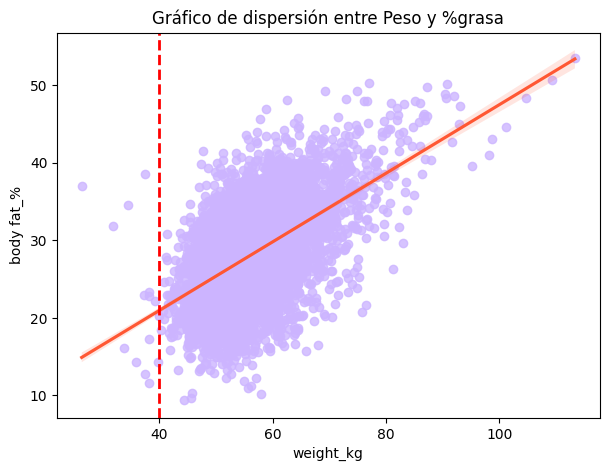

In [31]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))

sns.regplot(x=VAR, y='body fat_%', data=dataM, scatter_kws={"color": "#CCB4FF"}, line_kws={"color": "#FF5733"})
plt.axvline(x=40, color='red', linestyle='--', linewidth=2)  
plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('body fat_%')
plt.show()

Se procederá a crear una nueva variable llamada Índice de Masa Corporal (IMC) a partir de las variables peso y altura. El IMC es un indicador que relaciona el peso de una persona con su altura, permitiendo categorizar su estado ponderal en una de las siguientes cuatro categorías: Bajo peso, peso normal, sobrepeso y obesidad.

Posteriormente, se categorizará el IMC según las siguientes clasificaciones:

| IMC            | Estado                    |
|----------------|---------------------------|
| Por debajo de 18.5 | Bajo peso            |
| 18,5–24,9      | Peso normal              |
| 25.0–29.9      | Sobrepeso |
| 30.0–34.9      | Obesidad clase I          |
| 35,0–39,9      | Obesidad clase II         |
| Por encima de 40  | Obesidad clase III      |


Para fines de este estudio, se agruparán las tres clases de obesidad en una sola categoría denominada "obesidad".

**Formula para calcular el IMC**
$$
\text{IMC} = \frac{\text{peso (kg)}}{(\text{estatura (m)})^2}
$$

In [32]:
dataM["IMC"] = round(dataM["weight_kg"] / ((dataM["height_cm"] / 100) ** 2),2)

In [33]:
def cuerpo(y):
    if y < 18.5:
        return "Bajo Peso"
    elif y >= 18.5 and y < 25:
        return "Normal"
    elif y >= 25 and y < 29.9:
        return "Sobre Peso"
    else:
        return "Obesidad"

In [34]:
dataM["obesidad"] = dataM["IMC"].apply(cuerpo)

In [35]:
# Menor
dataM[dataM[VAR] < 35]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
4370   63.0      F      153.9       26.3        37.0       73.0     120.0   
7550   21.0      F      163.7       31.9        31.9       64.0     110.0   
7944   45.0      F      153.4       33.7        16.1       81.0     124.0   
10295  26.0      F      164.8       34.5        34.5       85.0     137.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
4370        27.2                      7.8             0.0          105.0   
7550        27.7                     24.8            42.0          149.0   
7944         6.7                     11.5             8.0            0.0   
10295        2.1                     31.0            38.0          175.0   

      class    IMC   obesidad  
4370      D  11.10  Bajo Peso  
7550      B  11.90  Bajo Peso  
7944      D  14.32  Bajo Peso  
10295     A  12.70  Bajo Peso

In [36]:
dataM = dataM.drop(dataM[dataM[VAR] < 35].index)

**OBSERVACIONES**

Se identificaron cuatro mediciones cuestionables relacionadas con pesos bajos, definidos como inferiores a 35 kg (equivalente a 77 lb), lo cual se considera bajo incluso para mujeres. Estas mediciones fueron excluidas del análisis por diversas razones:

1. **Medición con peso extremadamente bajo y alto porcentaje de grasa corporal:** Se encontró una medición que indicaba un peso de 26 kg con un porcentaje de grasa corporal del 37%. Este peso es anormal y poco saludable, por lo que se determinó que se trataba de un dato atípico que no contribuiría al modelo final.
   
2. **Mediciones con pesos iguales a los porcentajes de grasa corporal:** Dos mediciones presentaban pesos idénticos a los porcentajes de grasa corporal, lo cual es sospechoso y sugiere una posible toma de datos incorrecta. Por lo tanto, se decidió no incluirlas en el modelo debido a su peso extremadamente bajo, además de la inconsistencia entre el peso y el porcentaje de grasa.

3. **Medición con peso bajo y otras anomalías:** La última medición mostraba valores de peso considerados muy bajos, además de una altura inusualmente baja y un valor cuestionable en la prueba de salto largo (0 cm). Dada la combinación de un peso bajo, una altura incorrecta y una medición poco fiable en la prueba de salto largo, se determinó que esta muestra no sería incluida en el análisis.

#### Porcentaje de grasa

count    4886.000000
mean       28.450134
std         6.198503
min         9.400000
25%        24.100000
50%        28.300000
75%        32.600000
max        53.500000
Name: body fat_%, dtype: float64


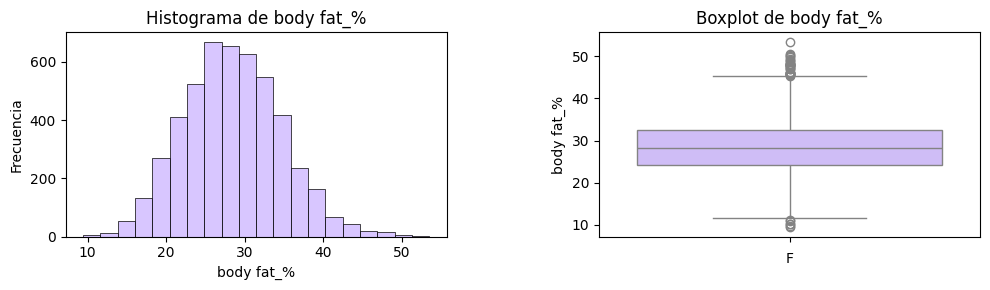

In [37]:
VAR = 'body fat_%'

# Función de información
informacion(dataM, VAR, 1)

In [38]:
# Mayor
dataM[dataM[VAR] > 45]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
582    58.0      F      155.6      82.00        47.1       97.0     157.0   
1400   30.0      F      162.5     113.30        53.5       82.0     135.0   
1593   45.0      F      160.9      80.90        47.7       80.0     128.0   
2059   51.0      F      156.4      76.80        45.1       90.0     158.0   
2211   56.0      F      159.9      80.72        46.1       88.0     152.0   
2630   37.0      F      165.1     104.70        48.3       86.0     148.0   
2795   59.0      F      157.5      81.90        45.5       64.0     122.0   
3087   25.0      F      158.7      83.10        47.5       86.0     122.0   
3488   35.0      F      153.3      86.00        47.7       96.0     146.0   
3642   60.0      F      160.6      90.30        48.9       81.0     156.0   
3791   64.0      F      151.6      71.60        45.9       87.0     158.0   
4082   52.0      F      161.8      69.30        49.3       66.0     123.0   
4838   25.0      F      151.8      58.80        46.9       89.0     147.0   
5391   21.0      F      162.1      73.00        48.2       85.0     146.0   
5423   42.0      F      158.0      93.10        47.3       85.0     135.0   
5533   40.0      F      155.0      91.90        48.6       93.0     158.0   
5622   51.0      F      147.0      64.40        45.7       73.0     126.0   
5904   40.0      F      160.4      86.50        46.0       79.0     133.0   
6163   24.0      F      159.0      79.70        45.4       77.0     121.0   
6474   57.0      F      167.2      87.30        49.8       73.0     126.0   
7379   50.0      F      155.7      87.30        46.0       89.0     128.0   
7539   59.0      F      154.3      76.10        48.0       66.0     118.0   
8599   60.0      F      160.0      76.90        50.3       82.0     141.0   
9178   48.0      F      160.0     109.20        50.6       94.0     141.0   
9323   27.0      F      157.8      76.70        47.9       83.0     132.0   
10000  42.0      F      152.2      86.60        46.3       78.0     138.0   
10203  34.0      F      160.0      90.70        50.2       70.0     122.0   
10299  28.0      F      165.9      86.90        45.5       89.0     130.0   
10430  59.0      F      151.2      63.70        45.1       53.0     129.0   
10440  64.0      F      157.7      74.80        49.2       79.0     149.0   
10608  57.0      F      148.4      62.50        48.1       66.0     109.0   
10649  21.0      F      163.8      85.10        47.9       94.0     149.0   
11487  41.0      F      157.8      82.10        46.1       66.0     110.0   
12116  64.0      F      150.6      57.80        45.6       92.0     153.0   
12884  40.0      F      148.2      90.60        48.3       65.0     119.0   
12930  39.0      F      163.2      85.80        45.3       70.0     116.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
582         22.1                      5.1            12.0           95.0   
1400        24.4                      3.0            12.0          100.0   
1593        28.4                     -4.5             2.0           86.0   
2059        20.3                     19.8             0.0          105.0   
2211        26.1                     24.5            18.0          138.0   
2630        28.1                     12.2            16.0          146.0   
2795        25.4                     21.6             0.0           65.0   
3087        21.7                      7.2             0.0          131.0   
3488        20.2                     19.5            17.0          155.0   
3642        29.2                     12.8             7.0          101.0   
3791        20.0                     13.6             0.0           57.0   
4082        23.9                      0.1            21.0          101.0   
4838        15.2                     13.0            16.0          105.0   
5391        26.2                     10.3            19.0          157.0   
5423        35.8  

In [39]:
# Menor
round(dataM[dataM[VAR] < 13],2)

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
2108   44.0      F      167.7      56.20       11.20       69.0     118.0   
2405   27.0      F      174.3      57.00       12.30       71.0     124.0   
4853   21.0      F      165.0      51.80       12.20       67.0     117.0   
6515   27.0      F      163.1      52.62       12.80       74.0     109.0   
7079   46.0      F      165.5      58.00       10.21       91.0     157.0   
8555   45.0      F      159.4      44.30        9.40       66.0     103.0   
8622   21.0      F      155.2      37.40       12.70       60.0     101.0   
9533   48.0      F      159.2      45.70       10.30       82.0     117.0   
10029  57.0      F      160.1      45.60        9.70       56.0     123.0   
12207  62.0      F      152.4      38.10       11.60       72.0     132.0   
12454  44.0      F      169.4      55.60       10.90       79.0     116.0   
13132  21.0      F      159.1      49.70       12.90       68.0     126.0   
13223  47.0      F      168.7      54.90       11.90       72.0     111.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
2108        35.1                     21.5            44.0          175.0   
2405        33.9                     30.1            68.0          201.0   
4853        29.7                     22.0            38.0          170.0   
6515        28.1                     24.1            53.0          216.0   
7079        29.1                     27.6            54.0          181.0   
8555        24.3                     34.3            38.0          154.0   
8622        18.8                     25.7            36.0          183.0   
9533        31.7                     34.3            30.0          160.0   
10029       26.6                     20.1            23.0          172.0   
12207       19.0                     21.7            21.0          121.0   
12454       29.7                     26.8            41.0          182.0   
13132       20.6                     24.9            35.0          180.0   
13223       32.3                     24.8            42.0          190.0   

      class    IMC   obesidad  
2108      A  19.98     Normal  
2405      A  18.76     Normal  
4853      C  19.03     Normal  
6515      A  19.78     Normal  
7079      A  21.18     Normal  
8555      A  17.44  Bajo Peso  
8622      A  15.53  Bajo Peso  
9533      A  18.03  Bajo Peso  
10029     A  17.79  Bajo Peso  
12207     A  16.40  Bajo Peso  
12454     A  19.38     Normal  
13132     B  19.63     Normal  
13223     A  19.29     Normal

**Observaciones**

No se han identificado datos sospechosos en cuanto al porcentaje de grasa en mujeres. Un porcentaje de grasa corporal superior al 39% se considera elevado y potencialmente riesgoso para la salud. Los datos analizados reflejan que las mujeres con estos porcentajes de grasa efectivamente presentan sobrepeso.

En cuanto al límite inferior, porcentajes de grasa corporal inferiores al 13% se consideran bajos, siendo el 10% el mínimo aceptable. Sin embargo, todas las mediciones de porcentaje de grasa bajos muestran métricas dentro de los rangos esperados para personas con esas características. Por lo tanto, se concluye que no hay datos atípicos en relación al porcentaje de grasa corpora

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://revista.nutricion.org/PDF/cardozo.pdf

#### Presión arterial 

count    4886.000000
mean      123.894392
std        14.477891
min         0.000000
25%       114.000000
50%       122.000000
75%       133.000000
max       184.000000
Name: systolic, dtype: float64


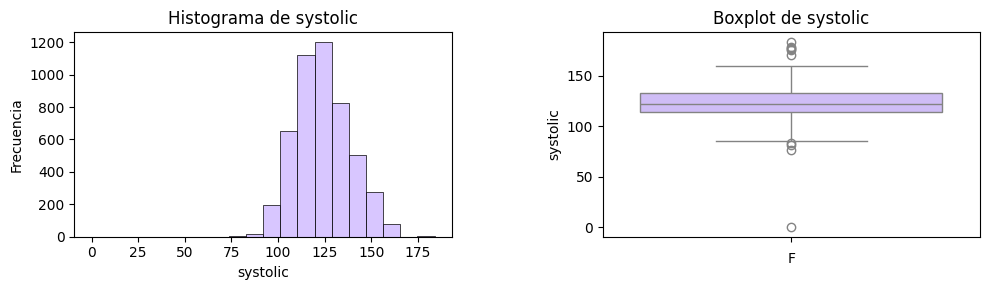

In [40]:
VAR = 'systolic'

# Función de información
informacion(dataM, VAR, 1)

count    4886.000000
mean       75.548342
std        10.633990
min         0.000000
25%        68.000000
50%        75.000000
75%        82.000000
max       156.200000
Name: diastolic, dtype: float64


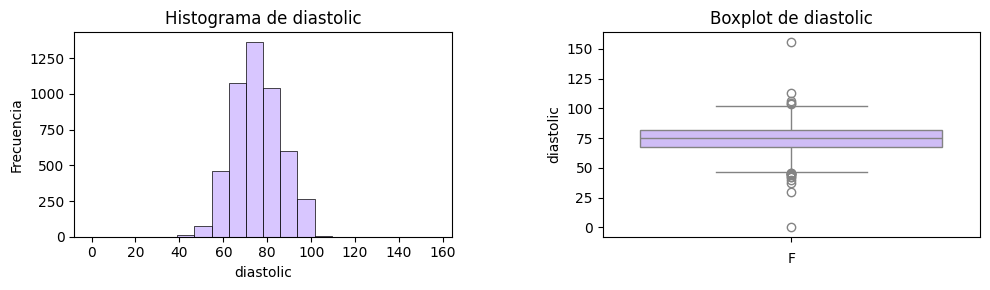

In [41]:
VAR = 'diastolic'

# Función de información
informacion(dataM, VAR, 1)

In [42]:
dataM.head()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
5   36.0      F      165.4       55.4        22.0       64.0     119.0   
6   42.0      F      164.5       63.7        32.2       72.0     135.0   
11  57.0      F      153.0       49.0        20.9       69.0     106.0   
12  27.0      F      156.0       53.9        35.5       69.0     116.0   
15  45.0      F      159.0       63.1        30.9       93.0     144.0   

    gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
5        23.8                     21.0            27.0          153.0     B   
6        22.7                      0.8            18.0          146.0     D   
11       21.5                     30.0             0.0           90.0     D   
12       23.1                     13.1            28.0          144.0     C   
15       34.1                     19.0            30.0          155.0     A   

      IMC obesidad  
5   20.25   Normal  
6   23.54   Normal  
11  20.93   Normal  
12  22.15   Normal  
15  24.96   Normal

En el análisis de la presión diastólica y sistólica, es crucial considerar una serie de casos particulares, dado que la categorización de las presiones como altas o bajas está determinada por rangos específicos:

**Presión arterial normal:**

- Presión sistólica: entre 90 y 120 mmHg
- Presión diastólica: entre 60 y 80 mmHg

**Presión arterial alta (hipertensión):**

- Presión sistólica: mayor a 140 mmHg
- Presión diastólica: mayor a 80 mmHg

**Presión arterial baja (hipotensión):**

- Presión sistólica: Menor a 90 mmHg
- Presión diastólica: Menor a 60 mmHg

Al analizar los valores de presión registrados en los datos, se observa una notable dispersión entre los rangos mencionados. En ocasiones, los valores se sitúan dentro del rango considerado como normal, mientras que en otras, la presión diastólica puede estar dentro del rango correcto pero la sistólica no, y viceversa. En consecuencia, se ha tomado la decisión de combinar estas dos variables en una nueva columna denominada "presión arterial", la cual indicará si el individuo presenta hipertensión, presión normal o hipotensión, según los criterios previamente establecidos.

https://www.nia.nih.gov/espanol/presion-arterial-alta/presion-arterial-alta-personas-mayores#:~:text=La%20presi%C3%B3n%20arterial%20normal%2C%20en,diast%C3%B3lica%20de%20menos%20de%2080.

In [43]:
def categorizar_presion(presion_sistolica, presion_diastolica):
    if presion_sistolica > 139 or presion_diastolica > 80:
        return "Hipertensión"
    elif 90 <= presion_sistolica <= 139 and 60 <= presion_diastolica <= 80:
        return "Normal"
    elif presion_sistolica < 90 or presion_diastolica < 60:
        return "Hipotensión"
    else:
        return "Indeterminado"

In [44]:
dataM['presion_arterial'] = dataM.apply(lambda row: categorizar_presion(row['systolic'], row['diastolic']), axis=1)

In [45]:
dataM.head()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
5   36.0      F      165.4       55.4        22.0       64.0     119.0   
6   42.0      F      164.5       63.7        32.2       72.0     135.0   
11  57.0      F      153.0       49.0        20.9       69.0     106.0   
12  27.0      F      156.0       53.9        35.5       69.0     116.0   
15  45.0      F      159.0       63.1        30.9       93.0     144.0   

    gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
5        23.8                     21.0            27.0          153.0     B   
6        22.7                      0.8            18.0          146.0     D   
11       21.5                     30.0             0.0           90.0     D   
12       23.1                     13.1            28.0          144.0     C   
15       34.1                     19.0            30.0          155.0     A   

      IMC obesidad presion_arterial  
5   20.25   Normal           Normal  
6   23.54   Normal           Normal  
11  20.93   Normal           Normal  
12  22.15   Normal           Normal  
15  24.96   Normal     Hipertensión

presion_arterial
Normal          2942
Hipertensión    1691
Hipotensión      253
Name: count, dtype: int64


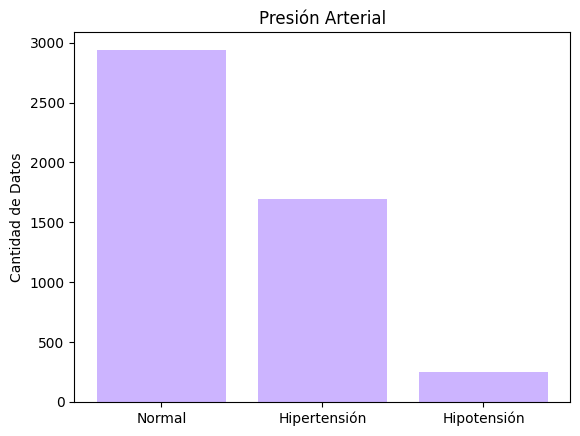

In [46]:
# Contamos la cantidad de datos diferentes en la columna 'presion_arterial'
conteo_datos = dataM['presion_arterial'].value_counts()

print(conteo_datos)

plt.bar(conteo_datos.index, conteo_datos.values, color="#CCB4FF")
plt.ylabel('Cantidad de Datos')
plt.title('Presión Arterial')
plt.show()

#### Fuerza de agarre

count    4886.000000
mean       25.862534
std         4.659817
min         0.000000
25%        22.700000
50%        25.700000
75%        28.800000
max        45.500000
Name: gripForce, dtype: float64


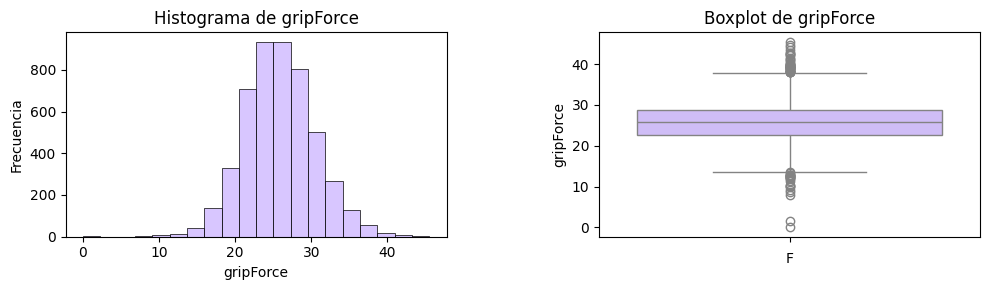

In [47]:
VAR = 'gripForce'

# Función de información
informacion(dataM, VAR, 1)

<Figure size 800x600 with 0 Axes>

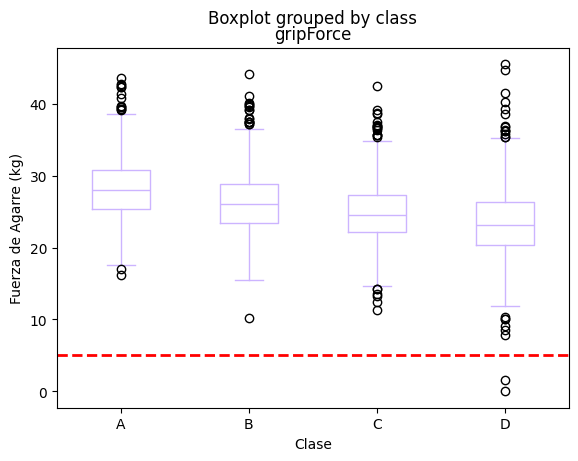

In [48]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataM.boxplot(column='gripForce', by='class', color = "#CCB4FF")
plt.axhline(y=5, color='red', linestyle='--', linewidth=2)  
plt.grid(False)
plt.xlabel('Clase')
plt.ylabel('Fuerza de Agarre (kg)')
# plt.title('Presión Arterial')
plt.show()

In [49]:
# Mayor
dataM[dataM[VAR] > 42]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
802    30.0      F      161.9       67.9        16.5       81.0     127.0   
3688   27.0      F      162.9       74.8        31.5       62.0     118.0   
4023   35.0      F      159.9       56.5        22.5       75.0     128.0   
4058   24.0      F      167.6       71.9        29.0       65.0     129.0   
5644   27.0      F      161.4       65.5        30.9       78.0     122.0   
6230   37.0      F      178.2       74.9        23.8       77.0     128.0   
8999   26.0      F      160.2       54.3        23.6       66.0     118.0   
11627  28.0      F      170.9       60.7        17.7       62.0     121.0   
11640  21.0      F      167.3       82.3        31.7       52.0     127.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
802         44.1                     25.1            39.0          222.0   
3688        42.3                     26.2            46.0          180.0   
4023        45.5                     24.1            26.0          159.0   
4058        42.6                     24.5            44.0          178.0   
5644        43.5                     27.4            60.0          227.0   
6230        44.7                     22.3            46.0          191.0   
8999        42.3                     22.9            53.0          190.0   
11627       42.5                     19.0            21.0          228.0   
11640       42.7                     21.9            41.0          172.0   

      class    IMC    obesidad presion_arterial  
802       B  25.90  Sobre Peso     Hipertensión  
3688      A  28.19  Sobre Peso           Normal  
4023      D  22.10      Normal           Normal  
4058      A  25.60  Sobre Peso           Normal  
5644      A  25.14  Sobre Peso           Normal  
6230      D  23.59      Normal           Normal  
8999      A  21.16      Normal           Normal  
11627     C  20.78      Normal           Normal  
11640     A  29.40  Sobre Peso      Hipotensión

In [50]:
# Menor
dataM[dataM[VAR] < 10]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1852   24.0      F      159.3      72.40        42.1       88.0     131.0   
5098   21.0      F      149.3      43.70        30.9       81.0     117.0   
6087   27.0      F      163.4      68.70        34.3       69.0     119.0   
8562   22.0      F      160.4      52.30        34.2       79.0     111.0   
11444  39.0      F      148.3      66.56        42.4       81.0     143.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
1852         1.6                     16.4            39.0          139.0   
5098         7.9                     13.0            23.0          125.0   
6087         8.6                     18.5            27.0          157.0   
8562         0.0                     15.2            45.0          165.0   
11444        9.1                     -9.3            18.0          152.0   

      class    IMC    obesidad presion_arterial  
1852      D  28.53  Sobre Peso     Hipertensión  
5098      D  19.60      Normal     Hipertensión  
6087      D  25.73  Sobre Peso           Normal  
8562      D  20.33      Normal           Normal  
11444     D  30.26    Obesidad     Hipertensión

In [51]:
dataM = dataM.drop(dataM[dataM[VAR] < 5].index)

**Observaciones**

No se han encontrado datos anómalos en las mediciones de la fuerza de agarre alta. Sin embargo, en las mediciones de baja fuerza de agarre, se han observado valores muy bajos, lo que genera dudas. Aunque no disponemos de suficiente información para concluir que estos datos sean incorrectos.

Es necesario destacar dos valores específicos: 1.6 kg y 0 kg. Estos valores son poco plausibles, ya que con una fuerza de agarre tan baja sería difícil llevar a cabo actividades cotidianas, como sostener un ordenador portátil o abrir la puerta de un automóvil. Por lo tanto, se ha decidido descartar estas dos muestra

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://mioapp.es/docs/ficha_dinamometria.pdfs.

#### Flexibilidad

count    4884.000000
mean       18.866771
std         7.137823
min       -22.000000
25%        15.300000
50%        20.000000
75%        23.500000
max        35.200000
Name: sit and bend forward_cm, dtype: float64


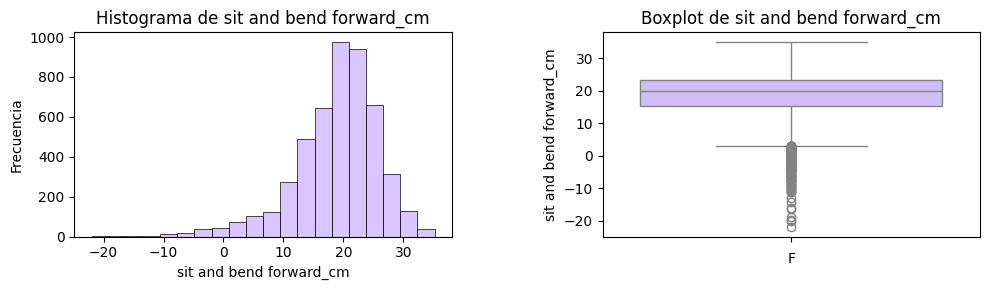

In [52]:
VAR = 'sit and bend forward_cm'

# Función de información
informacion(dataM, VAR, 1)

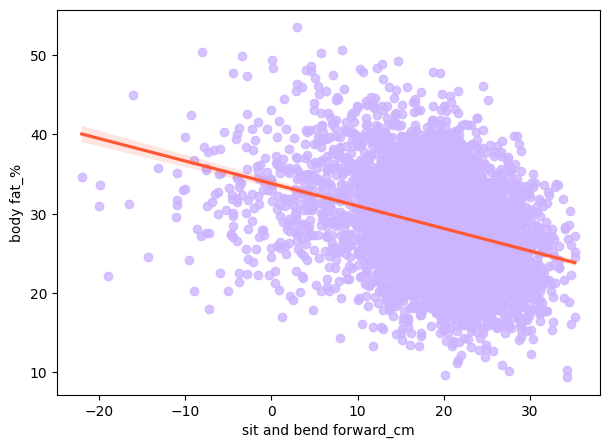

In [53]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))

sns.regplot(x=VAR, y='body fat_%', data=dataM, scatter_kws={"color": "#CCB4FF"}, line_kws={"color": "#FF5733"})
# plt.axvline(x=40, color='red', linestyle='--', linewidth=2)  
# plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('body fat_%')
plt.show()

In [54]:
# Menor
dataM[dataM[VAR] < -15]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1194  37.0      F      155.9       53.5        31.2       67.0     114.0   
3378  22.0      F      167.0       46.1        22.1       66.0     117.0   
6441  27.0      F      152.6       47.5        33.6       62.0     107.0   
7350  58.0      F      168.6       92.9        45.0       91.0     134.0   
9056  21.0      F      158.1       53.5        34.6       82.0     131.0   
9312  29.0      F      165.0       50.8        31.0       77.0     104.0   

      gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
1194       22.6                    -16.5            25.0          115.0     D   
3378       14.2                    -18.9            16.0          123.0     D   
6441       14.9                    -19.9            24.0          137.0     D   
7350       27.2                    -16.0             0.0           73.0     D   
9056       20.4                    -22.0             4.0          118.0     D   
9312       15.5                    -20.0             6.0          133.0     D   

        IMC   obesidad presion_arterial  
1194  22.01     Normal           Normal  
3378  16.53  Bajo Peso           Normal  
6441  20.40     Normal           Normal  
7350  32.68   Obesidad     Hipertensión  
9056  21.40     Normal     Hipertensión  
9312  18.66     Normal           Normal

**Observaciones**

No se han encontrado datos que indiquen una flexibilidad fuera de lo común. Aunque la media de flexibilidad en mujeres parece estar ligeramente por encima de la media habitual en este tipo de pruebas, este hecho no parece tener relevancia para los objetivos del proyecto.

https://www.topendsports.com/testing/norms/sit-and-reach.htm

#### Abdominales

count    4884.000000
mean       31.020885
std        13.828085
min         0.000000
25%        21.000000
50%        32.000000
75%        41.000000
max        74.000000
Name: sit-ups counts, dtype: float64


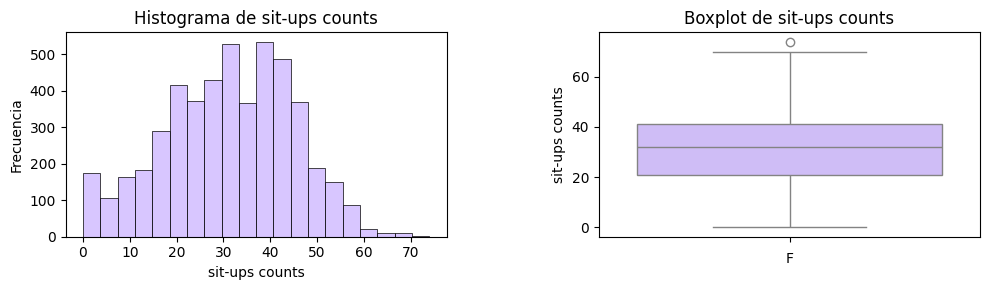

In [55]:
VAR = 'sit-ups counts'

# Función de información
informacion(dataM, VAR, 1)

In [56]:
# Mayor
dataM[dataM[VAR] > 65]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1857   22.0      F      161.8       52.4        20.3       70.0     125.0   
2201   29.0      F      163.0       54.7        21.3       74.0     120.0   
2332   28.0      F      158.0       51.9        26.3       90.0     135.0   
2382   37.0      F      162.8       56.9        16.5       97.0     134.0   
2405   27.0      F      174.3       57.0        12.3       71.0     124.0   
3787   23.0      F      167.7       58.2        26.2       77.0     139.0   
4948   23.0      F      165.3       56.4        26.5       79.0     117.0   
6655   48.0      F      156.4       48.3        16.3       88.0     129.0   
6961   26.0      F      165.0       62.8        18.6       60.0     113.0   
7310   21.0      F      172.4       67.7        22.5       78.0     120.0   
9005   30.0      F      168.4       73.0        25.8       69.0     126.0   
9517   48.0      F      157.0       47.6        17.1       97.0     127.0   
10542  21.0      F      159.6       53.3        22.9       80.0     135.0   
11427  25.0      F      157.8       54.0        30.9       84.0     126.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
1857       26.90                     25.6            67.0          192.0   
2201       35.50                     32.9            66.0          207.0   
2332       24.10                     30.9            70.0          191.0   
2382       31.00                     31.2            67.0          203.0   
2405       33.90                     30.1            68.0          201.0   
3787       26.98                     22.6            66.0          191.0   
4948       31.10                     23.5            69.0          176.0   
6655       32.40                     26.6            68.0          190.0   
6961       33.60                     26.7            69.0          218.0   
7310       33.40                     23.7            66.0          234.0   
9005       26.60                     25.3            67.0          186.0   
9517       35.40                     27.3            66.0          204.0   
10542      25.50                     24.5            74.0          201.0   
11427      26.80                     30.8            67.0          165.0   

      class    IMC    obesidad presion_arterial  
1857      A  20.02      Normal           Normal  
2201      A  20.59      Normal           Normal  
2332      A  20.79      Normal     Hipertensión  
2382      A  21.47      Normal     Hipertensión  
2405      A  18.76      Normal           Normal  
3787      A  20.69      Normal           Normal  
4948      A  20.64      Normal           Normal  
6655      B  19.75      Normal     Hipertensión  
6961      A  23.07      Normal           Normal  
7310      A  22.78      Normal           Normal  
9005      A  25.74  Sobre Peso           Normal  
9517      A  19.31      Normal     Hipertensión  
10542     A  20.92      Normal           Normal  
11427     A  21.69      Normal     Hipertensión

In [57]:
# Menor
print('Cantidad de personas con cero abdominales:',len(dataM[dataM[VAR] < 1]))

Cantidad de personas con cero abdominales: 115


<Figure size 800x600 with 0 Axes>

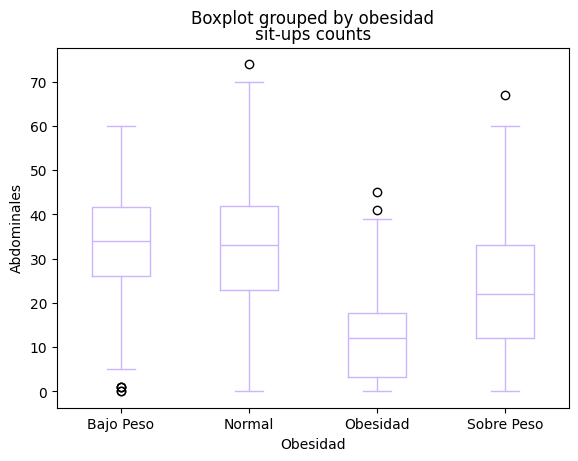

In [58]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataM.boxplot(column=VAR, by='obesidad', color = "#CCB4FF")
# plt.axhline(y=10, color='red', linestyle='--', linewidth=2)  
plt.grid(False)
plt.xlabel('Obesidad')
plt.ylabel('Abdominales')
plt.show()

<Figure size 800x600 with 0 Axes>

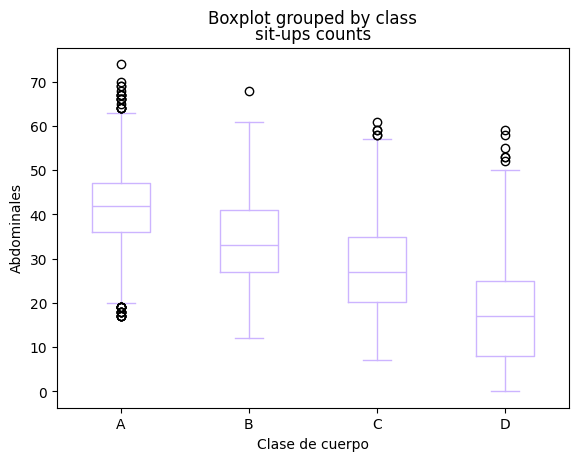

In [59]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataM.boxplot(column=VAR, by='class', color = "#CCB4FF")
plt.grid(False)
plt.xlabel('Clase de cuerpo')
plt.ylabel('Abdominales')
plt.show()

**Observaciones**

A pesar de registrar un número significativo de mujeres incapaces de completar ni siquiera una abdominal, los datos parecen estar dentro del rango considerado normal. Además, se ha confirmado que aquellas personas con menor capacidad para realizar abdominales tienden a presentar un peor estado de forma o una mayor obesidad, lo cual es lógico y coherente con lo esperado.

#### Salto largo

count    4884.000000
mean      153.659296
std        28.091411
min         0.000000
25%       136.000000
50%       156.000000
75%       173.000000
max       260.000000
Name: broad jump_cm, dtype: float64


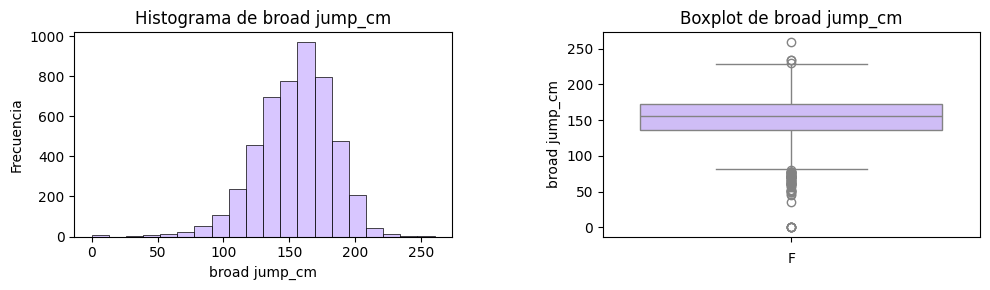

In [60]:
VAR = 'broad jump_cm'

# Función de información
informacion(dataM, VAR, 1)

In [61]:
# Mayor
dataM[dataM[VAR] > 230]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
7310   21.0      F      172.4       67.7        22.5       78.0     120.0   
9654   24.0      F      169.0       65.1        20.2       78.0     129.0   
12926  23.0      F      163.1       69.0        20.5       85.0     134.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
7310        33.4                     23.7            66.0          234.0   
9654        31.9                     14.6            51.0          234.0   
12926       28.3                     15.3            51.0          260.0   

      class    IMC    obesidad presion_arterial  
7310      A  22.78      Normal           Normal  
9654      C  22.79      Normal           Normal  
12926     B  25.94  Sobre Peso     Hipertensión

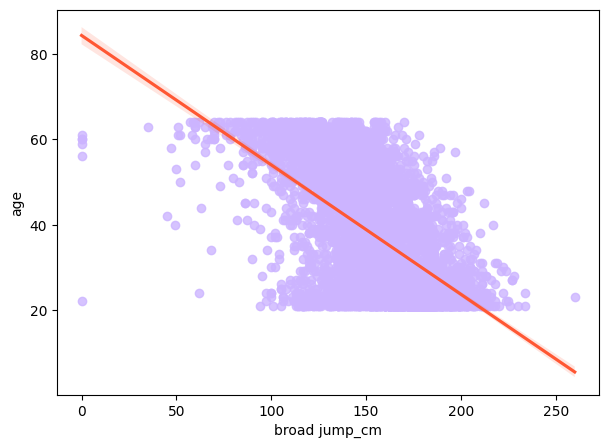

In [62]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))
sns.regplot(x=VAR, y='age', data=dataM, scatter_kws={"color": "#CCB4FF"}, line_kws={"color": "#FF5733"})
# plt.axvline(x=40, color='red', linestyle='--', linewidth=2)  
# plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('age')
plt.show()

In [63]:
# Menor
dataM[dataM[VAR] < 45]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
484   22.0      F      167.4       66.2        34.0       62.0     110.0   
1919  59.0      F      162.9       61.0        32.6       82.0     123.0   
2496  63.0      F      153.7       53.3        30.3       69.0     120.0   
4900  60.0      F      162.2       67.3        41.8       47.0     131.0   
7721  56.0      F      156.0       51.1        28.4       73.0     113.0   
7954  61.0      F      153.0       64.6        31.4       77.0     152.0   
8599  60.0      F      160.0       76.9        50.3       82.0     141.0   

      gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
484        28.5                     11.2            38.0            0.0     C   
1919       29.7                     19.5             0.0            0.0     D   
2496       17.8                     16.3             1.0           35.0     D   
4900       22.1                     19.5             0.0            0.0     D   
7721       20.7                     23.0            23.0            0.0     C   
7954       14.0                     20.6             0.0            0.0     D   
8599       20.1                     -8.1             0.0            0.0     D   

        IMC    obesidad presion_arterial  
484   23.62      Normal           Normal  
1919  22.99      Normal     Hipertensión  
2496  22.56      Normal           Normal  
4900  25.58  Sobre Peso      Hipotensión  
7721  21.00      Normal           Normal  
7954  27.60  Sobre Peso     Hipertensión  
8599  30.04    Obesidad     Hipertensión

In [64]:
dataM = dataM.drop(dataM[dataM[VAR] < 10].index)
dataM = dataM.drop(dataM[dataM[VAR] > 250].index)

**Observaciones**

Observamos que la longitud de los saltos largos está influenciada por la edad de las personas, sin embargo, hay dos casos específicos que merecen atención. Se observa que solo una persona supera los 250 cm, específicamente con un salto de 260 cm. Esta mujer tiene 23 años y una estatura de 1.63 m, lo que significa que salta aproximadamente 1 metro más que su altura, además de estar categorizada como con sobrepeso. Teniendo en cuenta esta información, se considera que este dato es atípico.

En cuanto a los saltos cortos, se obtienen distancias de 0 cm, lo cual es muy inusual dado que el paso promedio de una mujer es de 67 cm, lo que implica que bastaría con dar un paso para superar esta medida. Sin embargo, se observa que la mayoría de los registros de distancia de 0 cm pertenecen a personas adultas mayor dede 55 años, factor que puede influir. A pesar de esto, se considera que un registro de 0 cm no es normal, por lo que se categoriza como dato atípico.

Se ha eliminado el registro de la persona que logró el salto de 260 cm y los registros de personas con un salto inferior a 10 centímetros de largo, ya que estos se consideran datos atípi

https://nrpt.co.uk/training/tests/power/broad.htmcos.

### Data hombres

#### Variable objetivo

In [65]:
# Distribución de la variable target
dataH['class'].value_counts()

class
C    2237
D    2204
B    2162
A    1864
Name: count, dtype: int64

In [66]:
# Número de filas
print("Número de filas:", dataH.shape[0])

# Número de columnas
print("Número de columnas:", dataH.shape[1])

# Valores nulos
print("Valores nulos:", dataH.isna().any().any())   

Número de filas: 8467
Número de columnas: 12
Valores nulos: False


In [67]:
dataM.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class', 'IMC', 'obesidad', 'presion_arterial'],
      dtype='object')

#### Edad

count    8467.000000
mean       36.149167
std        13.103067
min        21.000000
25%        25.000000
50%        32.000000
75%        45.000000
max        64.000000
Name: age, dtype: float64


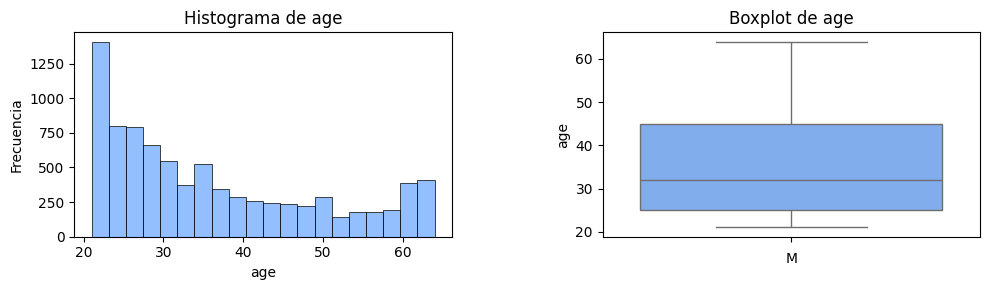

In [68]:
VAR = 'age'

# Función de información
informacion(dataH, VAR, 2)

#### Altura

count    8467.000000
mean      173.257399
std         5.810007
min       145.800000
25%       169.300000
50%       173.100000
75%       177.100000
max       193.800000
Name: height_cm, dtype: float64


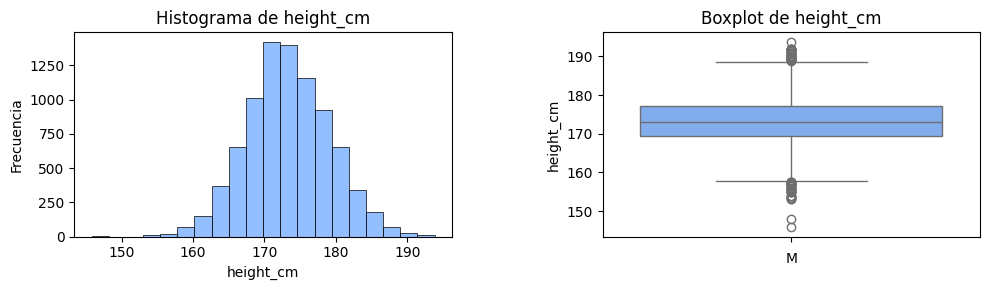

In [69]:
VAR = 'height_cm'

# Función de información
informacion(dataH, VAR, 2)

In [70]:
# Mayor y Minima
print("Altura máxima:",dataH[VAR].max())
print("Altura mínima:",dataH[VAR].min())

Altura máxima: 193.8
Altura mínima: 145.8


In [71]:
# Menores a
print("Hombres menores a 147cm :",len(dataH[dataH[VAR] < 147]))

Hombres menores a 147cm : 1


In [72]:
# Menor
dataH[dataH[VAR] < 147]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
718  52.0      M      145.8       58.6        45.8       86.0     138.0   

     gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
718       19.9                     13.2            10.0           50.0     D

In [73]:
total_grupo = len(dataH)
valor_especifico = len(dataH[dataH[VAR] < 147])

porcentaje = (valor_especifico / total_grupo) * 100
print("Hay", valor_especifico, "hombres menores de 147 cm, valor que equivale al", round(porcentaje,2), "% del total de los datos.")

Hay 1 hombres menores de 147 cm, valor que equivale al 0.01 % del total de los datos.


In [74]:
dataH = dataH.drop(dataH[dataH[VAR] < 147].index)

**OBSERVACIONES**

Observamos que únicamente hay un hombre con una estatura por debajo del límite para ser considerado enanismo, por lo que se decidió eliminar esa instancia.
https://www.mayoclinic.org/es/diseases-conditions/dwarfism/symptoms-causes/syc-20371969#:~:text=Descripci%C3%B3n%20general,4%20pies%20(122%20cm).

#### Peso

Se utilizará la misma función para crear la variable IMC y obesidad utilizada en el dataset de mujeres para tener una mejor medición de los datos

In [75]:
dataH["IMC"] = round(dataH["weight_kg"] / ((dataH["height_cm"] / 100) ** 2),2)

In [76]:
dataH["obesidad"] = dataH["IMC"].apply(cuerpo)

count    8466.000000
mean       73.581956
std         9.467812
min        36.500000
25%        67.300000
50%        72.800000
75%        79.000000
max       138.100000
Name: weight_kg, dtype: float64


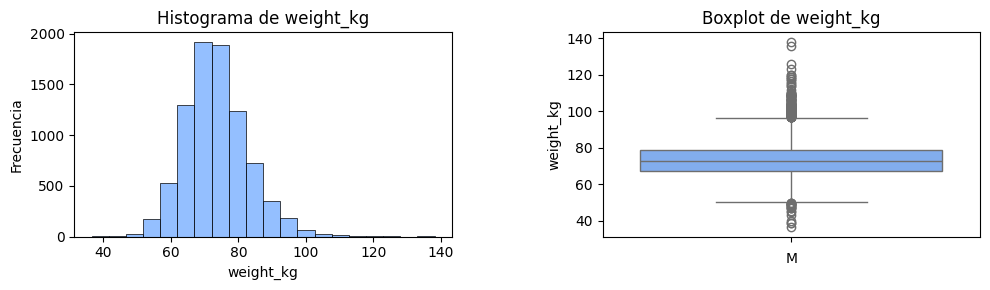

In [77]:
VAR = 'weight_kg'

# Función de información
informacion(dataH, VAR, 2)

In [78]:
# Mayor
dataH[dataH[VAR] > 120]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
554    35.0      M      191.6     125.70        35.2       85.0     156.0   
9444   22.0      M      186.2     135.78        35.2       69.0     141.0   
11145  30.0      M      190.6     138.10        30.3       82.0     131.0   
12566  22.0      M      181.2     123.00        42.7       82.0     123.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
554         58.0                      9.2            52.0          228.0   
9444        49.7                      0.1            26.0          216.0   
11145       52.3                      4.3            30.0          181.0   
12566       41.6                      5.0            36.0          177.0   

      class    IMC  obesidad  
554       D  34.24  Obesidad  
9444      D  39.16  Obesidad  
11145     D  38.01  Obesidad  
12566     D  37.46  Obesidad

In [79]:
# Menor
dataH[dataH[VAR] < 40]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1182   44.0      M      164.3       36.5        19.3       74.0     127.0   
2891   24.0      M      184.7       38.6         9.0       81.0     137.0   
9595   41.0      M      158.1       39.9        36.3       95.0     148.0   
11623  63.0      M      153.1       39.1        17.7       90.0     130.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
1182        45.7                     16.9            52.0          224.0   
2891        55.0                     19.6            56.0          242.0   
9595        39.3                      4.6            18.0          183.0   
11623       23.3                      6.6            16.0          138.0   

      class    IMC   obesidad  
1182      A  13.52  Bajo Peso  
2891      A  11.31  Bajo Peso  
9595      D  15.96  Bajo Peso  
11623     D  16.68  Bajo Peso

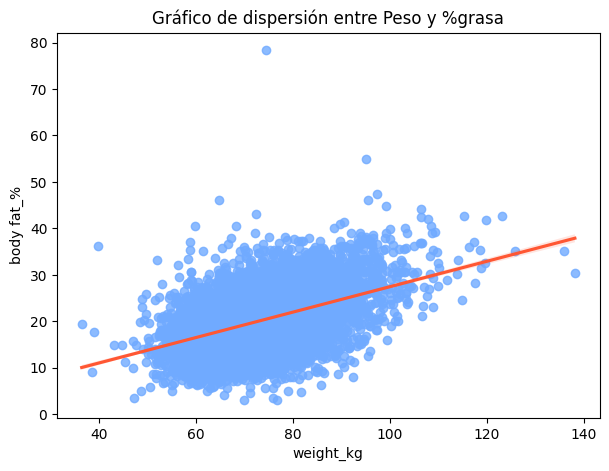

In [80]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))

sns.regplot(x=VAR, y='body fat_%', data=dataH, scatter_kws={"color": "#70AAFF"}, line_kws={"color": "#FF5733"})
plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('body fat_%')
plt.show()

**Observaciones**

En términos de peso, no se observa nada fuera de lo normal o que pueda considerarse atípico. Se observan datos tanto muy altos como bajos, pero al considerar el resto de métricas y mediciones de la persona, los datos parecen estar en línea con lo esperado para una persona con esas características, por lo que se concluye que no hay datos atípicos en términos de peso.

Sin embargo, se identifica a una persona con un porcentaje de grasa corporal muy por encima de lo normal, lo cual se tomará en cuenta al momento de analizael porcentaje de grasa directamentees.

#### Porcentaje de grasa

count    8466.000000
mean       20.185126
std         5.946542
min         3.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        78.400000
Name: body fat_%, dtype: float64


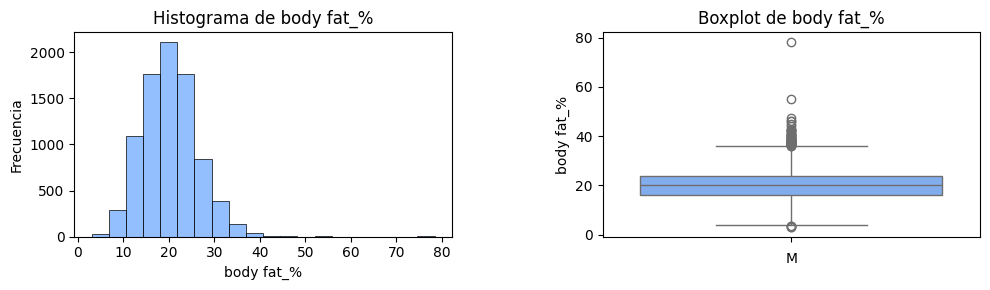

In [81]:
VAR = 'body fat_%'

# Función de información
informacion(dataH, VAR, 2)

In [82]:
# Mayor
dataH[dataH[VAR] > 60]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
735  21.0      M      177.6       74.5        78.4       69.0     122.0   

     gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
735       44.9                     26.1            59.0          235.0     A   

       IMC obesidad  
735  23.62   Normal

In [83]:
# Menor
dataH[dataH[VAR] < 5]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
460    24.0      M      170.6      69.90         3.0       75.0     123.0   
939    28.0      M      178.3      76.80         3.0       73.0     145.0   
1723   30.0      M      176.9      81.60         4.7       70.0     126.0   
3476   26.0      M      170.3      48.80         4.9       67.0     111.0   
3563   27.0      M      168.6      71.10         4.5       63.0     118.0   
7302   24.0      M      181.6      75.82         3.5       65.0     126.0   
7748   55.0      M      176.6      62.40         4.9       72.0     127.0   
8435   23.0      M      176.6      55.00         4.9       77.0     123.0   
10703  24.0      M      171.3      65.80         4.0       74.0     126.0   
12434  60.0      M      161.6      47.30         3.5       82.0     130.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
460        52.40                     23.9            60.0          280.0   
939        53.66                     29.5            68.0          259.0   
1723       65.00                     14.0            49.0          234.0   
3476       41.80                     16.6            62.0          218.0   
3563       53.00                     20.0            54.0          262.0   
7302       45.10                      8.3            38.0          254.0   
7748       40.90                     13.2            46.0          190.0   
8435       46.40                     15.0            43.0          244.0   
10703      56.30                      7.6            55.0          283.0   
12434      32.00                     13.3            22.0          156.0   

      class    IMC    obesidad  
460       A  24.02      Normal  
939       A  24.16      Normal  
1723      B  26.08  Sobre Peso  
3476      A  16.83   Bajo Peso  
3563      A  25.01  Sobre Peso  
7302      D  22.99      Normal  
7748      B  20.01      Normal  
8435      D  17.64   Bajo Peso  
10703     C  22.42      Normal  
12434     C  18.11   Bajo Peso

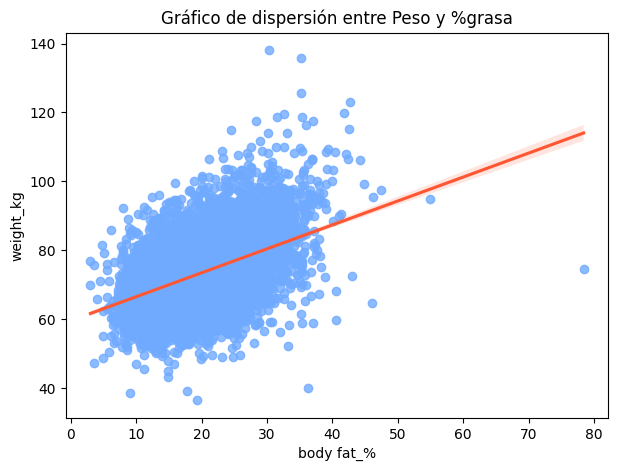

In [84]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))

sns.regplot(x=VAR, y='weight_kg', data=dataH, scatter_kws={"color": "#70AAFF"}, line_kws={"color": "#FF5733"})
plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('weight_kg')
plt.show()

<Figure size 800x600 with 0 Axes>

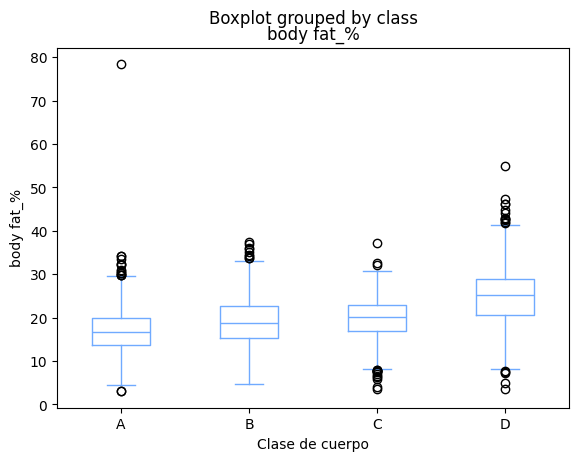

In [85]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataH.boxplot(column=VAR, by='class', color = "#70AAFF")
plt.grid(False)
plt.xlabel('Clase de cuerpo')
plt.ylabel('body fat_%')
plt.show()

<Figure size 800x600 with 0 Axes>

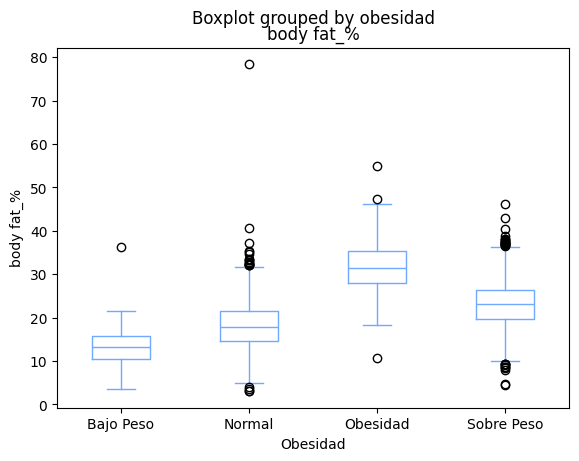

In [86]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataH.boxplot(column=VAR, by='obesidad', color = "#70AAFF")
plt.grid(False)
plt.xlabel('Obesidad')
plt.ylabel('body fat_%')
plt.show()

In [87]:
dataH = dataH.drop(dataH[dataH[VAR] > 60].index)

**Observaciones** 

Se ha identificado un dato que sobresale entre los demás. Un porcentaje de grasa corporal muy alto, específicamente del 78.4%. Al revisar el resto de las métricas de la persona, se observa que estas no coinciden con las métricas esperadas para alguien con ese nivel de grasa corporal, lo que lleva a considerar que este dato es atípico.

#### Presión arterial 

En el caso de la presión arterial, se aplicará la misma combinación de las presiones diastólicas y sistólicas utilizada en la limpieza de datos del conjunto de datos de mujeres. 

count    8465.000000
mean      133.870986
std        13.564055
min        14.000000
25%       123.000000
50%       134.000000
75%       144.000000
max       201.000000
Name: systolic, dtype: float64


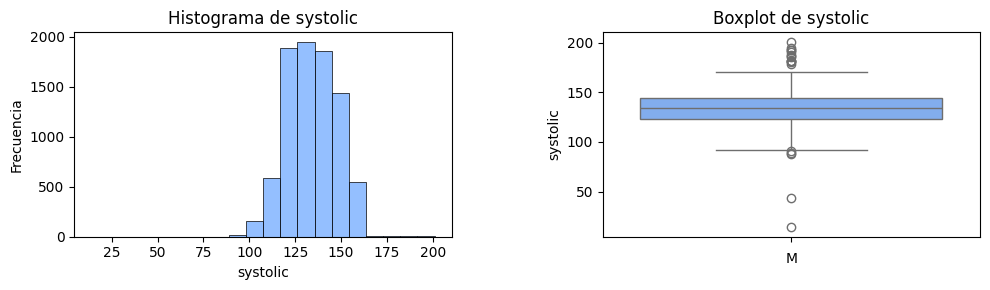

In [88]:
VAR = 'systolic'

# Función de información
informacion(dataH, VAR, 2)

count    8465.000000
mean       80.670159
std        10.351264
min         6.000000
25%        74.000000
50%        81.000000
75%        88.000000
max       126.000000
Name: diastolic, dtype: float64


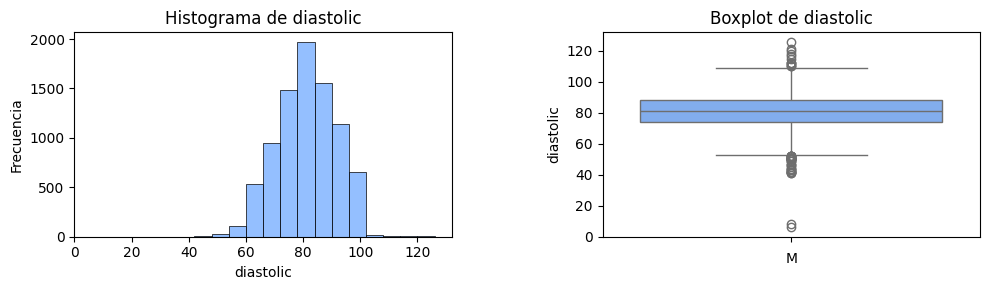

In [89]:
VAR = 'diastolic'

# Función de información
informacion(dataH, VAR, 2)

In [90]:
dataH['presion_arterial'] = dataH.apply(lambda row: categorizar_presion(row['systolic'], row['diastolic']), axis=1)

In [91]:
dataH.head()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
0       54.9                     18.4            60.0          217.0     C   
1       36.4                     16.3            53.0          229.0     A   
2       44.8                     12.0            49.0          181.0     C   
3       41.4                     15.2            53.0          219.0     B   
4       43.5                     27.1            45.0          217.0     B   

     IMC    obesidad presion_arterial  
0  25.34  Sobre Peso           Normal  
1  20.50      Normal           Normal  
2  24.18      Normal     Hipertensión  
3  23.35      Normal     Hipertensión  
4  22.41      Normal           Normal

presion_arterial
Hipertensión    4839
Normal          3480
Hipotensión      146
Name: count, dtype: int64


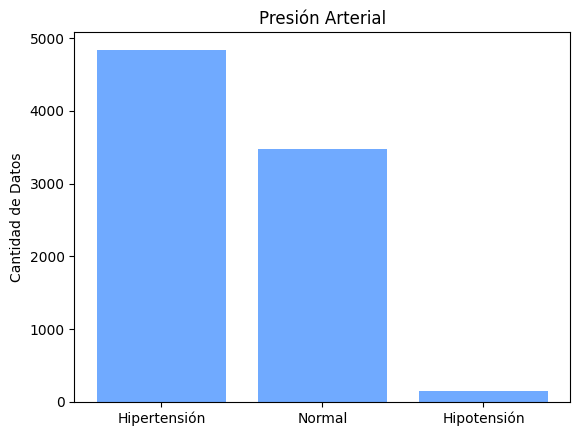

In [92]:
# Contamos la cantidad de datos diferentes en la columna 'presion_arterial'
conteo_datos = dataH['presion_arterial'].value_counts()

print(conteo_datos)

plt.bar(conteo_datos.index, conteo_datos.values, color="#70AAFF")
plt.ylabel('Cantidad de Datos')
plt.title('Presión Arterial')
plt.show()

#### Fuerza de agarre

count    8465.00000
mean       43.45103
std         7.16635
min         0.00000
25%        38.80000
50%        43.30000
75%        48.10000
max        70.50000
Name: gripForce, dtype: float64


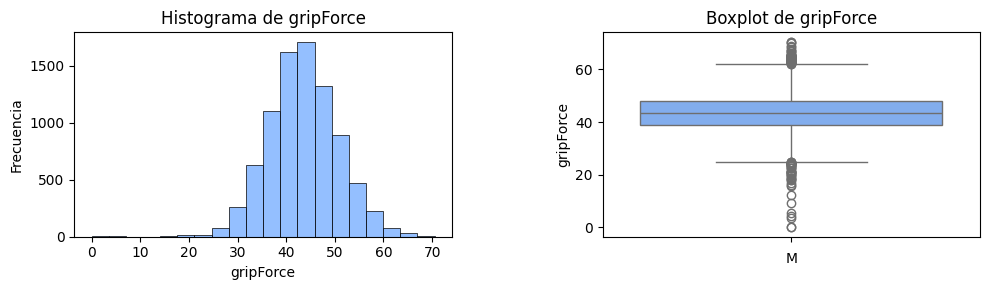

In [93]:
VAR = 'gripForce'

# Función de información
informacion(dataH, VAR, 2)

In [94]:
# Mayor
dataH[dataH[VAR] > 68]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1736   29.0      M      176.4       95.4        21.1       85.0     142.0   
4913   35.0      M      184.5      109.9        27.6       67.0     121.0   
5113   31.0      M      187.0       92.5        19.8       79.0     138.0   
5959   29.0      M      180.0       75.4        11.6       83.0     142.0   
11528  24.0      M      176.7       77.2         9.3       73.0     130.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
1736        70.5                     19.4            56.0          220.0   
4913        68.4                     12.8            47.0          200.0   
5113        70.4                     -6.0            61.0          245.0   
5959        69.9                     14.6            60.0          259.0   
11528       69.0                     17.0            60.0          288.0   

      class    IMC    obesidad presion_arterial  
1736      A  30.66    Obesidad     Hipertensión  
4913      D  32.29    Obesidad           Normal  
5113      D  26.45  Sobre Peso           Normal  
5959      B  23.27      Normal     Hipertensión  
11528     A  24.73      Normal           Normal

In [95]:
# Menor
dataH[dataH[VAR] < 10]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
5174   40.0      M      178.4       80.3        26.9       97.0     148.0   
5805   28.0      M      175.8       97.4        36.6       99.0     155.0   
9486   45.0      M      172.4       56.7         9.3       72.0     127.0   
9768   27.0      M      172.4       83.0        20.2       99.0     153.0   
10801  46.0      M      179.9       79.1        17.2       75.0     145.0   
10948  29.0      M      173.7       72.6        12.7       67.0     104.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
5174         9.4                     15.3            42.0          206.0   
5805         3.5                      5.3            35.0          210.0   
9486         0.0                      9.4            43.0          213.0   
9768         0.0                     17.2            56.0          261.0   
10801        4.4                     15.4            60.0          237.0   
10948        5.3                     17.6            53.0          227.0   

      class    IMC    obesidad presion_arterial  
5174      D  25.23  Sobre Peso     Hipertensión  
5805      D  31.52    Obesidad     Hipertensión  
9486      B  19.08      Normal           Normal  
9768      C  27.93  Sobre Peso     Hipertensión  
10801     B  24.44      Normal     Hipertensión  
10948     A  24.06      Normal           Normal

In [96]:
dataH = dataH.drop(dataH[dataH[VAR] < 10].index)

**Observaciones**

Para evaluar la fuerza de agarre, se empleó el mismo enfoque que en el análisis previo de las mujeres. Se descartaron las mediciones inferiores a 10 kg, dado que se considera poco probable que las actividades cotidianas puedan llevarse a cabo con una fuerza de agarre inferior a este umbral. Por ende, estas mediciones se clasificaron como datos atípicos.

#### Flexibilidad

count    8459.000000
mean       13.095333
std         8.443574
min       -25.000000
25%         8.800000
50%        14.200000
75%        18.300000
max       213.000000
Name: sit and bend forward_cm, dtype: float64


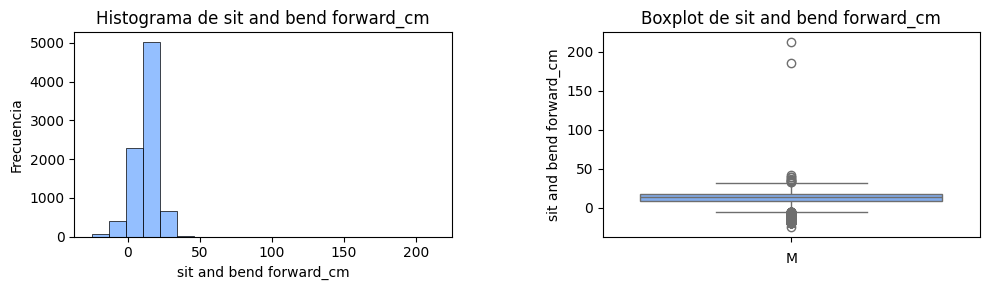

In [97]:
VAR = 'sit and bend forward_cm'

# Función de información
informacion(dataH, VAR, 2)

In [98]:
# Mayor
dataH[dataH[VAR] > 45]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
2657  33.0      M      165.6       60.4        17.8       81.0     127.0   
3355  45.0      M      164.4       64.4        24.3       96.0     142.0   

      gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
2657       38.6                    213.0            53.0          244.0     B   
3355       38.5                    185.0            44.0          223.0     A   

        IMC obesidad presion_arterial  
2657  22.03   Normal     Hipertensión  
3355  23.83   Normal     Hipertensión

In [99]:
# Menor
dataH[dataH[VAR] <= -20]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
737    26.0      M      172.0       76.7        29.2       88.0     141.0   
6186   63.0      M      167.5       71.9        29.6       92.0     137.0   
8104   47.0      M      166.2       52.9        10.6       70.0     108.0   
9400   32.0      M      177.7       83.7        32.2       84.0     127.0   
9656   56.0      M      162.0       72.0        28.6       77.0     133.0   
11008  60.0      M      167.9       72.2        28.6       91.0     153.0   
11620  23.0      M      172.5       67.8        11.5       67.0     130.0   
11959  44.0      M      179.3       69.2        19.8       59.0      98.0   
12573  46.0      M      177.3      100.6        36.5       93.0     138.0   
13380  42.0      M      172.0       76.3        32.8      100.0     147.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
737         39.1                    -25.0            22.0          197.0   
6186        36.1                    -20.0            20.0          132.0   
8104        35.6                    -20.0            13.0          155.0   
9400        42.2                    -20.0            28.0          194.0   
9656        48.3                    -20.0            30.0          183.0   
11008       31.6                    -20.0             5.0          134.0   
11620       33.5                    -20.0            51.0          246.0   
11959       38.7                    -20.0            23.0          220.0   
12573       37.8                    -20.0            30.0          180.0   
13380       33.4                    -20.0            20.0          100.0   

      class    IMC    obesidad presion_arterial  
737       D  25.93  Sobre Peso     Hipertensión  
6186      D  25.63  Sobre Peso     Hipertensión  
8104      D  19.15      Normal           Normal  
9400      D  26.51  Sobre Peso     Hipertensión  
9656      D  27.43  Sobre Peso           Normal  
11008     D  25.61  Sobre Peso     Hipertensión  
11620     D  22.79      Normal           Normal  
11959     D  21.53      Normal      Hipotensión  
12573     D  32.00    Obesidad     Hipertensión  
13380     D  25.79  Sobre Peso     Hipertensión

In [100]:
dataH = dataH.drop(dataH[dataH[VAR] > 45].index)

**Observaciones**

En cuanto a la flexibilidad, se destacan dos medidas que sobrepasan los 100 cm: 185 cm y 213 cm, registradas por individuos con estaturas de 164.4 cm y 165.6 cm respectivamente. Estos valores sugieren una capacidad de estiramiento mayor que la estatura misma, lo cual es fisiológicamente improbable. Por consiguiente, se infiere que estas mediciones constituyen datos atípicos.

Por otro lado, en el extremo opuesto del espectro, las mediciones más bajas no exceden los -25 cm, siendo numerosas las que no superan los -20 cm. Estos datos no parecen ser erróneos, ya que concuerdan con las medidas típicas para personas con esas características físicas.

#### Abdominales

count    8457.000000
mean       44.938512
std        11.726181
min         0.000000
25%        37.000000
50%        46.000000
75%        54.000000
max        80.000000
Name: sit-ups counts, dtype: float64


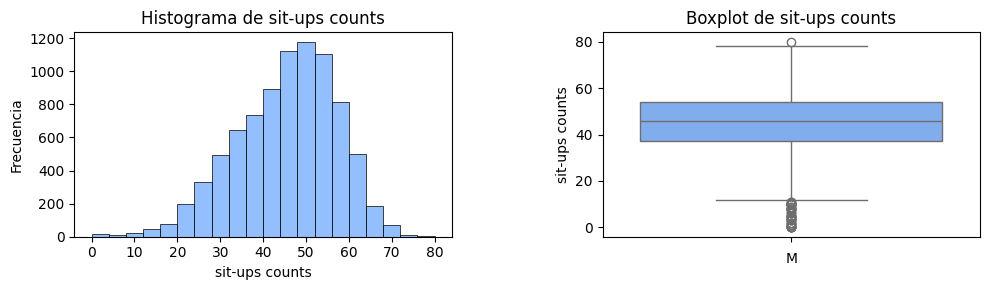

In [101]:
VAR = 'sit-ups counts'

# Función de información
informacion(dataH, VAR, 2)

In [102]:
# Mayor
dataH[dataH[VAR] > 75]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
1314   29.0      M      175.0       83.8        17.2       77.0     122.0   
2223   33.0      M      174.9       79.9        20.7       71.0     130.0   
2267   32.0      M      173.0       74.7        12.0       84.0     122.0   
9287   34.0      M      169.9       74.7        15.1       83.0     138.0   
9377   25.0      M      171.0       69.2        18.1       77.0     132.0   
10090  22.0      M      171.4       73.6        15.7       73.0     145.0   
10848  29.0      M      179.3       82.6        13.8       67.0     127.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
1314        57.6                     14.7            78.0          254.0   
2223        52.1                     16.2            76.0          244.0   
2267        53.8                     23.0            76.0          274.0   
9287        50.1                     19.0            78.0          250.0   
9377        45.7                     28.3            80.0          267.0   
10090       50.6                     17.2            76.0          273.0   
10848       51.7                     16.6            76.0          283.0   

      class    IMC    obesidad presion_arterial  
1314      D  27.36  Sobre Peso           Normal  
2223      A  26.12  Sobre Peso           Normal  
2267      A  24.96      Normal     Hipertensión  
9287      B  25.88  Sobre Peso     Hipertensión  
9377      A  23.67      Normal           Normal  
10090     A  25.05  Sobre Peso     Hipertensión  
10848     A  25.69  Sobre Peso           Normal

In [103]:
# Menor
dataH[dataH[VAR] <= 3]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
327    24.0      M      176.1       74.8        24.3       96.0     125.0   
333    41.0      M      176.2       93.1        35.8       85.0     135.0   
712    58.0      M      168.7       76.1        27.5       84.0     139.0   
1739   49.0      M      163.0       78.8        37.5       73.0     123.0   
1841   22.0      M      187.3      109.3        39.3       79.0     141.0   
4449   39.0      M      176.0       93.1        32.0       91.0     146.0   
4495   63.0      M      156.0       66.7        36.7       71.0     128.0   
4694   45.0      M      160.1       64.8        46.1       82.0     113.0   
5177   63.0      M      178.3      100.6        34.9       73.0     138.0   
5635   24.0      M      185.2       95.0        22.9       77.0     146.0   
6380   37.0      M      170.3       78.6        30.2      102.0     143.0   
6870   22.0      M      174.7       83.1        23.3       68.0     135.0   
7220   49.0      M      173.2       76.1        28.4       97.0     153.0   
11976  46.0      M      155.0       59.8        40.6       85.0     140.0   
12233  22.0      M      175.2       86.0        34.0       71.0     121.0   
12589  63.0      M      168.4       86.1        32.4       80.0     124.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
327         35.7                    -12.0             1.0          200.0   
333         36.3                      7.1             1.0          182.0   
712         34.5                      2.0             0.0            0.0   
1739        23.6                    -14.7             0.0           84.0   
1841        36.2                     17.5             1.0          211.0   
4449        44.6                      4.0             0.0          135.0   
4495        21.1                    -10.0             3.0          105.0   
4694        15.6                      1.3             3.0           43.0   
5177        42.6                      8.9             3.0          135.0   
5635        57.9                     16.2             0.0          242.0   
6380        38.8                     -7.5             0.0          152.0   
6870        42.4                      9.9             2.0          239.0   
7220        39.1                    -14.0             2.0          149.0   
11976       19.7                      7.0             3.0          132.0   
12233       44.3                      4.3             0.0          170.0   
12589       36.2                     -6.4             2.0          166.0   

      class    IMC    obesidad presion_arterial  
327       D  24.12      Normal     Hipertensión  
333       D  29.99    Obesidad     Hipertensión  
712       D  26.74  Sobre Peso     Hipertensión  
1739      D  29.66  Sobre Peso           Normal  
1841      D  31.16    Obesidad     Hipertensión  
4449      D  30.06    Obesidad     Hipertensión  
4495      D  27.41  Sobre Peso           Normal  
4694      D  25.28  Sobre Peso     Hipertensión  
5177      D  31.64    Obesidad           Normal  
5635      D  27.70  Sobre Peso     Hipertensión  
6380      D  27.10  Sobre Peso     Hipertensión  
6870      D  27.23  Sobre Peso           Normal  
7220      D  25.37  Sobre Peso     Hipertensión  
11976     D  24.89      Normal     Hipertensión  
12233     D  28.02  Sobre Peso           Normal  
12589     D  30.36    Obesidad           Normal

<Figure size 800x600 with 0 Axes>

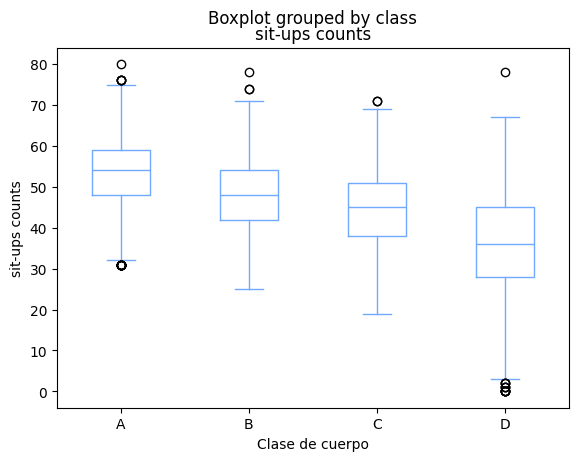

In [104]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataH.boxplot(column=VAR, by='class', color = "#70AAFF")
plt.grid(False)
plt.xlabel('Clase de cuerpo')
plt.ylabel(VAR)
plt.show()

<Figure size 800x600 with 0 Axes>

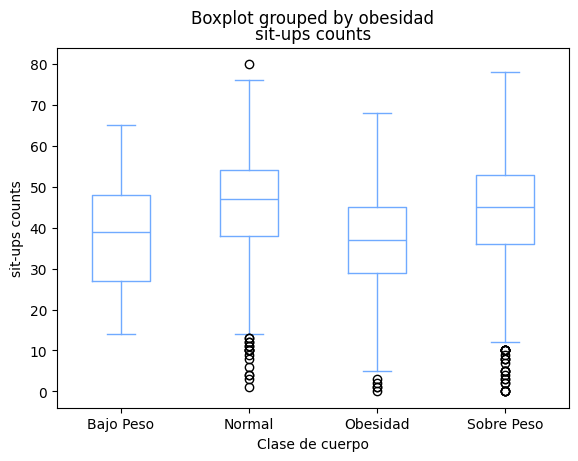

In [105]:
# Diagrama de caja
plt.figure(figsize=(8, 6))
dataH.boxplot(column=VAR, by='obesidad', color = "#70AAFF")
plt.grid(False)
plt.xlabel('Clase de cuerpo')
plt.ylabel(VAR)
plt.show()

**Observaciones**

Los datos, a pesar de registrar cantidades altas de repeticiones, no son valores fuera de lo posible o inalcanzables. Por lo tanto, se considera que están dentro de lo esperado.

Por otro lado, al analizar los valores bajos, también observamos comportamientos esperados, ya que son las personas en peor estado físico las que logran la menor cantidad de repeticiones. En consecuencia, concluimos que los datos son correctos.

#### Salto largo

count    8457.000000
mean      211.542639
std        28.218572
min         0.000000
25%       194.000000
50%       214.000000
75%       231.000000
max       303.000000
Name: broad jump_cm, dtype: float64


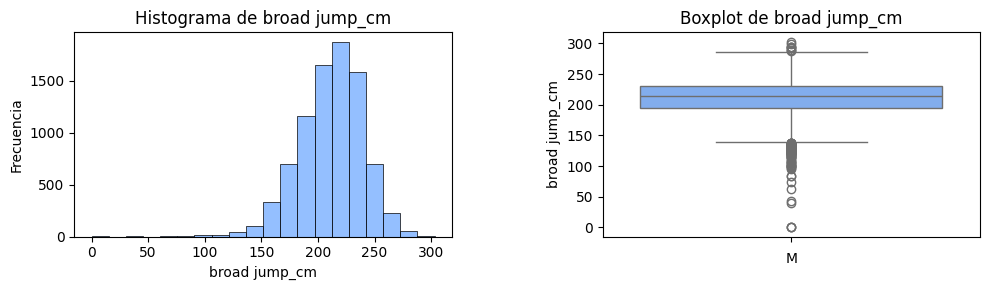

In [106]:
VAR = 'broad jump_cm'

# Función de información
informacion(dataH, VAR, 2)

In [107]:
# Mayor
dataH[dataH[VAR] > 285]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
2135   21.0      M      170.5      64.00        13.2       78.0     138.0   
3718   24.0      M      170.1      72.68        21.2       78.0     130.0   
4496   21.0      M      182.2      78.10        10.7       78.0     136.0   
5255   22.0      M      170.1      71.20        14.6       69.0     127.0   
5520   26.0      M      180.2      70.96        15.4       86.0     140.0   
6345   26.0      M      186.4      92.30         8.0       81.0     153.0   
8023   22.0      M      178.9      88.60        12.5       84.0     143.0   
9057   21.0      M      178.0      68.10         7.7       61.0     122.0   
9959   25.0      M      186.3      89.20         8.7       83.0     132.0   
11528  24.0      M      176.7      77.20         9.3       73.0     130.0   
13024  21.0      M      168.7      61.20        14.1       80.0     142.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  \
2135        48.1                     19.8            73.0          290.0   
3718        39.9                     35.2            43.0          295.0   
4496        52.0                      9.0            67.0          303.0   
5255        42.1                     24.8            61.0          290.0   
5520        49.1                     16.0            58.0          299.0   
6345        60.4                     15.2            62.0          286.0   
8023        63.7                     18.4            61.0          294.0   
9057        48.8                     16.2            66.0          293.0   
9959        62.7                     12.4            49.0          286.0   
11528       69.0                     17.0            60.0          288.0   
13024       48.7                     30.8            48.0          295.0   

      class    IMC    obesidad presion_arterial  
2135      A  22.02      Normal           Normal  
3718      C  25.12  Sobre Peso           Normal  
4496      C  23.53      Normal           Normal  
5255      B  24.61      Normal           Normal  
5520      A  21.85      Normal     Hipertensión  
6345      A  26.57  Sobre Peso     Hipertensión  
8023      A  27.68  Sobre Peso     Hipertensión  
9057      A  21.49      Normal           Normal  
9959      B  25.70  Sobre Peso     Hipertensión  
11528     A  24.73      Normal           Normal  
13024     B  21.50      Normal     Hipertensión

In [108]:
# Menor
dataH[dataH[VAR] < 40]

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
712   58.0      M      168.7       76.1        27.5       84.0     139.0   
4756  28.0      M      176.6       82.2        20.7       83.0     126.0   
7366  50.0      M      178.2       88.4        23.4       85.0     146.0   

      gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  \
712        34.5                      2.0             0.0            0.0     D   
4756       40.9                     17.6            46.0            0.0     C   
7366       54.9                     19.3            51.0            0.0     C   

        IMC    obesidad presion_arterial  
712   26.74  Sobre Peso     Hipertensión  
4756  26.36  Sobre Peso     Hipertensión  
7366  27.84  Sobre Peso     Hipertensión

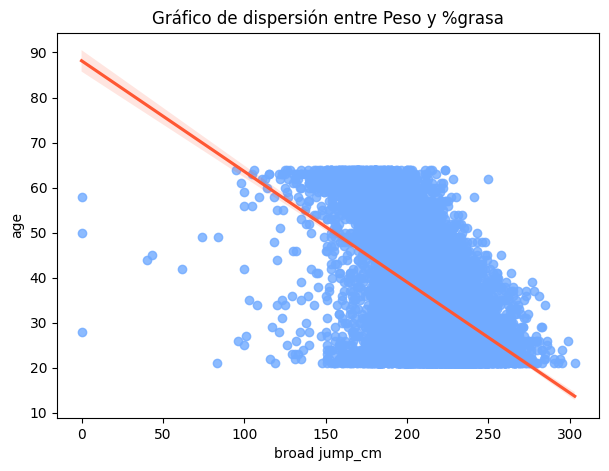

In [109]:
# Graficar un scatter plot con una línea de regresión
plt.figure(figsize=(7, 5))

sns.regplot(x=VAR, y='age', data=dataH, scatter_kws={"color": "#70AAFF"}, line_kws={"color": "#FF5733"})
plt.title('Gráfico de dispersión entre Peso y %grasa')
plt.xlabel(VAR)
plt.ylabel('age')
plt.show()

In [110]:
dataH = dataH.drop(dataH[dataH[VAR] < 40].index)

**Observaciones**

Se observan lecturas de 0 cm de distancia, lo cual se considera erróneo, ya que el paso de un hombre promedio es de 68 cm o 72 cm dependiendo de su altura. Por lo tanto, tener lecturas de 0 cm se considera un dato no válido. Sin embargo, aparte de eso, el resto de los datos parecen estar correctos o ser consistentes con lo esperado.

### Análisis de DataSets

In [111]:
## MAPEAR OBESIDAD A DATOS NUMÉRICOS
# Mapeo obesidad
obeC = {'Bajo Peso': 1, 'Normal': 2, 'Sobre Peso': 3, 'Obesidad': 4}

# Mapeo presión arterial
paC = {'Hipotensión': 1, 'Normal': 2, 'Hipertensión': 3}

# Mapeo obesidad
dataM['Obesidad'] = dataM['obesidad'].map(obeC)
dataH['Obesidad'] = dataH['obesidad'].map(obeC)

# Mapeo obesidad
dataM['PresionArt'] = dataM['presion_arterial'].map(paC)
dataH['PresionArt'] = dataH['presion_arterial'].map(paC)

In [112]:
## RESETEAR EL ÍNDICE DE LOS DATA SETS
dataM = dataM.reset_index(drop=True)
dataH = dataH.reset_index(drop=True)

In [113]:
## ELIMINAR COLUMNAS EXTRAS
# Lista de columnas a eliminar
columnas_a_eliminar = ['gender', 'height_cm', 'weight_kg', 'diastolic', 'systolic', 'obesidad', 'presion_arterial']

# Eliminar las columnas especificadas
dataM = dataM.drop(columns=columnas_a_eliminar)
dataH = dataH.drop(columns=columnas_a_eliminar)

In [114]:
## FUNCIÓN PARA ESTABLECER EL DATO MÍNIMO EN CERO
def minimo(data, columna):
    minimo = data[columna].min()
    data[columna] = data[columna] + abs(minimo)
    return data

In [115]:
## ESTABLECER EL DATO MÍNIMO EN CERO DE "sit and bend ..."
dataM = minimo(dataM, 'sit and bend forward_cm')
dataH = minimo(dataH, 'sit and bend forward_cm')

In [116]:
## FUNCIÓN PARA NORMALIZAR LOS DATOS CON MinMax
def normalize_data(df, exclude_column):
    df_copy = df.copy()

    # Normalizar el DataFrame
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df_copy.drop(exclude_column, axis=1))

    # Obtener los nombres de las columnas normalizadas
    normalized_columns = df_copy.drop(exclude_column, axis=1).columns

    # Crear un nuevo DataFrame con las columnas normalizadas
    normalized_df = pd.DataFrame(normalized_data, columns=normalized_columns)

    # Añadir la columna excluida al DataFrame resultante
    normalized_df[exclude_column] = df_copy[exclude_column]

    return normalized_df

Una vez finalizada la revisión de los valores atípicos y mediciones incorrectas, se procedió a eliminar las variables que se utilizaron para crear nuevas variables, como en el caso de la altura y el peso para calcular el IMC, y en el caso de la presión diastólica y sistólica para obtener la variable de presión arterial. Además, se eliminó la variable de género, ya que se disponía de un conjunto de datos separado para cada tipo de género.

En relación a las variables categóricas, como obesidad y presión arterial, estas se convirtieron en variables numéricas mediante un mapeo a números enteros en función del peso. En el caso de la categoría de obesidad, se asignaron números más altos a medida que aumentaba la obesidad. De manera similar, en el caso de la presión arterial, se asignaron valores más altos a medida que aumentaba la presión arterial.Eo, en el caso de "sit and bend forward_cm", que representa la flexibilidad, se observaron datos negativos que podrían afectar al modelo durante la clasificación por pesos. Para abordar esto, se sumó el valor mínimo en la columna a todos los valores de la columna, de manera que el valor cero se estableció como el valor más bajo sin afectar la distribución de las medicio

Por último, se normalizaran los datasets previo a evaluar los modelos, para que los valores altos como los registrados en los saltos largos (valores superiores a 100) no influyan en términos de peso al resto de las variables.

#### Mujeres

In [117]:
# Número de filas
print("Número de filas:", dataM.shape[0])

# Número de columnas
print("Número de columnas:", dataM.shape[1])

# Valores nulos
print("Valores nulos:", dataM.isna().any().any())   

Número de filas: 4877
Número de columnas: 10
Valores nulos: False


In [118]:
# Distribución de la variable target
dataM['class'].value_counts()

class
A    1479
B    1174
D    1124
C    1100
Name: count, dtype: int64

In [119]:
dataM.columns

Index(['age', 'body fat_%', 'gripForce', 'sit and bend forward_cm',
       'sit-ups counts', 'broad jump_cm', 'class', 'IMC', 'Obesidad',
       'PresionArt'],
      dtype='object')

In [120]:
dataM.head()

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  36.0        22.0       23.8                     43.0            27.0   
1  42.0        32.2       22.7                     22.8            18.0   
2  57.0        20.9       21.5                     52.0             0.0   
3  27.0        35.5       23.1                     35.1            28.0   
4  45.0        30.9       34.1                     41.0            30.0   

   broad jump_cm class    IMC  Obesidad  PresionArt  
0          153.0     B  20.25         2           2  
1          146.0     D  23.54         2           2  
2           90.0     D  20.93         2           2  
3          144.0     C  22.15         2           2  
4          155.0     A  24.96         2           3

**OBSERVACIONES**

Después de realizar la limpieza de datos, el conjunto de datos pasó de tener 4926 observaciones a 4877, lo que indica que se eliminaron un total de 49 observaciones. Se observó que el tipo de cuerpo "D" fue el que presentó más datos falsos o outliers.

En cuanto a las variables descriptoras, se redujo el número de columnas de 11 a 9 (sin contar la variable objetivo). De estas, solo 6 son las originales, mientras que se crearon 3 variables nuevas a partir de los datos originales (IMC, Obesidad, PresiónArterial).

También se notó un mayor número de datos del tipo de cuerpo clase A, con una diferencia de más de 300 datos en comparación con los otros tipos de cuerpo. Esto debe tenerse en cuenta al realizar la separación de datos en conjuntos de entrenamiento y prueba.

#### Hombres

In [121]:
# Número de filas
print("Número de filas:", dataH.shape[0])

# Número de columnas
print("Número de columnas:", dataH.shape[1])

# Valores nulos
print("Valores nulos:", dataH.isna().any().any())   

Número de filas: 8454
Número de columnas: 10
Valores nulos: False


In [122]:
# Distribución de la variable target
dataH['class'].value_counts()

class
C    2234
D    2200
B    2159
A    1861
Name: count, dtype: int64

In [123]:
dataH.columns

Index(['age', 'body fat_%', 'gripForce', 'sit and bend forward_cm',
       'sit-ups counts', 'broad jump_cm', 'class', 'IMC', 'Obesidad',
       'PresionArt'],
      dtype='object')

In [124]:
dataH.head()

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  27.0        21.3       54.9                     43.4            60.0   
1  25.0        15.7       36.4                     41.3            53.0   
2  31.0        20.1       44.8                     37.0            49.0   
3  32.0        18.4       41.4                     40.2            53.0   
4  28.0        17.1       43.5                     52.1            45.0   

   broad jump_cm class    IMC  Obesidad  PresionArt  
0          217.0     C  25.34         3           2  
1          229.0     A  20.50         2           2  
2          181.0     C  24.18         2           3  
3          219.0     B  23.35         2           3  
4          217.0     B  22.41         2           2

**OBSERVACIONES**

Después de realizar la limpieza de datos, el conjunto de datos pasó de tener 8467 observaciones a 8454, lo que indica que se eliminaron un total de 13 observaciones. Se observó que aproximadamente se eliminó el mismo número de datos para cada tipo de cuerpo, lo que sugiere que se mantuvo la distribución inicial de los tipos de cuerpo.

En cuanto a las variables descriptoras, se redujo el número de columnas de 11 a 9 (sin contar la variable objetivo). De estas, solo 6 son las originales, mientras que se crearon 3 variables nuevas a partir de los datos originales (IMC, Obesidad, Presión Arterial).

Se notó que el tipo de cuerpo clase A es el menos representado, con aproximadamente 300 datos menos que los otros tipos de po8467

---


## 3- Reducción de variables - ANOVA, PCA y Correlación

---

### Definición de funciones

#### Correlación

In [125]:
# FUNCIÓN PARA ANÁLISIS DE CORRELACIÓN
# correlacion_test(Var_Obj, data, correlación)
# correlacion_test('target',data,0.8)

def correlacion_test(variable_objetivo='target', data=data, valorCor=0.8):
    # NOTA: variable_objetivo, se eliminará, se puede pasar la lista
    # de variables que se desean no incluir en el test
    
    print("==========================================")
    print('\033[1m'+'ANÁLISIS DE CORRELACIÓN'+'\033[0m')
    print("==========================================")
    
    # Elimina la variable objetivo del dataset
    df = data.copy()
    df = df.drop([variable_objetivo], axis = 1)
    
    # Correlación con variable objetivo
    m_correlacion = round(df.corr(), 3)

    corr_keys = []
    
    # Iterar sobre las columnas
    for i in range(len(df.columns)):
        columna = df.columns[i]
        for j in range(i + 1, len(df.columns)):
            fila = df.columns[j]
            if abs(m_correlacion.loc[fila, columna]) > valorCor:
                # corr_keys.append((columna + ' - ' + fila, m_correlacion.loc[fila, columna]))
                corr_keys.append((columna, fila, m_correlacion.loc[fila, columna]))
                
    
    # Convertir la lista corr_keys en un DataFrame de pandas
    print('\nVARIABLES CORRELACIONADAS:\n')
    # df_corr_keys = pd.DataFrame(corr_keys, columns=['Columnas', 'Correlación'])
    df_corr_keys = pd.DataFrame(corr_keys, columns=['Variable1', '  Variable2', '  Correlación'])
    
    # Mostrar el DataFrame
    print(df_corr_keys.to_string(index=False),'\n\n')

    
    # Crea un mapa de calor de la matriz de correlación
    plt.figure(figsize=(7, 5))
    sns.heatmap(abs(m_correlacion), annot=True, cmap='gray', fmt=".2f")
    plt.title('Matriz de Correlación')
    plt.show()
    # .head()

#### ANOVA Y TUKEY HSD

In [126]:
# FUNCIÓN PARA TEST ANOVA Y TUKEY HSD EN FUNCIÓN DE LA VARIABLE "class"
# anova_test(data, Var_Obj)
# anova_test(data,'target')

def anova_test(data=data,variable='target'):  
    # NOTA: variable, es la variable target
    # modificar: grupo1 = data[data[variable] == 'A']...

    print("==========================================")
    print('\033[1m'+'ANÁLISIS ANOVA Y TUKEY HSD'+'\033[0m')
    print("==========================================")
    
    for i in numericas.columns:
        columna = i
        grupo1 = data[data[variable] == 'A']
        grupo2 = data[data[variable] == 'B']
        grupo3 = data[data[variable] == 'C']
        grupo4 = data[data[variable] == 'D']
        
        resultado_anova = f_oneway(grupo1[columna], grupo2[columna], grupo3[columna], grupo4[columna])
    
        # Crea el objeto TukeyHSD
        tukey = pairwise_tukeyhsd(data[columna], data[variable])
    
        print('COLUMNA:',columna)
        print("Estadística F:", round(resultado_anova.statistic,3))
        print("Valor p: {:0.3f}\n".format(resultado_anova.pvalue))
        print(tukey.summary(),"\n")

#### PCA

In [127]:
# FUNCIÓN PARA TEST PCA INDICANDO VARIANZA QUE SE DESEA EXPLICAR
# PCA_test (data,var_obj,varianza deseada)
# PCA_test (data,'target',0.8)

def PCA_test(df, variable_objetivo='target', varianza_deseada=0.8):
    # NOTA: variable_objetivo se eliminará, se puede pasar la lista
    # de variables que se desean no incluir en el test

    # Elimina la variable objetivo del dataset
    df = df.copy()
    df = df.drop([variable_objetivo], axis=1)
    
    print("==========================================")
    print('\033[1m'+'ANÁLISIS PCA'+'\033[0m')
    print("==========================================")

    # OBJETO PCA
    pca = PCA()
    pca_result = pca.fit_transform(df)

    # --------------------------------------------------
    # COMPONENTES TOTALES
    # --------------------------------------------------
    varianza_acumulada = 0
    num_comp = 0
    
    for componente in pca.explained_variance_ratio_:
        if varianza_acumulada <= 1:
            varianza_acumulada += componente
            num_comp += 1
    
    print("\nSe necesitan {} componentes para alcanzar 100% de varianza acumulada\n".format(num_comp))

    # --------------------------------------------------
    # GRAFICO DE CODO
    # --------------------------------------------------
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulativa')
    plt.title('Análisis PCA')
    plt.show()

    # --------------------------------------------------
    # VARIANZA APORTADA POR CADA COMPONENTE
    # --------------------------------------------------
    for i, varianza in enumerate(pca.explained_variance_ratio_[:num_comp]):
        print("Componente {:2}: {:0.2f}% de varianza explicada".format(i + 1, round(varianza * 100, 2)))
    
    # --------------------------------------------------
    # COMPONENTES NECESARIOS
    # --------------------------------------------------
    varianza_acumulada = 0
    num_comp1 = 0
    
    for componente in pca.explained_variance_ratio_:
        if varianza_acumulada <= varianza_deseada:
            varianza_acumulada += componente
            num_comp1 += 1
    
    print("\nNúmero de componentes necesarios para alcanzar {}% de varianza acumulada: {} ".format(round(varianza_deseada*100), num_comp1))

    print("\n-----------------------------------------------------------------------------\n")
    
    # --------------------------------------------------
    # VARIANZA ACUMULADA Y COMPONENTES
    # --------------------------------------------------
    lista_tuplas = []
    total = 0
    sumatoria = 0
    conteo1 = 0
    
    for componente in range(len(df.columns)):
        pcaa = abs(pca.components_)
        suma = np.sum(pcaa[:num_comp, componente])
        tupla = (round(suma, 3), df.columns[componente])
        lista_tuplas.append(tupla)
    
    lista_tuplas = sorted(lista_tuplas, key=lambda x: x[0], reverse=True)
    
    for i in range(len(lista_tuplas)):
        total += lista_tuplas[i][0]
    
    for i in range(len(df.columns)): 
        sumatoria += lista_tuplas[i][0]
        acumulado = (sumatoria / total)
        conteo1 += 1 
        if acumulado >= varianza_deseada:
            break
            
    print("Varianza acumulada deseada: {:0.2f}".format(varianza_deseada))
    print("Varianza acumulada obtenida: {:0.2f}".format(round(acumulado, 2)))
    
    print("\nHay {} columnas que explican el mayor número de varianza".format(conteo1))
    for i in range(conteo1):
        print("{:2}. Aporte: {:0.3f}  -  Variable: '{}'".format(i + 1, lista_tuplas[i][0], lista_tuplas[i][1]))

    print("\nHay {} columnas descartadas".format(len(df.columns) - conteo1))
    for i in range(len(df.columns) - conteo1):
        print("{:2}. Aporte: {:0.3f}  -  Variable: '{}'".format(i + 1, lista_tuplas[i + conteo1][0], lista_tuplas[i + conteo1][1]))

    print("\n-----------------------------------------------------------------------------\n")

    columnsPCA = [lista_tuplas[i][1] for i in range(conteo1)]
    
    columnas_df = set(df.columns)
    columnas_pca = set(columnsPCA)
    
    columnas_sobrantes_df = columnas_df - columnas_pca
    
    print("Columnas inlcuidas:\n", columnas_pca)
    print("\nColumnas no inlcuidas:\n", columnas_sobrantes_df)

    print('\nNOTA: lista guardada en "columnsPCA"')
    
    # Crear DataFrame de componentes principales
    pca_df = pd.DataFrame(pca_result[:, :num_comp1], columns=[f'PC{i+1}' for i in range(num_comp1)])
    
    return pca_df, columnsPCA

### Data mujeres

#### Correlación

ANÁLISIS DE CORRELACIÓN

VARIABLES CORRELACIONADAS:

     Variable1     Variable2    Correlación
    body fat_%           IMC          0.712
sit-ups counts broad jump_cm          0.714
           IMC      Obesidad          0.811 




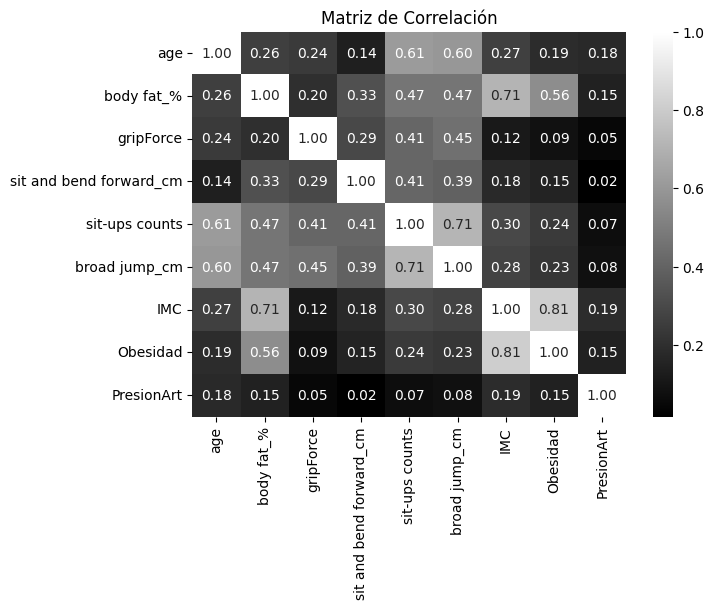

In [128]:
correlacion_test('class',dataM,0.7)

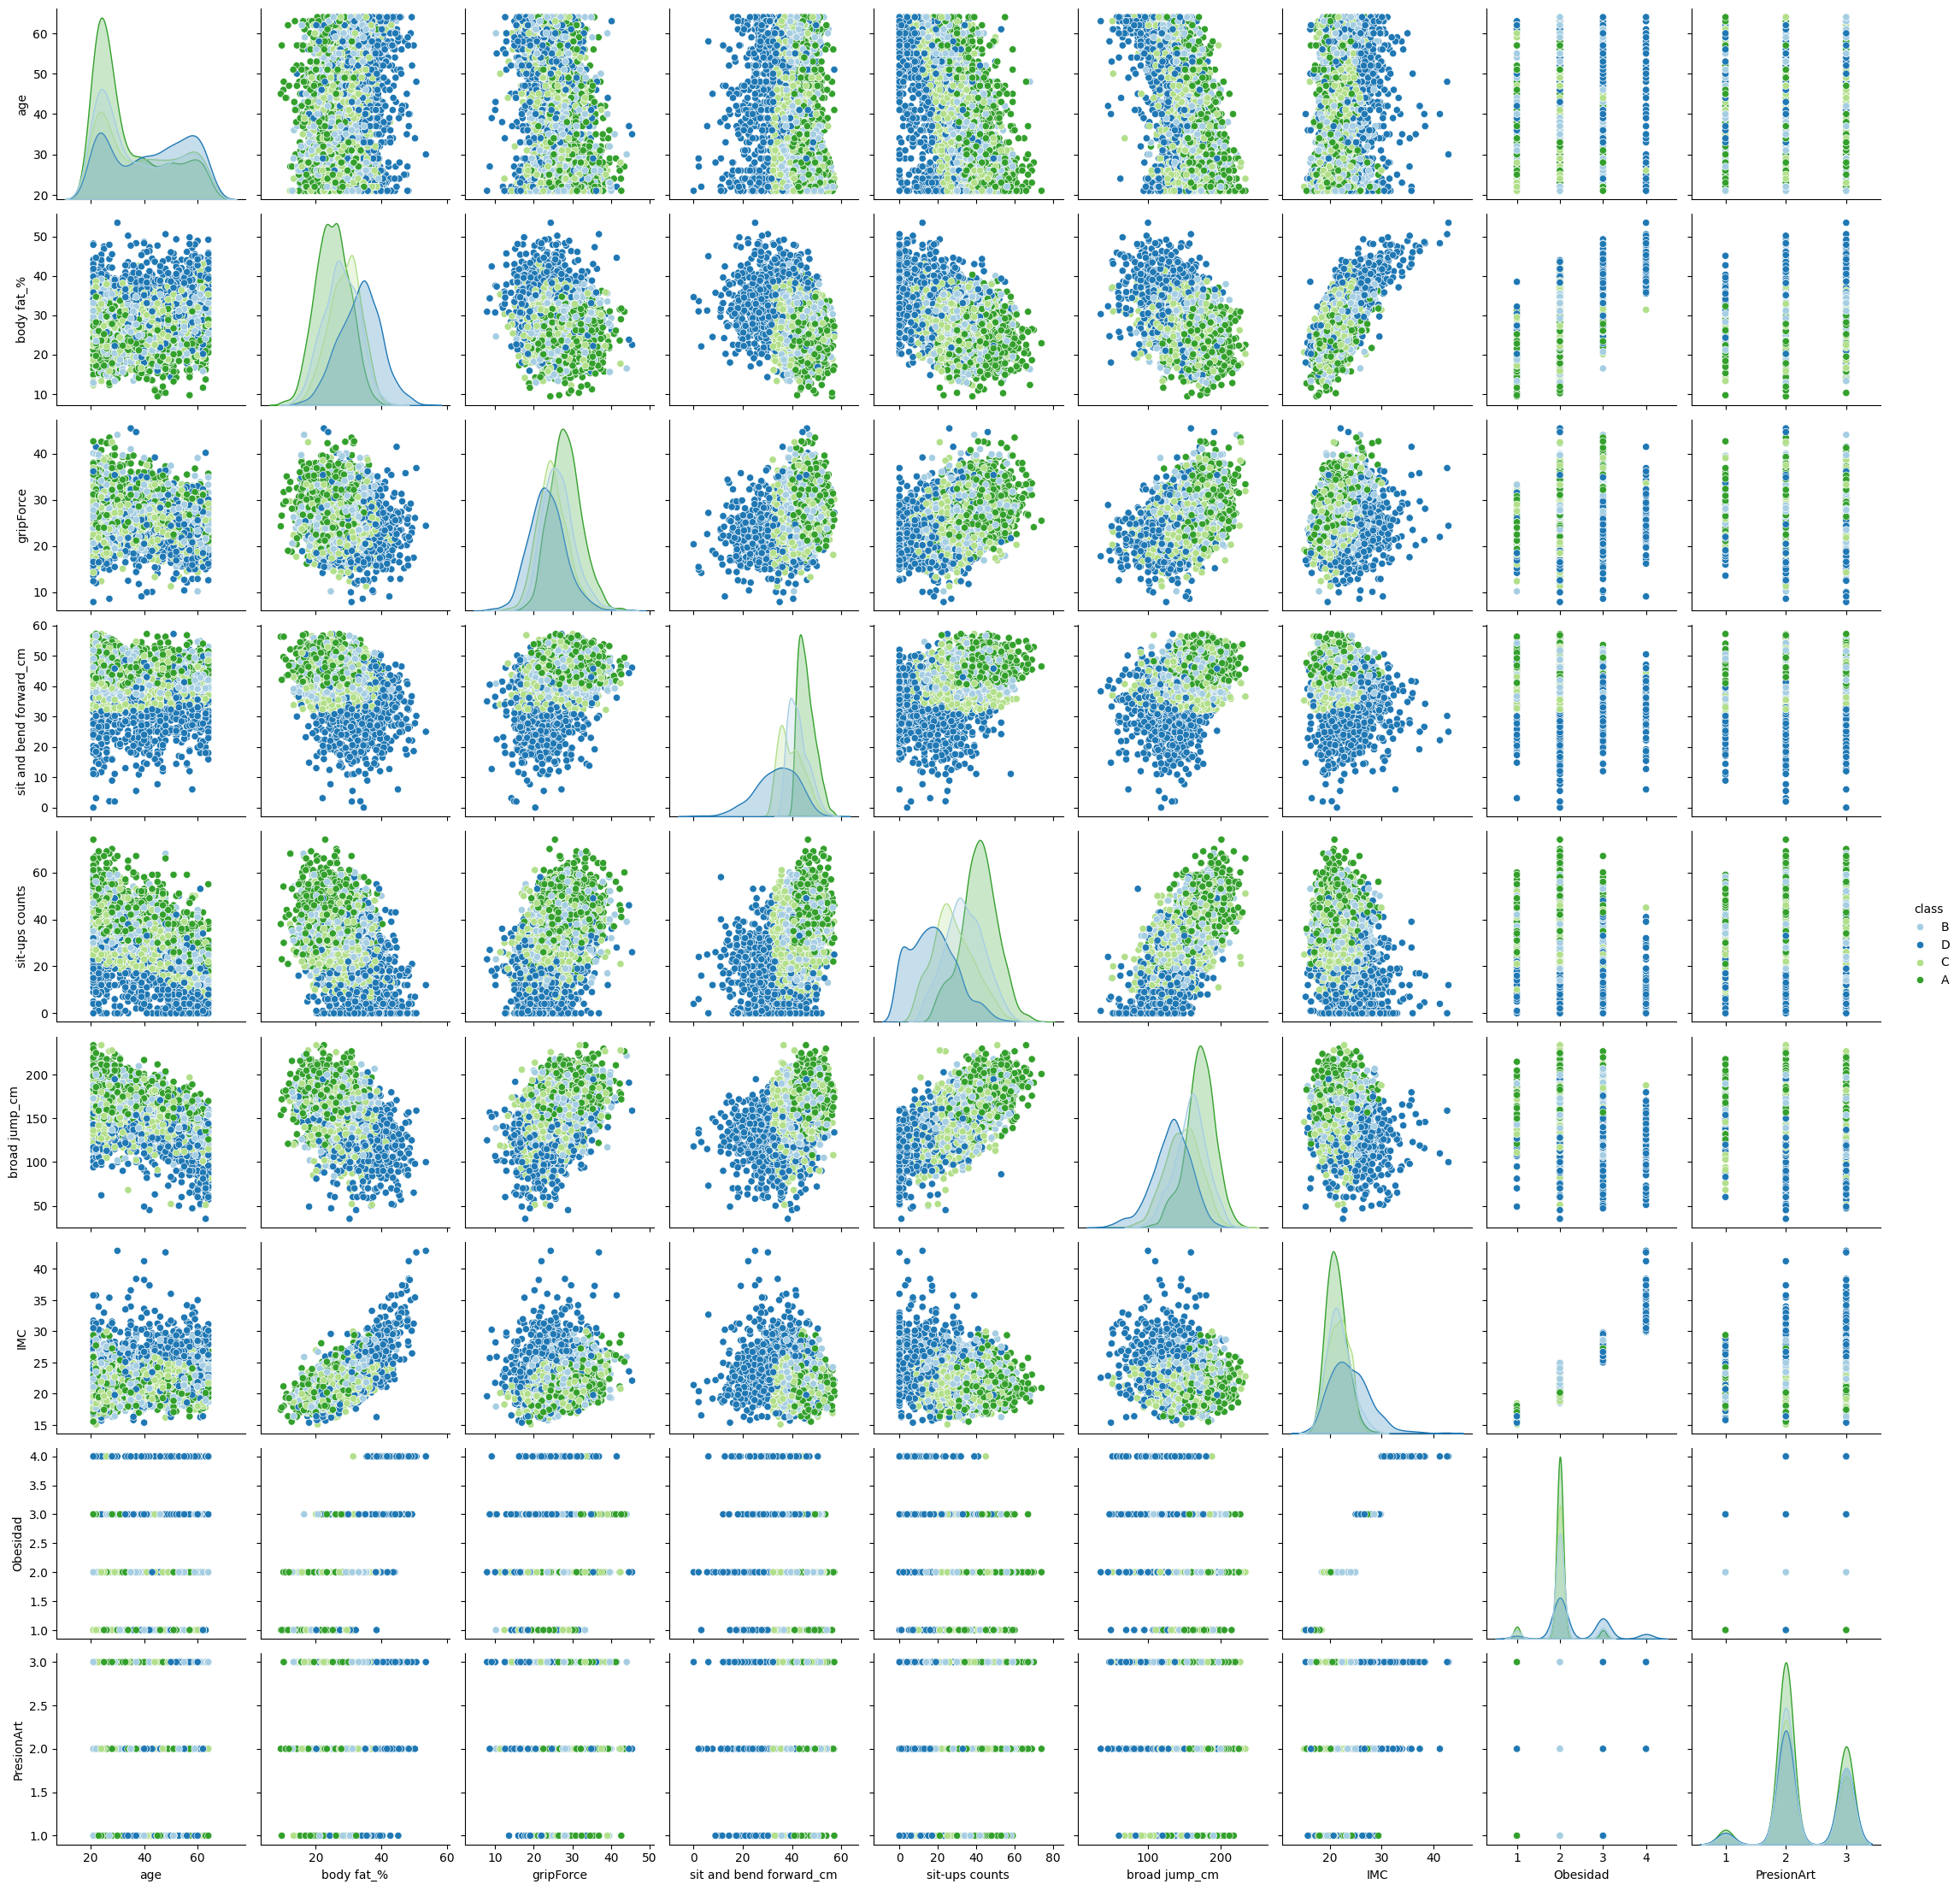

In [129]:
# Crear un DataFrame con las variables relevantes
df_subset = dataM[['age', 'body fat_%', 'gripForce', 'sit and bend forward_cm', 
                'sit-ups counts', 'broad jump_cm', 'class']]

# Pairplot con variable categórica 'class' coloreada por clase
# sns.pairplot(df_subset, hue='class', palette="Paired")
sns.pairplot(dataM, hue='class', palette="Paired")

# sns.pairplot(df_subset, hue='class', palette='Paired', hue_order=['A', 'B', 'C', 'D'])
plt.show()

#### ANOVA y TUKEY HSD

- **Estadística F:** Una estadística F más alta indica una mayor variabilidad entre los grupos. Un valor alto de la estadística F sugiere que las medias de al menos uno de los grupos son significativamente diferentes de las medias de los otros grupos.

- **Valor p:** Un valor p pequeño (generalmente menor que 0.05) indica que hay evidencia suficiente para rechazar la hipótesis nula y concluir que al menos un grupo tiene una edad media significativamente diferente de los otros grupos.

- **group1 y group2:** Los nombres de los grupos comparados.
- **meandiff:** La diferencia promedio entre las medias de los dos grupos comparados.
- **p-adj:** Un valor p menor que tu nivel de significancia (0.05) indica que hay una diferencia significativa entre los grupos.
- **lower y upper:** Intervalo de confianza del 95% para la diferencia de medias entre los dos grupos.
- **reject:** Indica si se rechaza la hipótesis nula de que no hay diferencia entre las medias de los dos grupos. Si es True, significa que se rechaza la hipótesis nula y hay una diferencia significativa

In [130]:
numericas = dataM.select_dtypes(include=['number'])

In [131]:
anova_test(dataM,'class')

ANÁLISIS ANOVA Y TUKEY HSD
COLUMNA: age
Estadística F: 79.695
Valor p: 0.000

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B   3.0911    0.0 1.6833  4.499   True
     A      C   4.8383    0.0 3.4043 6.2723   True
     A      D   8.4046    0.0 6.9793 9.8298   True
     B      C   1.7472 0.0158 0.2358 3.2585   True
     B      D   5.3134    0.0 3.8104 6.8164   True
     C      D   3.5662    0.0 2.0387 5.0938   True
-------------------------------------------------- 

COLUMNA: body fat_%
Estadística F: 507.609
Valor p: 0.000

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     A      B   2.4819   0.0 1.9391 3.0246   True
     A      C   3.6716   0.0 3.1188 4.2244   True
     A      D   8.2382   0.0 7.6888 8.7876   True
     B      C   1.1897   0.0 0.6071 1.7724   Tru

#### PCA

ANÁLISIS PCA

Se necesitan 9 componentes para alcanzar 100% de varianza acumulada



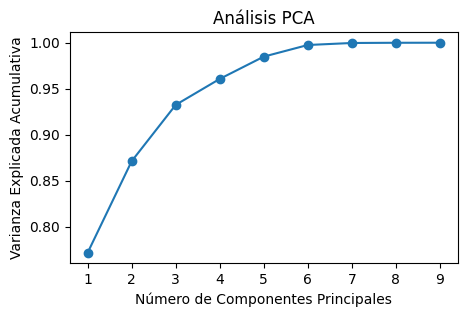

Componente  1: 77.16% de varianza explicada
Componente  2: 9.95% de varianza explicada
Componente  3: 6.12% de varianza explicada
Componente  4: 2.82% de varianza explicada
Componente  5: 2.42% de varianza explicada
Componente  6: 1.26% de varianza explicada
Componente  7: 0.22% de varianza explicada
Componente  8: 0.02% de varianza explicada
Componente  9: 0.01% de varianza explicada

Número de componentes necesarios para alcanzar 80% de varianza acumulada: 2 

-----------------------------------------------------------------------------

Varianza acumulada deseada: 0.80
Varianza acumulada obtenida: 0.85

Hay 7 columnas que explican el mayor número de varianza
 1. Aporte: 2.030  -  Variable: 'body fat_%'
 2. Aporte: 2.019  -  Variable: 'sit-ups counts'
 3. Aporte: 1.885  -  Variable: 'sit and bend forward_cm'
 4. Aporte: 1.846  -  Variable: 'age'
 5. Aporte: 1.739  -  Variable: 'IMC'
 6. Aporte: 1.693  -  Variable: 'broad jump_cm'
 7. Aporte: 1.567  -  Variable: 'gripForce'

Hay 2 col

In [132]:
pca_M, columnsPCA_M = PCA_test (dataM,'class',0.8) 

### Data Hombres

#### Correlación

ANÁLISIS DE CORRELACIÓN

VARIABLES CORRELACIONADAS:

Variable1   Variable2    Correlación
      IMC    Obesidad          0.848 




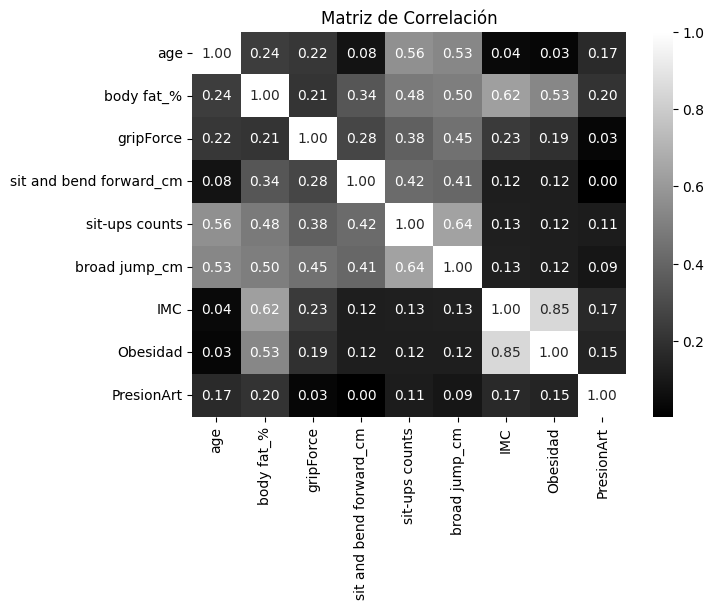

In [133]:
correlacion_test('class',dataH,0.7)

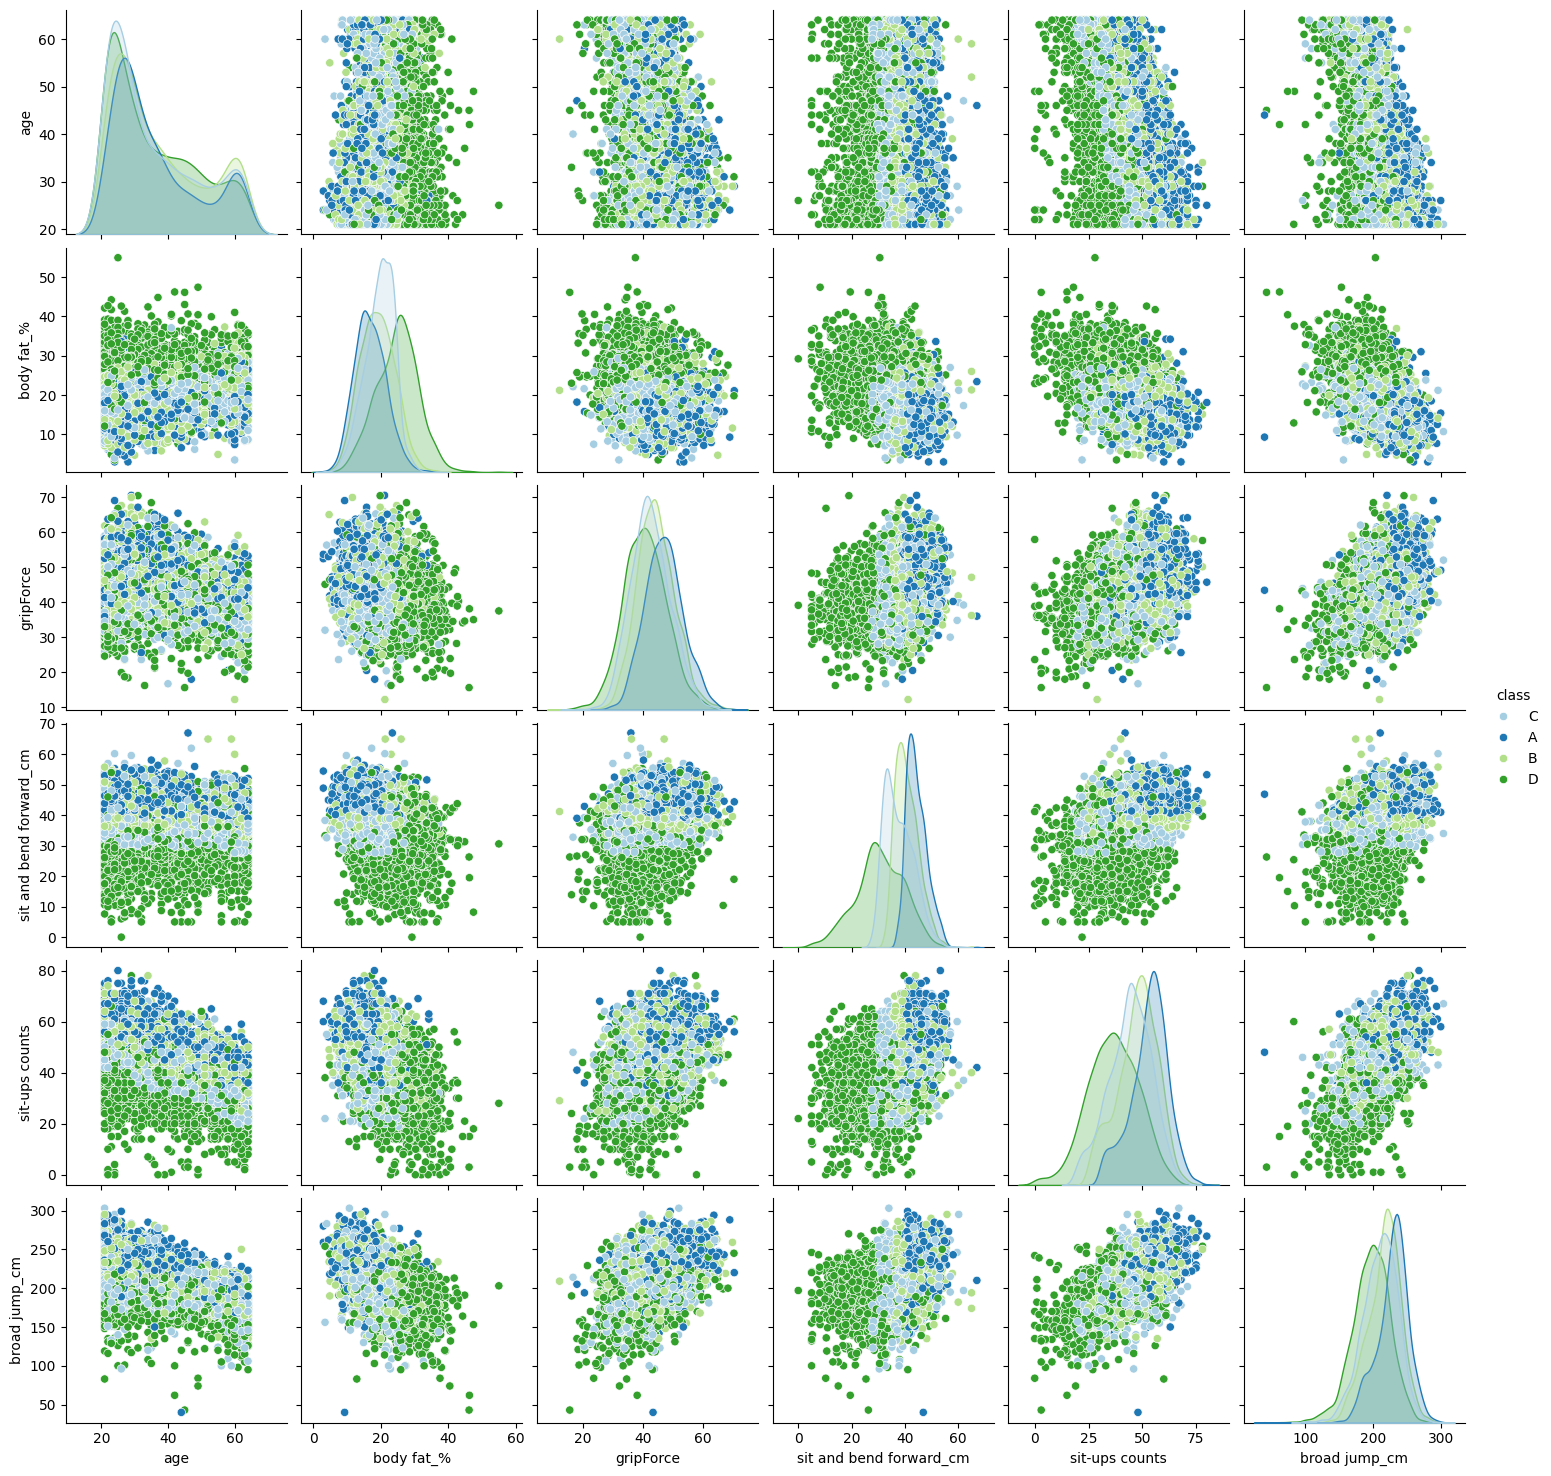

In [134]:
# Crear un DataFrame con las variables relevantes
df_subset = dataH[['age', 'body fat_%', 'gripForce', 'sit and bend forward_cm', 
                'sit-ups counts', 'broad jump_cm', 'class']]

# Pairplot con variable categórica 'class' coloreada por clase
sns.pairplot(df_subset, hue='class', palette="Paired")
# sns.pairplot(df_subset, hue='class', palette='Paired', hue_order=['A', 'B', 'C', 'D'])

plt.show()

#### ANOVA y TUKEY HSD

- **Estadística F:** Una estadística F más alta indica una mayor variabilidad entre los grupos. Un valor alto de la estadística F sugiere que las medias de al menos uno de los grupos son significativamente diferentes de las medias de los otros grupos.

- **Valor p:** Un valor p pequeño (generalmente menor que 0.05) indica que hay evidencia suficiente para rechazar la hipótesis nula y concluir que al menos un grupo tiene una edad media significativamente diferente de los otros grupos.

- **group1 y group2:** Los nombres de los grupos comparados.
- **meandiff:** La diferencia promedio entre las medias de los dos grupos comparados.
- **p-adj:** Un valor p menor que tu nivel de significancia (0.05) indica que hay una diferencia significativa entre los grupos.
- **lower y upper:** Intervalo de confianza del 95% para la diferencia de medias entre los dos grupos.
- **reject:** Indica si se rechaza la hipótesis nula de que no hay diferencia entre las medias de los dos grupos. Si es True, significa que se rechaza la hipótesis nula y hay una diferencia significativa.

In [135]:
numericas = dataH.select_dtypes(include=['number'])

In [136]:
anova_test(dataH,'class')

ANÁLISIS ANOVA Y TUKEY HSD
COLUMNA: age
Estadística F: 5.506
Valor p: 0.001

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.7238 0.2992 -0.3405  1.7881  False
     A      C  -0.7207 0.2961 -1.7767  0.3353  False
     A      D  -0.5844 0.4886 -1.6442  0.4753  False
     B      C  -1.4445 0.0015   -2.46  -0.429   True
     B      D  -1.3082 0.0054 -2.3276 -0.2889   True
     C      D   0.1363 0.9857 -0.8744  1.1469  False
---------------------------------------------------- 

COLUMNA: body fat_%
Estadística F: 892.996
Valor p: 0.000

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B    2.129    0.0 1.7103 2.5477   True
     A      C   2.7277    0.0 2.3122 3.1431   True
     A      D   7.9293    0.0 7.5124 8.3462   True
     B      C   0.5986 0.

#### PCA

ANÁLISIS PCA

Se necesitan 9 componentes para alcanzar 100% de varianza acumulada



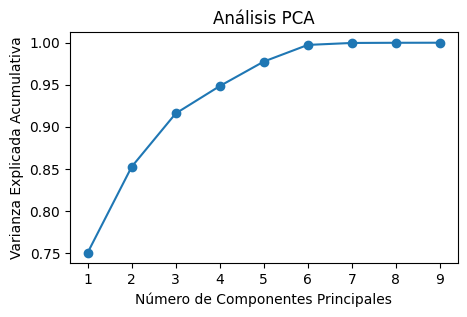

Componente  1: 75.03% de varianza explicada
Componente  2: 10.22% de varianza explicada
Componente  3: 6.34% de varianza explicada
Componente  4: 3.25% de varianza explicada
Componente  5: 2.91% de varianza explicada
Componente  6: 1.98% de varianza explicada
Componente  7: 0.23% de varianza explicada
Componente  8: 0.02% de varianza explicada
Componente  9: 0.01% de varianza explicada

Número de componentes necesarios para alcanzar 80% de varianza acumulada: 2 

-----------------------------------------------------------------------------

Varianza acumulada deseada: 0.80
Varianza acumulada obtenida: 0.85

Hay 7 columnas que explican el mayor número de varianza
 1. Aporte: 2.163  -  Variable: 'sit-ups counts'
 2. Aporte: 1.960  -  Variable: 'body fat_%'
 3. Aporte: 1.858  -  Variable: 'age'
 4. Aporte: 1.795  -  Variable: 'sit and bend forward_cm'
 5. Aporte: 1.713  -  Variable: 'gripForce'
 6. Aporte: 1.702  -  Variable: 'IMC'
 7. Aporte: 1.663  -  Variable: 'broad jump_cm'

Hay 2 co

In [137]:
pca_H, columnsPCA_H = PCA_test (dataH,'class',0.8) 

### Selección de variables

#### Data Mujeres

Tras el análisis de las variables, se observó una correlación alta (81.1\%) entre la variable IMC y Obesidad, lo cual es lo esperado dado que la variable Obesidad se creó a partir de dividir la variable IMC en 4 rangos de manera lineal positiva.

Al realizar el test ANOVA para evaluar la varianza entre clases en cada variable independiente, es decir, identificar una diferencia entre cada estado físico para cada variable, se encontró que no hay una diferencia significativa de presión arterial que permita definir el tipo de cuerpo y el desempeño físico de la persona. De igual manera, se observó que la diferencia de obesidad entre las personas atleticas y saludables no es significativa, pero sí se nota la diferencia entre con sobre peso y con obesidad.

Por último, se realizó un análisis PCA para encontrar las características que más varianza aportan a los datos. Con un mínimo del 80\% de varianza explicada, se encontró que tanto la presión arterial como la obesidad son las características que menos varianza aportan a los datos, siendo estas innecesarias si se desea explicar hasta un 80\% de la varianza de los datos. Y en el caso de los componentes principales, es necesario únicamente 2 componentes para explicar el 87.11\% de la varianza. 

Tras realizar los tres análisis, se optó por descartar las variables obesidad y presión arterial debido a que no aportan mayor información a los datos y se consideraron irrelevantes.antes.

In [138]:
dataM = dataM.drop(['PresionArt', 'Obesidad'], axis = 1)

In [139]:
dataM.head(3)

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  36.0        22.0       23.8                     43.0            27.0   
1  42.0        32.2       22.7                     22.8            18.0   
2  57.0        20.9       21.5                     52.0             0.0   

   broad jump_cm class    IMC  
0          153.0     B  20.25  
1          146.0     D  23.54  
2           90.0     D  20.93

#### Data Hombres

Tras el análisis de las variables, se observó una correlación alta (81.1%) entre la variable IMC y Obesidad, lo cual era esperado dado que la variable Obesidad se creó a partir de dividir la variable IMC en 4 rangos de manera lineal positiva.

Al realizar el test ANOVA para evaluar la varianza entre muestras que aporta cada variable dependiente a cada uno de los grupos de la variable independiente, es decir, definir el tipo de cuerpo, se encontró que no hay evidencia suficiente para afirmar indiferencia de una característica para definir el estado físico del cuerpo/estado físico de una persona, sin embargo, vale la pena observar que la edad de un hombre no determina del todo su estado físico, al igual que la presión arterial.

Por último, se realizó un análisis PCA para encontrar las características que más varianza aportan a los datos, con un mínimo del 80% de varianza explicada. Se encontró que tanto la presión arterial como la obesidad son las características que menos varianza aportan a los datos, siendo estas innecesarias si se desea explicar hasta un 80% de la varianza de los datos.

Tras realizar los tres análisis, se optó por descartar las variables obesidad y presión arterial debido a que no aportan mayor información a los datos y se consideraron irrelevantes.

In [140]:
dataH = dataH.drop(['PresionArt', 'Obesidad'], axis = 1)

In [141]:
dataH.head(3)

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  27.0        21.3       54.9                     43.4            60.0   
1  25.0        15.7       36.4                     41.3            53.0   
2  31.0        20.1       44.8                     37.0            49.0   

   broad jump_cm class    IMC  
0          217.0     C  25.34  
1          229.0     A  20.50  
2          181.0     C  24.18

---

## 4- Análisis de clases

---

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_plot_by_class(dataframe, color):

    if color == 1:
        color_comun = "#CCB4FF"
    elif color == 2:
        color_comun = "#70AAFF"
    else:
        color_comun = "#FF5733"  # Un color predeterminado en caso de que el valor de color no sea ni 1 ni 2
    
    columns_to_plot = dataframe.columns.drop(['class'])  # Obtener todas las columnas excepto 'class'
    
    # Ordenar manualmente las clases
    class_order = ['A', 'B', 'C', 'D']
    
    # Definir una paleta de colores personalizada
    custom_palette = [color_comun for _ in class_order]  # Usar el color común para todas las clases
    
    for column in columns_to_plot:
        plt.figure(figsize=(8, 5))
        
        # Crear un box plot con colores personalizados asignando hue y sin leyenda
        sns.boxplot(x='class', y=column, data=dataframe, order=class_order, palette=custom_palette, hue='class', legend=False)
        
        # Etiquetas y título
        plt.xlabel('Clase')
        plt.ylabel(column)
        plt.title(f'Distribución de "{column}" por clases')
        # plt.grid(True)
        
        # Mostrar gráfico
        plt.tight_layout()
        plt.show()

### Mujeres

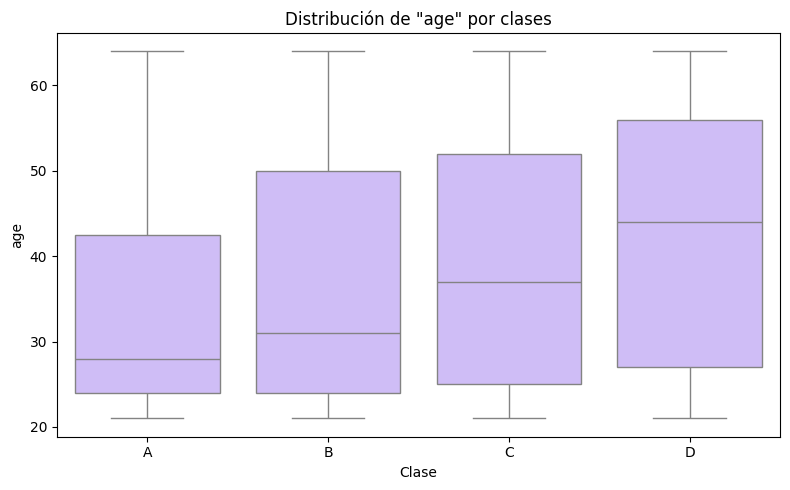

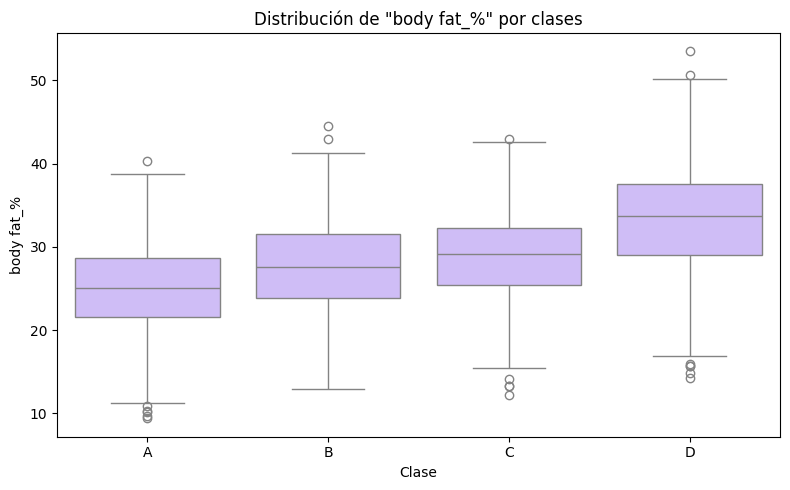

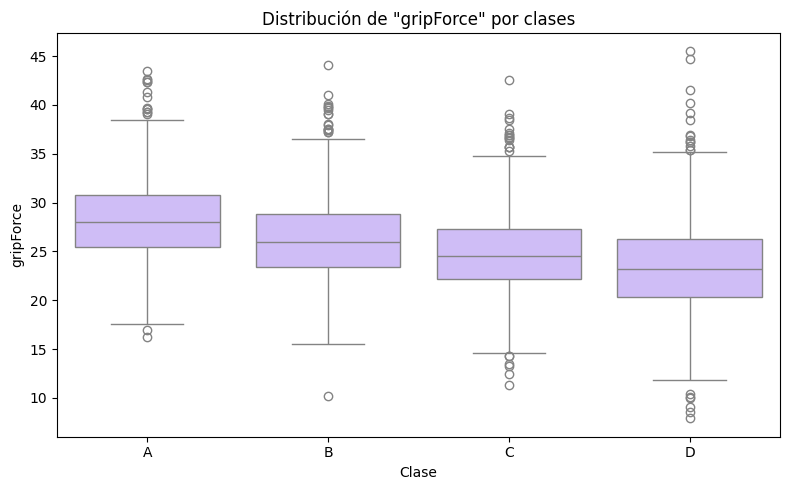

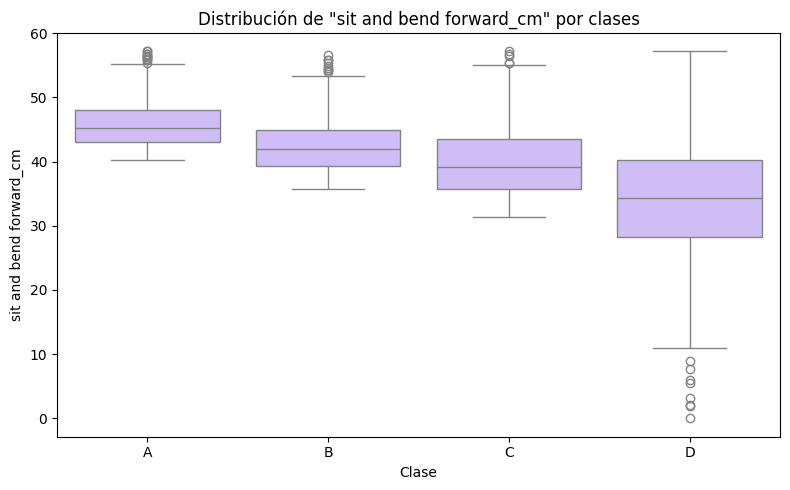

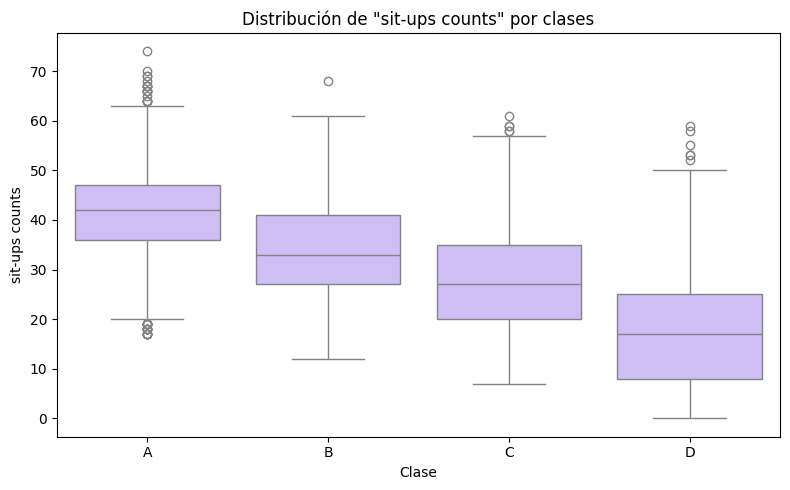

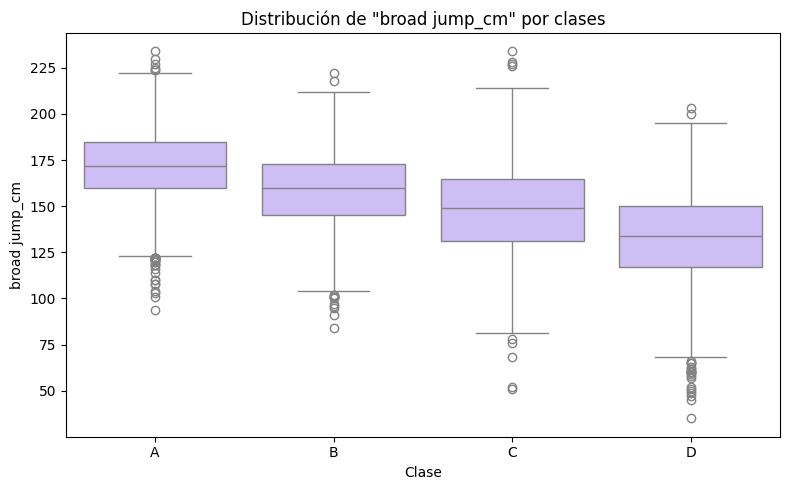

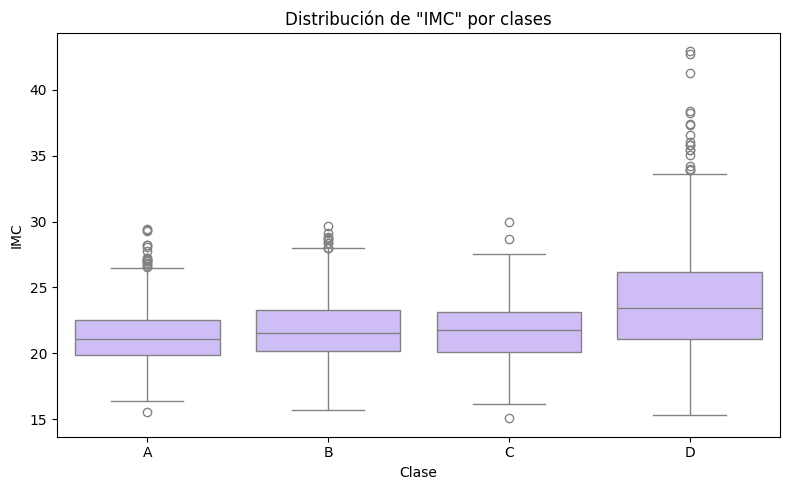

In [143]:
box_plot_by_class(dataM, 1)

### Hombres

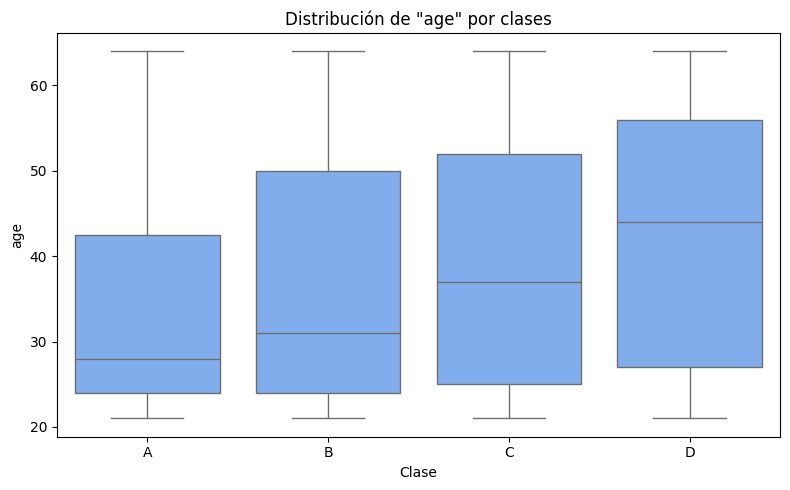

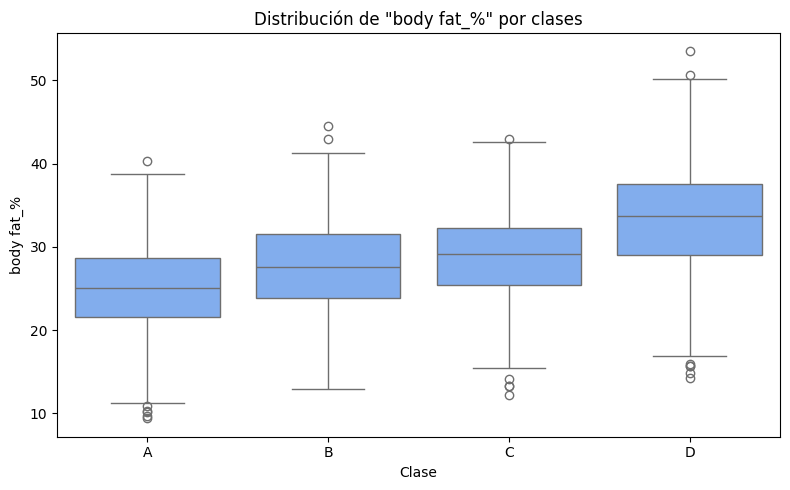

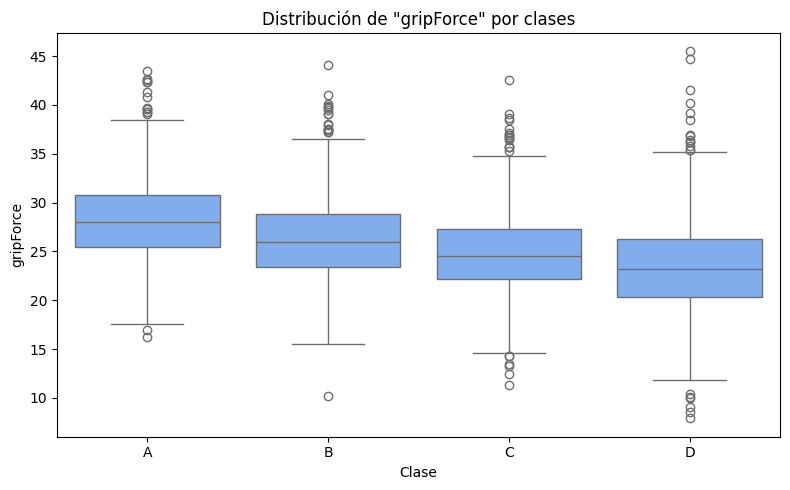

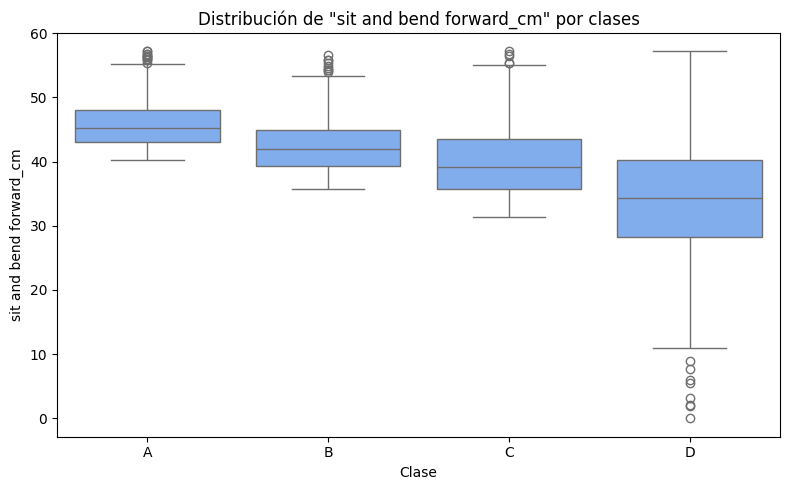

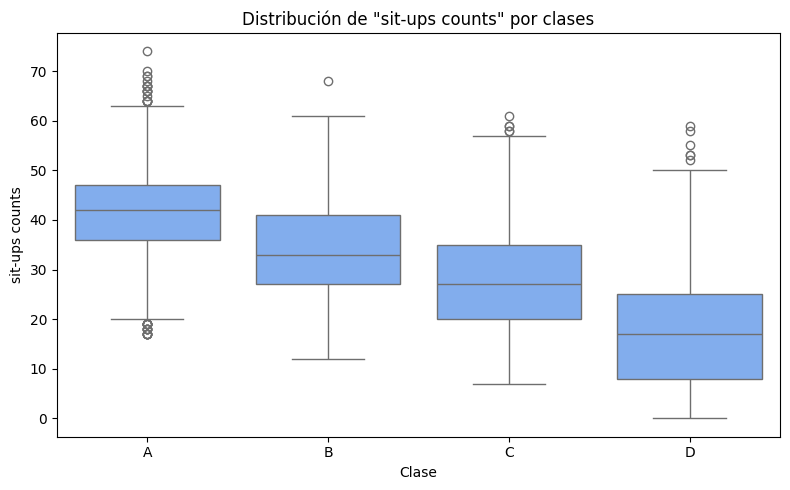

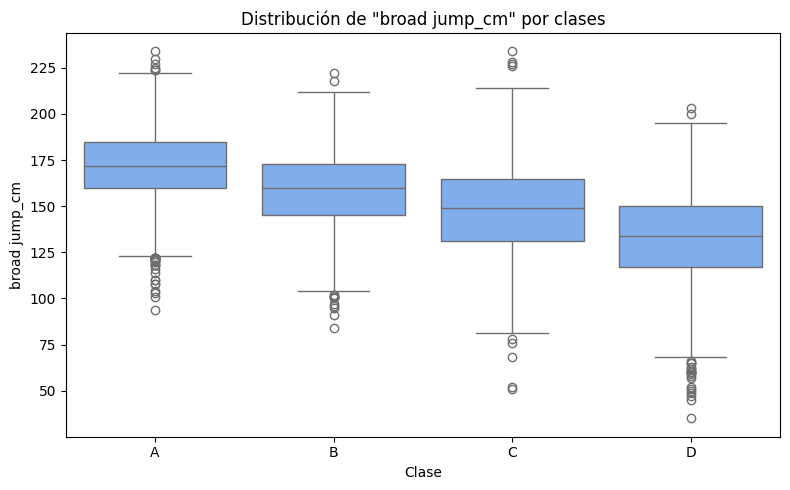

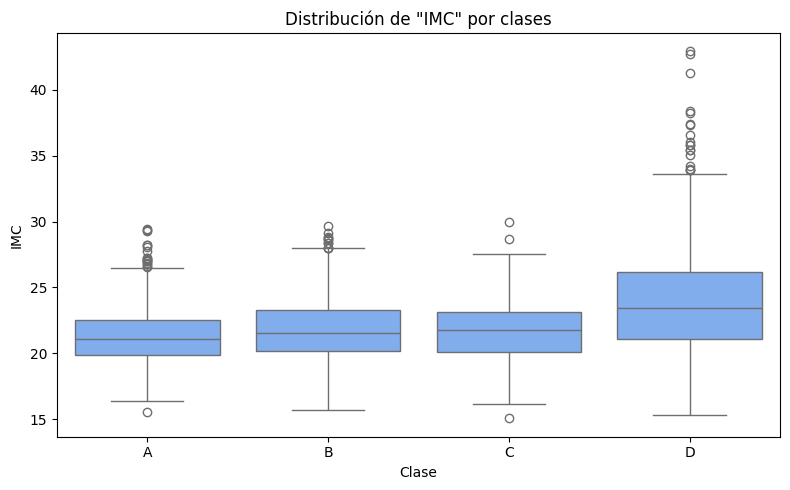

In [144]:
box_plot_by_class(dataM, 2)

---

## 5- Configuración de modelos y funciones

---

### Configuraciones preliminares

#### Unidad de procesamiento

In [145]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
    print("CUDA version:", torch.version.cuda)
    print("GPU Device Name:", torch.cuda.get_device_name(0))
    properties = torch.cuda.get_device_properties(0)
    cc = str(properties.major) + "." + str(properties.minor)
    print("CUDA Compute Capability:", cc)
    print("GPU Memory:", round(properties.total_memory / (1024 ** 3), 2), "GB")
else:
    device = torch.device("cpu")
    print("CUDA is not available.")

CUDA is available.
CUDA version: 11.8
GPU Device Name: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Compute Capability: 8.6
GPU Memory: 6.0 GB


In [146]:
# 1 para utilizar GPU - 0 para utilizar CPU
def procesador(GPU, model):
    if GPU == 1:
        device = torch.device("cuda")
        model = model.to(device)
        
        # Imprimir el dispositivo en el que se está ejecutando el modelo
        print("\nUnidad de procesamiento:", next(model.parameters()).device)
    else:
        # Imprimir el dispositivo en el que se está ejecutando el modelo
        print("Unidad de procesamiento: CPU")

    return model

### Funciones de entrenamiento de algoritmos

#### Árboles de decisión

In [147]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_DT_B = Parametros_DT_B(X_train, y_train)

def Parametros_DT_B(X_train, y_train):
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los límites de búsqueda para cada hiperparámetro
    parametros = [(1, 20),    # max_depth: La profundidad máxima del árbol.
                  (2, 20),    # min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno.
                  (1, 10)]    # min_samples_leaf: # El número mínimo de muestras requeridas para estar en un nodo hoja.

    
    # Define la función objetivo
    def objective(params):
        max_depth = params[0]
        min_samples_split = params[1]
        min_samples_leaf = params[2]

        model = DecisionTreeClassifier(max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=seed)

        # Realiza la validación cruzada y devuelve la media de la precisión
        return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))

    # Ejecuta la optimización bayesiana
    result = forest_minimize(objective, parametros, n_calls=50, random_state=seed)

    # Los mejores hiperparámetros encontrados
    parametros = result.x
    # print(parametros)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # print('Tiempo de optimización: {:0.3f}s\n'.format(execution_time))
    print('Los mejores parámetros son:')
    print(' - max_depth: {}'.format(parametros[0]))
    print(' - min_samples_split: {}'.format(parametros[1]))
    print(' - min_samples_leaf: {}\n'.format(parametros[2]))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros) 

In [148]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_DT_RS = Parametros_DT_RS(X_train, y_train)

def Parametros_DT_RS(X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los parámetros de búsqueda
    parametros = {
        'max_depth': np.arange(1, 21),
        'min_samples_split': np.arange(2, 21),
        'min_samples_leaf': np.arange(1, 11)
    }
    
    # Crear el modelo base
    model = DecisionTreeClassifier(random_state=seed)

    # Configurar la búsqueda aleatoria
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parametros,
                                       n_iter=50,    # Número de combinaciones que se probarán
                                       scoring='accuracy',
                                       cv=5,
                                       random_state=seed,
                                       n_jobs=-1)    # Usar todos los núcleos disponibles

    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Obtener los mejores parámetros
    mejores_parametros = random_search.best_params_
    parametros = [mejores_parametros['max_depth'],
                  mejores_parametros['min_samples_split'],
                  mejores_parametros['min_samples_leaf']]
    
    print('Los mejores parámetros son:')
    print(' - max_depth: {}'.format(mejores_parametros['max_depth']))
    print(' - min_samples_split: {}'.format(mejores_parametros['min_samples_split']))
    print(' - min_samples_leaf: {}\n'.format(mejores_parametros['min_samples_leaf']))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [149]:
# FUNCIÓN PARA ENTRENAR AL MODELO DE ÁRBOLES DE DECISIÓN
# DT_Model = Entrenar_DT(parametros, X_train, y_train)

def Entrenar_DT(parametros, X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Entrena un nuevo modelo utilizando los mejores hiperparámetros encontrados
    DT_Model = DecisionTreeClassifier(max_depth=parametros[0],
                                      min_samples_split=parametros[1],
                                      min_samples_leaf=parametros[2],
                                      random_state=seed)
    DT_Model.fit(X_train, y_train)

    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time

    # Calcular la precisión en el conjunto de entrenamiento
    training_accuracy = DT_Model.score(X_train, y_train)

    # Imprimir el tiempo de entrenamiento y la accuracy
    print('Tiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:0.3f}'.format(training_accuracy))
    
    return (DT_Model, training_accuracy)


#### Random Forest

In [150]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_RF = Parametros_RF_B(X_train, y_train)

def Parametros_RF_B(X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los límites de búsqueda para cada hiperparámetro
    parametros = [(5, 50),   # n_estimators: Número de árboles de decisión
                  (1, 20),   # max_depth: La profundidad máxima del árbol.
                  (2, 20),   # min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno.
                  (1, 10)]   # min_samples_leaf: Número mínimo de muestras requeridas para estar en un nodo hoja.

    # Define la función objetivo
    def objective2(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_split = params[2]
        min_samples_leaf = params[3]
    
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       random_state=seed)  # Fijar la semilla en el modelo
        
        # Realiza la validación cruzada y devuelve la media de la precisión
        return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))  

    # Ejecuta la optimización bayesiana
    result = forest_minimize(objective2, parametros, n_calls=50, random_state=seed)

    # Los mejores hiperparámetros encontrados
    parametros = result.x
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    print('Los mejores parámetros son:')
    print(' - n_estimators: {}'.format(parametros[0]))
    print(' - max_depth: {}'.format(parametros[1]))
    print(' - min_samples_split: {}'.format(parametros[2]))
    print(' - min_samples_leaf: {}\n'.format(parametros[3]))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [151]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_RF = Parametros_RF_RS(X_train, y_train)

def Parametros_RF_RS(X_train, y_train):
 # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los parámetros de búsqueda
    parametros = {
        'n_estimators': np.arange(5, 51),  # Número de árboles de decisión
        'max_depth': np.arange(1, 21),     # La profundidad máxima del árbol
        'min_samples_split': np.arange(2, 21),  # Número mínimo de muestras requeridas para dividir un nodo interno
        'min_samples_leaf': np.arange(1, 11)    # Número mínimo de muestras requeridas para estar en un nodo hoja
        # 'min_samples_split': np.arange(10, 41),  # Número mínimo de muestras requeridas para dividir un nodo interno
        # 'min_samples_leaf': np.arange(10, 41)    # Número mínimo de muestras requeridas para estar en un nodo hoja
    }
    
    # Crear el modelo base
    model = RandomForestClassifier(random_state=seed)

    # Configurar la búsqueda aleatoria
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parametros,
                                       n_iter=50,    # Número de combinaciones que se probarán
                                       scoring='accuracy',
                                       cv=5,
                                       random_state=seed,
                                       n_jobs=-1)    # Usar todos los núcleos disponibles

    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Obtener los mejores parámetros
    mejores_parametros = random_search.best_params_

    parametros = [mejores_parametros['n_estimators'],
                  mejores_parametros['max_depth'],
                  mejores_parametros['min_samples_split'],
                  mejores_parametros['min_samples_leaf']]
    
    print('Los mejores parámetros son:')
    print(' - n_estimators: {}'.format(mejores_parametros['n_estimators']))
    print(' - max_depth: {}'.format(mejores_parametros['max_depth']))
    print(' - min_samples_split: {}'.format(mejores_parametros['min_samples_split']))
    print(' - min_samples_leaf: {}\n'.format(mejores_parametros['min_samples_leaf']))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [152]:
# FUNCIÓN PARA ENTRENAR AL MODELO DE RANDOM FOREST
# RF_Model = Entrenar_RF(parametros, X_train, y_train)

def Entrenar_RF(parametros, X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Entrena un nuevo modelo utilizando los mejores hiperparámetros
    RF_Model = RandomForestClassifier(n_estimators=parametros[0],
                                      max_depth=parametros[1],
                                      min_samples_split=parametros[2],
                                      min_samples_leaf=parametros[3],
                                      random_state=seed)  # Fijar la semilla en el modelo
    RF_Model.fit(X_train, y_train)

    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time

    # Calcular la precisión en el conjunto de entrenamiento
    training_accuracy = RF_Model.score(X_train, y_train)

    # Imprimir el tiempo de entrenamiento y la accuracy
    print('Tiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:0.3f}'.format(training_accuracy))
    
    return RF_Model, training_accuracy

#### Vecinos más cercanos (K-NN)

In [153]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_KNN_B = Parametros_KNN_B(X_train, y_train)

def Parametros_KNN_B(X_train, y_train):
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los límites de búsqueda para cada hiperparámetro
    parametros = [(1, 20)]  # n_neighbors: Número de vecinos

    # Define la función objetivo
    def objective(params):
        n_neighbors = params[0]

        model = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Realiza la validación cruzada y devuelve la media de la precisión
        return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))

    # Ejecuta la optimización bayesiana
    result = forest_minimize(objective, parametros, n_calls=50, random_state=seed)

    # Los mejores hiperparámetros encontrados
    parametros = result.x
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    print('Los mejores parámetros son:')
    print(' - n_neighbors: {}\n'.format(parametros[0]))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [154]:
# FUNCIÓN PARA ENCONTRAR LOS MEJORES PARÁMETROS
# parametros_KNN_RS = Parametros_KNN_RS(X_train, y_train)

def Parametros_KNN_RS(X_train, y_train):
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los parámetros de búsqueda
    parametros = {
        'n_neighbors': np.arange(1, 21)  # Número de vecinos
    }
    
    # Crear el modelo base
    model = KNeighborsClassifier()

    # Configurar la búsqueda aleatoria
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parametros,
                                       n_iter=20,    # Número de combinaciones que se probarán
                                       scoring='accuracy',
                                       cv=5,
                                       random_state=seed,
                                       n_jobs=-1)    # Usar todos los núcleos disponibles

    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Obtener los mejores parámetros
    mejores_parametros = random_search.best_params_

    parametros = [mejores_parametros['n_neighbors']]
    
    print('Los mejores parámetros son:')
    print(' - n_neighbors: {}\n'.format(mejores_parametros['n_neighbors']))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [155]:
# FUNCIÓN PARA ENTRENAR AL MODELO DE KNN
# KNN_Model = Entrenar_KNN(parametros, X_train, y_train)

def Entrenar_KNN(parametros, X_train, y_train):
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Entrena un nuevo modelo utilizando los mejores hiperparámetros
    KNN_Model = KNeighborsClassifier(n_neighbors=parametros[0])
    KNN_Model.fit(X_train, y_train)

    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time

    # Calcular la precisión en el conjunto de entrenamiento
    training_accuracy = KNN_Model.score(X_train, y_train)

    # Imprimir el tiempo de entrenamiento y la accuracy
    print('Tiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:0.3f}'.format(training_accuracy))
    
    return (KNN_Model,training_accuracy)

### Función de predicción de resultados

In [156]:
# FUNCIÓN PARA PREDECIR RESULTADOS DE CUALQUIER MODELO
# prediction = Predecir(modelo, X_test)

def Predecir(modelo, X_test):

    modelo = modelo[0]
    
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    predictions = modelo.predict(X_test)

    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    print('\nTiempo de predicción: {:0.3f}s'.format(execution_time))
    return (predictions)

### Funciones de evaluación

#### Métricas

In [157]:
# FUNCIÓN PARA DEFINIR LAS MÉTRICAS DE UNA MATRIZ DE CONFUSIÓN 4x4
# metricas(matriz)

def metricas(m1):
    # m1[y][x]
    TP_A = m1[0][0]
    FP_A = m1[1][0]+m1[2][0]+m1[3][0]
    FN_A = m1[0][1]+m1[0][2]+m1[0][3]    
    all_A = m1[0][0]+m1[0][1]+m1[0][2]+m1[0][3]

    TP_B = m1[1][1]
    FP_B = m1[0][1]+m1[2][1]+m1[3][1]
    FN_B = m1[1][0]+m1[1][2]+m1[1][3]
    all_B = m1[1][1]+m1[1][0]+m1[1][2]+m1[1][3]

    TP_C = m1[2][2]
    FP_C = m1[1][2]+m1[0][2]+m1[3][2]
    FN_C = m1[2][1]+m1[2][0]+m1[2][3]
    all_C = m1[2][2]+m1[2][1]+m1[2][0]+m1[2][3]

    TP_D = m1[3][3]
    FP_D = m1[1][3]+m1[2][3]+m1[0][3]
    FN_D = m1[3][1]+m1[3][2]+m1[3][0]
    all_D = m1[3][3]+m1[3][1]+m1[3][2]+m1[3][0]

    # precision
    prec_A = round(TP_A / (TP_A + FP_A),3)
    prec_B = round(TP_B / (TP_B + FP_B),3)
    prec_C = round(TP_C / (TP_C + FP_C),3)
    prec_D = round(TP_D / (TP_D + FP_D),3)

    # sensibility (RECALL)
    rec_A = round(TP_A / (TP_A + FN_A),3)
    rec_B = round(TP_B / (TP_B + FN_B),3)
    rec_C = round(TP_C / (TP_C + FN_C),3)
    rec_D = round(TP_D / (TP_D + FN_D),3)

    # f1 score
    f1_A = round(2 * ((prec_A * rec_A) / (prec_A + rec_A)),3)
    f1_B = round(2 * ((prec_B * rec_B) / (prec_B + rec_B)),3)
    f1_C = round(2 * ((prec_C * rec_C) / (prec_C + rec_C)),3)
    f1_D = round(2 * ((prec_D * rec_D) / (prec_D + rec_D)),3)

    # Average
    A_prec = round((prec_A+prec_B+prec_C+prec_D)/4,3)
    A_rec = round((rec_A+rec_B+rec_C+rec_D)/4,3)
    A_F1 = round((f1_A+f1_B+f1_C+f1_D)/4,3)
    ACC = round((TP_A+TP_B+TP_C+TP_D)/(all_A+all_B+all_C+all_D),3)
    
    data = {
    'Clase': ['A', 'B', 'C', 'D', '','Accuracy'],
    'Precision': [prec_A, prec_B, prec_C, prec_D, '', A_prec],
    'Recall': [rec_A, rec_B, rec_C, rec_D, '',A_rec],
    'F1 Score': [f1_A, f1_B, f1_C, f1_D, '', A_F1]
    }
    
    return (pd.DataFrame(data),ACC)

#### Evaluación de resultados

In [158]:
# FUNCIÓN PARA EVALUAR UN MODELO
# evaluar = Evaluar(prediction, y_testM,'Titulo')

def Evaluar(predictions, y_test, Titulo,ACC):
    print("\n==========================================")
    print('\033[1m'+'RESULTADOS DEL MODELO - {}'.format(Titulo)+'\033[0m')
    print("==========================================")
    
    # Calcular métricas de evaluación con los datos de prueba 
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    # Resultados de prueba 
    print("\nMatriz de confusión:\n", conf_matrix)
    print('\033[1m'+'\nInforme de clasificación:\n'+'\033[0m')
    print("Accuracy total:", round(accuracy,3),"\n")
    report_dict = classification_report(y_test, predictions, output_dict=False)
    # print(report_dict)

    matriz,a = metricas(conf_matrix)
    
    # matriz['Precision'][5]
    # matriz['Recall'][5]
    # matriz['F1 Score'][5]
    # a

    # GUARDO LA MEDIA DE LAS MÉTRICAS
    resultados = [a,matriz['Precision'][5],matriz['Recall'][5],matriz['F1 Score'][5],round(ACC[1],3)]

    # print(resultados)

    # IMPRIMO LA MATRÍZ DE CONFUSIÓN
    print(matriz.to_string(index=False))
    

    return (resultados)

In [159]:
# FUNCIÓN PARA CREAR LISTAS PARA AGREGAR A TABLA FINAL
# lista('TITULO',resultados)
def diccionario(Titulo,resultados):
    data = {
    'MODELO': Titulo,
    'ACC. TRAIN': resultados[4],
    'ACC. TEST': resultados[0], 
    'PRECISION': resultados[1],
    'RECALL': resultados[2],
    'F1 SCORE': resultados[3] 
    }
    return (data)

#### Curva ROC

In [160]:
# FUNCIÓN PARA IMPRIMIR CURVA ROC POR MODELO
# plot_roc_curve(X_testM, y_testM, DT_Model, retornar)

def plot_roc_curve(X_test, y_test, model_cv, retornar=0):

    model_cv = model_cv[0]
    
    ## ----------------- CURVA ROC -----------------     
    y_score = model_cv.predict_proba(X_test)      # Probabilidad de pertenener a cada clase.
    predictions_full = model_cv.predict(X_test)   # Predicciones de los datos. 
    
    # Convertir las etiquetas en un formato binario
    
    y_test_bin = label_binarize(y_test, classes=np.unique(y))   # One hot encoding
    
    # Calcular la curva ROC para cada clase
    fpr = dict()       # Tasa de Falsos Positivos
    tpr = dict()       # Tasa de Verdaderos Positivos
    roc_auc = dict()   # área bajo la curva ROC (AUC) para cada clase
    Curva_Promedio = dict()
    roc_aucnames = []

    # Calcular la curva ROC para cada clase
    for i in range(len(np.unique(y))):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # print(fpr)
    
    # Calcular la macro avg ROC y AUC (curva roc promedio)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(y)))]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(len(np.unique(y))):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= len(np.unique(y))
    roc_auc["macro"] = auc(all_fpr, mean_tpr) # Curva promedio

    Curva_Promedio['all_fpr'] = all_fpr
    Curva_Promedio['mean_tpr'] = mean_tpr
    Curva_Promedio['Promedio'] = auc(all_fpr, mean_tpr) # Curva promedio
    
    # --------------------------------------------------
    # GRÁGICO
    # --------------------------------------------------

    # Tamaño de la gráfica
    plt.figure(figsize=(6, 5))
    
    # Recta pendiente
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Clasificador aleatorio', alpha=.8)

    # Curvas para cada clase
    roc_aucnames = ["A","B","C","D"] # Nombres para cada clase
    
    colors = ['blue', 'green', 'red','orange']
    # colors = ['#1BAFE4','#14C646','#EB4946','#F4A216']

    for i, color in zip(range(len(np.unique(y))), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Clase {roc_aucnames[i]} (AUC = {roc_auc[i]:.2f})')

    # Gráfica curva promedio
    plt.plot(all_fpr, mean_tpr, color='grey', linestyle='--', lw=2, label=f'Promedio (AUC = {roc_auc["macro"]:.2f})')
    
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.title('Curva ROC - Clasificador multiclase')
    plt.legend(loc='lower right')
    # plt.grid()
    plt.show()

    if retornar == 1:
        return Curva_Promedio


In [161]:
# FUNCIÓN PARA IMPRIMIR CURVA ROC PROMEDIOS
# curva_roc_promedio(modelos)

def curva_roc_promedio(modelos,titulo):
    fpr = dict()       # Tasa de Falsos Positivos
    tpr = dict()       # Tasa de Verdaderos Positivos
    roc_auc = dict()   # área bajo la curva ROC (AUC) para cada clase
    
    for i in range(len(modelos[1])):
        m = modelos[1][i]
        fpr[m] = modelos[m]['all_fpr']
        tpr[m] = modelos[m]['mean_tpr']
        roc_auc[m] = modelos[m]['Promedio']
    
    # Tamaño de la gráfica
    plt.figure(figsize=(6, 5))
    
    # Recta pendiente
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Clasificador aleatorio', alpha=.8)
    
    colors = ['blue','orange','red','green','#810f7c','#fed976']
    for i, color in zip(range(len(modelos[1])), colors):
        plt.plot(fpr[modelos[1][i]], tpr[modelos[1][i]], color=color, lw=2, label=f'Modelo {modelos[1][i]} (AUC = {roc_auc[modelos[1][i]]:.2f})')
    
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.title('Curva ROC - {}'.format(titulo))
    plt.legend(loc='lower right')
    # plt.grid()
    plt.show()

# curva_roc_promedio(modelosM)

---

## 6- Evaluación de modelos

---

### Configuraciones preliminares

##### Se utilizarán las siguientes configuraciones para los modelos
- Split entre training y test en formato 70% - 30%. con los mismos datos para todos los modelos
- Hiper-optimización de parámetros mediante Optimización Bayesiana y random forest
- Entrenamiento de modelo en training mediante 5 Fold Cross Validation.
- Entrenamiento de modelo con todos los datos de training y validación con test.

In [162]:
seed = 18

#### Separación train y test - Mujeres

In [163]:
## NORMALIZAR LOS DATASETS 
dataM = normalize_data(dataM, 'class')

In [164]:
dataM.head(10)

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  0.348837    0.285714   0.422872                 0.751748        0.364865   
1  0.488372    0.517007   0.393617                 0.398601        0.243243   
2  0.837209    0.260771   0.361702                 0.909091        0.000000   
3  0.139535    0.591837   0.404255                 0.613636        0.378378   
4  0.558140    0.487528   0.696809                 0.716783        0.405405   
5  0.093023    0.471655   0.473404                 0.784965        0.527027   
6  0.000000    0.215420   0.465426                 0.743007        0.486486   
7  0.093023    0.496599   0.454787                 0.571678        0.527027   
8  0.883721    0.471655   0.768617                 0.893357        0.337838   
9  0.046512    0.458050   0.444149                 0.865385        0.432432   

   broad jump_cm       IMC class  
0       0.592965  0.185771     B  
1       0.557789  0.303989     D  
2       0.276382  0.210205     D  
3       0.547739  0.254042     C  
4       0.603015  0.355013     A  
5       0.718593  0.345670     C  
6       0.512563  0.098814     B  
7       0.628141  0.328782     C  
8       0.437186  0.385196     A  
9       0.673367  0.250808     C

In [165]:
dataM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877 entries, 0 to 4876
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      4877 non-null   float64
 1   body fat_%               4877 non-null   float64
 2   gripForce                4877 non-null   float64
 3   sit and bend forward_cm  4877 non-null   float64
 4   sit-ups counts           4877 non-null   float64
 5   broad jump_cm            4877 non-null   float64
 6   IMC                      4877 non-null   float64
 7   class                    4877 non-null   object 
dtypes: float64(7), object(1)
memory usage: 304.9+ KB


In [166]:
X = dataM.copy()
X = X.drop(['class'], axis = 1)
y = dataM["class"]

X_trainM, X_testM, y_trainM, y_testM = train_test_split(X, y, test_size=0.3, random_state=seed)
datosM = [X_trainM, y_trainM, X_testM, y_testM]
y_trainM.value_counts()

class
A    1041
B     824
D     783
C     765
Name: count, dtype: int64

#### Separación train y test - Hombres

In [167]:
## NORMALIZAR LOS DATASETS 
dataH = normalize_data(dataH, 'class')

In [168]:
dataH.head(10)

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  0.139535    0.352601   0.732419                 0.647761          0.7500   
1  0.093023    0.244701   0.415094                 0.616418          0.6625   
2  0.232558    0.329480   0.559177                 0.552239          0.6125   
3  0.255814    0.296724   0.500858                 0.600000          0.6625   
4  0.162791    0.271676   0.536878                 0.777612          0.5625   
5  0.279070    0.653179   0.578045                 0.556716          0.5250   
6  0.767442    0.473988   0.483705                 0.650746          0.4250   
7  0.162791    0.219653   0.783877                 0.553731          0.6875   
8  0.488372    0.314066   0.536878                 0.611940          0.8500   
9  0.023256    0.159923   0.691252                 0.659701          0.6875   

   broad jump_cm       IMC class  
0       0.673004  0.489874     C  
1       0.718631  0.320880     A  
2       0.536122  0.449372     C  
3       0.680608  0.420391     B  
4       0.673004  0.387570     B  
5       0.737643  0.486383     B  
6       0.410646  0.452165     C  
7       0.657795  0.468226     B  
8       0.650190  0.402584     A  
9       0.730038  0.373254     C

In [169]:
dataH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      8454 non-null   float64
 1   body fat_%               8454 non-null   float64
 2   gripForce                8454 non-null   float64
 3   sit and bend forward_cm  8454 non-null   float64
 4   sit-ups counts           8454 non-null   float64
 5   broad jump_cm            8454 non-null   float64
 6   IMC                      8454 non-null   float64
 7   class                    8454 non-null   object 
dtypes: float64(7), object(1)
memory usage: 528.5+ KB


In [170]:
X = dataH.copy()
X = X.drop(['class'], axis = 1)
y = dataH["class"]

X_trainH, X_testH, y_trainH, y_testH = train_test_split(X, y, test_size=0.3, random_state=seed)
datosH = [X_trainH, y_trainH, X_testH, y_testH]
y_trainH.value_counts()

class
C    1554
D    1547
B    1507
A    1309
Name: count, dtype: int64

### Mujeres

In [171]:
X_train, y_train, X_test, y_test = datosM

In [172]:
y_train.value_counts()

class
A    1041
B     824
D     783
C     765
Name: count, dtype: int64

#### Árboles de decisión - Bayes

In [173]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 9
 - min_samples_split: 11
 - min_samples_leaf: 4

Tiempo de optimización: 23.015s
Tiempo de entrenamiento: 0.028s
  - Accuracy de entrenamiento: 0.786

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[366  58  10   4]
 [110 190  39  11]
 [ 41  97 176  21]
 [  6  28  36 271]]

Informe de clasificación:

Accuracy total: 0.685 

   Clase Precision Recall F1 Score
       A       0.7  0.836    0.762
       B     0.509  0.543    0.525
       C     0.674  0.525     0.59
       D     0.883  0.795    0.837
                                  
Accuracy     0.692  0.675    0.678


#### Árboles de decisión - Random Search

In [174]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 9
 - min_samples_split: 20
 - min_samples_leaf: 7

Tiempo de optimización: 0.680s
Tiempo de entrenamiento: 0.034s
  - Accuracy de entrenamiento: 0.772

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[375  56   7   0]
 [116 185  37  12]
 [ 38  99 179  19]
 [  8  25  36 272]]

Informe de clasificación:

Accuracy total: 0.691 

   Clase Precision Recall F1 Score
       A     0.698  0.856    0.769
       B     0.507  0.529    0.518
       C     0.691  0.534    0.602
       D     0.898  0.798    0.845
                                  
Accuracy     0.698  0.679    0.684


#### Random Forest - Bayes

In [175]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 40
 - max_depth: 12
 - min_samples_split: 20
 - min_samples_leaf: 3

Tiempo de optimización: 29.045s
Tiempo de entrenamiento: 0.302s
  - Accuracy de entrenamiento: 0.852

Tiempo de predicción: 0.012s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[376  54   6   2]
 [ 98 197  41  14]
 [ 29  64 229  13]
 [  6  11  41 283]]

Informe de clasificación:

Accuracy total: 0.741 

   Clase Precision Recall F1 Score
       A     0.739  0.858    0.794
       B     0.604  0.563    0.583
       C     0.722  0.684    0.702
       D     0.907   0.83    0.867
                                  
Accuracy     0.743  0.734    0.736


#### Random Forest - Random Search

In [176]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 50
 - max_depth: 13
 - min_samples_split: 18
 - min_samples_leaf: 3

Tiempo de optimización: 4.517s
Tiempo de entrenamiento: 0.390s
  - Accuracy de entrenamiento: 0.861

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[380  47   8   3]
 [ 96 200  43  11]
 [ 30  62 230  13]
 [  6  14  39 282]]

Informe de clasificación:

Accuracy total: 0.746 

   Clase Precision Recall F1 Score
       A     0.742  0.868      0.8
       B     0.619  0.571    0.594
       C     0.719  0.687    0.703
       D     0.913  0.827    0.868
                                  
Accuracy     0.748  0.738    0.741


#### KNN - Bayes

In [177]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 15

Tiempo de optimización: 16.554s
Tiempo de entrenamiento: 0.013s
  - Accuracy de entrenamiento: 0.695

Tiempo de predicción: 0.153s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[396  39   2   1]
 [148 166  33   3]
 [ 49 109 171   6]
 [  9  17  76 239]]

Informe de clasificación:

Accuracy total: 0.664 

   Clase Precision Recall F1 Score
       A     0.658  0.904    0.762
       B     0.502  0.474    0.488
       C     0.606   0.51    0.554
       D      0.96  0.701     0.81
                                  
Accuracy     0.682  0.647    0.654


#### KNN - Random Search

In [178]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 15

Tiempo de optimización: 0.799s
Tiempo de entrenamiento: 0.011s
  - Accuracy de entrenamiento: 0.695

Tiempo de predicción: 0.150s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[396  39   2   1]
 [148 166  33   3]
 [ 49 109 171   6]
 [  9  17  76 239]]

Informe de clasificación:

Accuracy total: 0.664 

   Clase Precision Recall F1 Score
       A     0.658  0.904    0.762
       B     0.502  0.474    0.488
       C     0.606   0.51    0.554
       D      0.96  0.701     0.81
                                  
Accuracy     0.682  0.647    0.654


#### Resultados

In [179]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosM = pd.DataFrame(lista_de_diccionarios)

In [180]:
resultadosM.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.786      0.685      0.692   0.675   
1  Árbol de decisión - RandomS       0.772      0.691      0.698   0.679   
2        Random Forest - Bayes       0.852      0.741      0.743   0.734   
3      Random Forest - RandomS       0.861      0.746      0.748   0.738   
4                  KNN - Bayes       0.695      0.664      0.682   0.647   
5                KNN - RandomS       0.695      0.664      0.682   0.647   

   F1 SCORE  
0     0.678  
1     0.684  
2     0.736  
3     0.741  
4     0.654  
5     0.654

In [181]:
# # Graficas promedio
# modelosM_RS = {}
# modelosM_RS["RF_RS"] = RF_RS_M
# modelosM_RS["DT_RS"] = DT_RS_M
# modelosM_RS["KNN_RS"] = KNN_RS_M
# modelosM_RS[1] = ["RF_RS","DT_RS","KNN_RS"]

# modelosM_B = {}
# modelosM_B["RF_B"] = RF_B_M
# modelosM_B["DT_B"] = DT_B_M
# modelosM_B["KNN_B"] = KNN_B_M
# modelosM_B[1] = ["RF_B","DT_B","KNN_B"]

In [182]:
# curva_roc_promedio(modelosM_RS,"Modelos Random Forest")
# curva_roc_promedio(modelosM_B,"Modelos Bayes")

### Hombres

In [183]:
X_train, y_train, X_test, y_test = datosH

In [184]:
y_train.value_counts()

class
C    1554
D    1547
B    1507
A    1309
Name: count, dtype: int64

#### Árboles de decisión - Bayes

In [185]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 10
 - min_samples_split: 12
 - min_samples_leaf: 4

Tiempo de optimización: 16.337s
Tiempo de entrenamiento: 0.046s
  - Accuracy de entrenamiento: 0.791

Tiempo de predicción: 0.002s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[456  69  21   6]
 [148 404  67  33]
 [ 74 171 393  42]
 [ 11  52  82 508]]

Informe de clasificación:

Accuracy total: 0.694 

   Clase Precision Recall F1 Score
       A     0.662  0.826    0.735
       B      0.58   0.62    0.599
       C     0.698  0.578    0.632
       D     0.862  0.778    0.818
                                  
Accuracy       0.7    0.7    0.696


#### Árboles de decisión - Random Search

In [186]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 10
 - min_samples_split: 5
 - min_samples_leaf: 3

Tiempo de optimización: 1.001s
Tiempo de entrenamiento: 0.047s
  - Accuracy de entrenamiento: 0.799

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[459  71  18   4]
 [146 406  71  29]
 [ 73 171 400  36]
 [ 14  56  82 501]]

Informe de clasificación:

Accuracy total: 0.696 

   Clase Precision Recall F1 Score
       A     0.663  0.832    0.738
       B     0.577  0.623    0.599
       C     0.701  0.588     0.64
       D     0.879  0.767    0.819
                                  
Accuracy     0.705  0.702    0.699


#### Random Forest - Bayes

In [187]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 39
 - max_depth: 11
 - min_samples_split: 12
 - min_samples_leaf: 2

Tiempo de optimización: 33.984s
Tiempo de entrenamiento: 0.457s
  - Accuracy de entrenamiento: 0.863

Tiempo de predicción: 0.016s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[444 100   6   2]
 [124 397 101  30]
 [ 66 138 448  28]
 [  4  33  79 537]]

Informe de clasificación:

Accuracy total: 0.72 

   Clase Precision Recall F1 Score
       A     0.696  0.804    0.746
       B     0.594  0.609    0.601
       C     0.707  0.659    0.682
       D     0.899  0.822    0.859
                                  
Accuracy     0.724  0.724    0.722


#### Random Forest - Random Search

In [188]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 29
 - max_depth: 11
 - min_samples_split: 2
 - min_samples_leaf: 2

Tiempo de optimización: 6.799s
Tiempo de entrenamiento: 0.333s
  - Accuracy de entrenamiento: 0.887

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[445  97   8   2]
 [120 414  92  26]
 [ 62 146 443  29]
 [  5  26  84 538]]

Informe de clasificación:

Accuracy total: 0.725 

   Clase Precision Recall F1 Score
       A     0.704  0.806    0.752
       B     0.606  0.635     0.62
       C     0.707  0.651    0.678
       D     0.904  0.824    0.862
                                  
Accuracy      0.73  0.729    0.728


#### KNN - Bayes

In [189]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 15

Tiempo de optimización: 21.337s
Tiempo de entrenamiento: 0.014s
  - Accuracy de entrenamiento: 0.701

Tiempo de predicción: 0.273s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[464  82   6   0]
 [202 345  89  16]
 [ 78 178 408  16]
 [  7  55 153 438]]

Informe de clasificación:

Accuracy total: 0.652 

   Clase Precision Recall F1 Score
       A     0.618  0.841    0.712
       B     0.523  0.529    0.526
       C     0.622    0.6    0.611
       D     0.932  0.671     0.78
                                  
Accuracy     0.674   0.66    0.657


#### KNN - Random Search

In [190]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 17

Tiempo de optimización: 1.435s
Tiempo de entrenamiento: 0.023s
  - Accuracy de entrenamiento: 0.703

Tiempo de predicción: 0.261s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[466  79   7   0]
 [192 349  94  17]
 [ 73 188 402  17]
 [  9  52 152 440]]

Informe de clasificación:

Accuracy total: 0.653 

   Clase Precision Recall F1 Score
       A      0.63  0.844    0.721
       B     0.522  0.535    0.528
       C     0.614  0.591    0.602
       D     0.928  0.674    0.781
                                  
Accuracy     0.674  0.661    0.658


#### Resultados

In [191]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosH = pd.DataFrame(lista_de_diccionarios)

In [192]:
resultadosH.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.791      0.694      0.700   0.700   
1  Árbol de decisión - RandomS       0.799      0.696      0.705   0.702   
2        Random Forest - Bayes       0.863      0.720      0.724   0.724   
3      Random Forest - RandomS       0.887      0.725      0.730   0.729   
4                  KNN - Bayes       0.701      0.652      0.674   0.660   
5                KNN - RandomS       0.703      0.653      0.674   0.661   

   F1 SCORE  
0     0.696  
1     0.699  
2     0.722  
3     0.728  
4     0.657  
5     0.658

In [193]:
# modelosH_RS = {}
# modelosH_RS["RF_RS"] = RF_RS_H
# modelosH_RS["DT_RS"] = DT_RS_H
# modelosH_RS["KNN_RS"] = KNN_RS_H
# modelosH_RS[1] = ["RF_RS","DT_RS","KNN_RS"]

# modelosH_B = {}
# modelosH_B["RF_B"] = RF_B_H
# modelosH_B["DT_B"] = DT_B_H
# modelosH_B["KNN_B"] = KNN_B_H
# modelosH_B[1] = ["RF_B","DT_B","KNN_B"]

In [194]:
# curva_roc_promedio(modelosH_RS,"Modelos Random Forest")
# curva_roc_promedio(modelosH_B,"Modelos Bayes")

### Resultados

---

#### Data set Mujeres

In [195]:
resultadosM.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.786      0.685      0.692   0.675   
1  Árbol de decisión - RandomS       0.772      0.691      0.698   0.679   
2        Random Forest - Bayes       0.852      0.741      0.743   0.734   
3      Random Forest - RandomS       0.861      0.746      0.748   0.738   
4                  KNN - Bayes       0.695      0.664      0.682   0.647   
5                KNN - RandomS       0.695      0.664      0.682   0.647   

   F1 SCORE  
0     0.678  
1     0.684  
2     0.736  
3     0.741  
4     0.654  
5     0.654

#### Data set Hombres

In [196]:
resultadosH.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.791      0.694      0.700   0.700   
1  Árbol de decisión - RandomS       0.799      0.696      0.705   0.702   
2        Random Forest - Bayes       0.863      0.720      0.724   0.724   
3      Random Forest - RandomS       0.887      0.725      0.730   0.729   
4                  KNN - Bayes       0.701      0.652      0.674   0.660   
5                KNN - RandomS       0.703      0.653      0.674   0.661   

   F1 SCORE  
0     0.696  
1     0.699  
2     0.722  
3     0.728  
4     0.657  
5     0.658

# MANAGING OVERFITTING

---

## 7- Componentes PCA

---

### Separación train y test - PCA

#### Mujeres

In [197]:
X = pca_M.copy()
# X = X.drop(['class'], axis = 1)
y = dataM["class"]

X_trainM_PCA, X_testM_PCA, y_trainM_PCA, y_testM_PCA = train_test_split(X, y, test_size=0.3, random_state=seed)
datosM_PCA = [X_trainM_PCA, y_trainM_PCA, X_testM_PCA, y_testM_PCA]
y_trainM_PCA.value_counts()

class
A    1041
B     824
D     783
C     765
Name: count, dtype: int64

#### Hombres

In [198]:
X = pca_H.copy()
# X = X.drop(['class'], axis = 1)
y = dataH["class"]

X_trainH_PCA, X_testH_PCA, y_trainH_PCA, y_testH_PCA = train_test_split(X, y, test_size=0.3, random_state=seed)
datosH_PCA = [X_trainH_PCA, y_trainH_PCA, X_testH_PCA, y_testH_PCA]
y_trainH_PCA.value_counts()

class
C    1554
D    1547
B    1507
A    1309
Name: count, dtype: int64

### Modelos

In [199]:
X_train, y_train, X_test, y_test = datosM_PCA
# X_train, y_train, X_test, y_test = datosH_PCA

#### Árboles de decisión - Bayes

In [200]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 4
 - min_samples_split: 19
 - min_samples_leaf: 2

Tiempo de optimización: 14.620s
Tiempo de entrenamiento: 0.011s
  - Accuracy de entrenamiento: 0.471

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[328  97   9   4]
 [179 122  22  27]
 [102 116  53  64]
 [ 33  89  55 164]]

Informe de clasificación:

Accuracy total: 0.456 

   Clase Precision Recall F1 Score
       A     0.511  0.749    0.608
       B     0.288  0.349    0.316
       C     0.381  0.158    0.223
       D     0.633  0.481    0.547
                                  
Accuracy     0.453  0.434    0.424


#### Árboles de decisión - Random Search

In [201]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 4
 - min_samples_split: 3
 - min_samples_leaf: 4

Tiempo de optimización: 0.518s
Tiempo de entrenamiento: 0.011s
  - Accuracy de entrenamiento: 0.471

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[328  97   9   4]
 [179 122  22  27]
 [102 116  53  64]
 [ 33  89  55 164]]

Informe de clasificación:

Accuracy total: 0.456 

   Clase Precision Recall F1 Score
       A     0.511  0.749    0.608
       B     0.288  0.349    0.316
       C     0.381  0.158    0.223
       D     0.633  0.481    0.547
                                  
Accuracy     0.453  0.434    0.424


#### Random Forest - Bayes

In [202]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 29
 - max_depth: 7
 - min_samples_split: 13
 - min_samples_leaf: 4

Tiempo de optimización: 18.986s
Tiempo de entrenamiento: 0.167s
  - Accuracy de entrenamiento: 0.549

Tiempo de predicción: 0.007s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[331  64  16  27]
 [170  85  33  62]
 [ 99  60  49 127]
 [ 34  45  42 220]]

Informe de clasificación:

Accuracy total: 0.468 

   Clase Precision Recall F1 Score
       A     0.522  0.756    0.618
       B     0.335  0.243    0.282
       C      0.35  0.146    0.206
       D     0.505  0.645    0.566
                                  
Accuracy     0.428  0.448    0.418


#### Random Forest - Random Search

In [203]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 41
 - max_depth: 9
 - min_samples_split: 5
 - min_samples_leaf: 8

Tiempo de optimización: 4.321s
Tiempo de entrenamiento: 0.261s
  - Accuracy de entrenamiento: 0.589

Tiempo de predicción: 0.012s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[337  57  18  26]
 [178  81  35  56]
 [104  57  54 120]
 [ 40  45  45 211]]

Informe de clasificación:

Accuracy total: 0.467 

   Clase Precision Recall F1 Score
       A     0.511  0.769    0.614
       B     0.338  0.231    0.274
       C     0.355  0.161    0.222
       D     0.511  0.619     0.56
                                  
Accuracy     0.429  0.445    0.418


#### KNN - Bayes

In [204]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 20

Tiempo de optimización: 15.375s
Tiempo de entrenamiento: 0.007s
  - Accuracy de entrenamiento: 0.506

Tiempo de predicción: 0.105s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[316  76  28  18]
 [158  94  53  45]
 [109  62  60 104]
 [ 36  60  49 196]]

Informe de clasificación:

Accuracy total: 0.455 

   Clase Precision Recall F1 Score
       A     0.511  0.721    0.598
       B     0.322  0.269    0.293
       C     0.316  0.179    0.229
       D      0.54  0.575    0.557
                                  
Accuracy     0.422  0.436    0.419


#### KNN - Random Search

In [205]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 20

Tiempo de optimización: 0.658s
Tiempo de entrenamiento: 0.006s
  - Accuracy de entrenamiento: 0.506

Tiempo de predicción: 0.107s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[316  76  28  18]
 [158  94  53  45]
 [109  62  60 104]
 [ 36  60  49 196]]

Informe de clasificación:

Accuracy total: 0.455 

   Clase Precision Recall F1 Score
       A     0.511  0.721    0.598
       B     0.322  0.269    0.293
       C     0.316  0.179    0.229
       D      0.54  0.575    0.557
                                  
Accuracy     0.422  0.436    0.419


#### Resultados

In [206]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosM_PCA = pd.DataFrame(lista_de_diccionarios)

In [207]:
resultadosM_PCA.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.471      0.456      0.453   0.434   
1  Árbol de decisión - RandomS       0.471      0.456      0.453   0.434   
2        Random Forest - Bayes       0.549      0.468      0.428   0.448   
3      Random Forest - RandomS       0.589      0.467      0.429   0.445   
4                  KNN - Bayes       0.506      0.455      0.422   0.436   
5                KNN - RandomS       0.506      0.455      0.422   0.436   

   F1 SCORE  
0     0.424  
1     0.424  
2     0.418  
3     0.418  
4     0.419  
5     0.419

---

## 8- Bagging

---

### Datos y funciones

In [208]:
X_train, y_train, X_test, y_test = datosM
# X_train, y_train, X_test, y_test = datosH

In [209]:
def Parametros_RF_RS_Bagging(X_train, y_train):
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los parámetros de búsqueda
    parametros = {
        'n_estimators': np.arange(5, 51),  # Número de árboles de decisión
        'max_depth': np.arange(1, 21),     # La profundidad máxima del árbol
        'min_samples_split': np.arange(2, 21),  # Número mínimo de muestras requeridas para dividir un nodo interno
        'min_samples_leaf': np.arange(1, 11)    # Número mínimo de muestras requeridas para estar en un nodo hoja
    }
    
    # Crear el modelo base
    model = RandomForestClassifier(random_state=seed)

    # Configurar la búsqueda aleatoria
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parametros,
                                       n_iter=50,    # Número de combinaciones que se probarán
                                       scoring='accuracy',
                                       cv=5,
                                       random_state=seed,
                                       n_jobs=-1)    # Usar todos los núcleos disponibles

    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Obtener los mejores parámetros
    mejores_parametros = random_search.best_params_

    parametros = [mejores_parametros['n_estimators'],
                  mejores_parametros['max_depth'],
                  mejores_parametros['min_samples_split'],
                  mejores_parametros['min_samples_leaf']]
    
    print('Los mejores parámetros son:')
    print(' - n_estimators: {}'.format(mejores_parametros['n_estimators']))
    print(' - max_depth: {}'.format(mejores_parametros['max_depth']))
    print(' - min_samples_split: {}'.format(mejores_parametros['min_samples_split']))
    print(' - min_samples_leaf: {}\n'.format(mejores_parametros['min_samples_leaf']))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return (parametros)

In [210]:
def Entrenar_Bagging_RF(parametros, X_train, y_train, n_estimators_bagging=10):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Crear el modelo base de Random Forest con los hiperparámetros proporcionados
    base_RF_Model = RandomForestClassifier(n_estimators=parametros[0],
                                           max_depth=parametros[1],
                                           min_samples_split=parametros[2],
                                           min_samples_leaf=parametros[3],
                                           random_state=seed)
    
    # Configurar el BaggingClassifier con el modelo base
    bagging_model = BaggingClassifier(estimator=base_RF_Model, n_estimators=n_estimators_bagging, random_state=seed)
    
    # Definir los parámetros para la búsqueda aleatoria del BaggingClassifier
    parametros_bagging = {
        'n_estimators': np.arange(5, 51),  # Número de estimadores en el BaggingClassifier
        'max_samples': np.linspace(0.1, 1.0, 50),  # Proporción de muestras a utilizar en cada estimador
        'max_features': np.linspace(0.1, 1.0, 50)  # Proporción de características a utilizar en cada estimador
    }

    # Configurar la búsqueda aleatoria para el BaggingClassifier
    grid_bag = RandomizedSearchCV(
        estimator=bagging_model,
        param_distributions=parametros_bagging,
        scoring="accuracy",
        cv=10,
        n_iter=50,     # Número de combinaciones que se probarán
        random_state=seed,
        n_jobs=-1      # Usar todos los núcleos disponibles
    )
    
    # Entrenar el modelo de Bagging
    grid_bag.fit(X_train, y_train)

    # Obtener los mejores parámetros del BaggingClassifier
    mejores_parametros_bagging = grid_bag.best_params_

    # Entrenar el BaggingClassifier final con los mejores parámetros
    best_bagging_model = BaggingClassifier(
        estimator=base_RF_Model,
        n_estimators=mejores_parametros_bagging['n_estimators'],
        max_samples=mejores_parametros_bagging['max_samples'],
        max_features=mejores_parametros_bagging['max_features'],
        random_state=seed
    )

    # Entrenar el modelo BaggingClassifier final con todos los datos de entrenamiento
    best_bagging_model.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Realizar validación cruzada con el BaggingClassifier
    cv_scores = cross_val_score(best_bagging_model, X_train, y_train, cv=10, scoring='accuracy')

    # Calcular la precisión en el conjunto de entrenamiento
    training_accuracy = best_bagging_model.score(X_train, y_train)

    # Imprimir el tiempo de entrenamiento y la precisión
    print('\nLos mejores parámetros bagging son:')
    print(' - n_estimators: {}'.format(mejores_parametros_bagging['n_estimators']))
    print(' - max_samples: {:.2f}'.format(mejores_parametros_bagging['max_samples']))
    print(' - max_features: {:.2f}'.format(mejores_parametros_bagging['max_features']))
    print('\nTiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:.3f}'.format(training_accuracy))
    
    return (best_bagging_model, training_accuracy)

### Modelos

#### Random Forest - Random Search

In [211]:
Parametros = Parametros_RF_RS_Bagging(X_train,y_train)           # Encontrar parámetros
Modelo = Entrenar_Bagging_RF(Parametros, X_train, y_train, 5)    # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 50
 - max_depth: 13
 - min_samples_split: 18
 - min_samples_leaf: 3

Tiempo de optimización: 4.541s

Los mejores parámetros bagging son:
 - n_estimators: 25
 - max_samples: 0.83
 - max_features: 0.87

Tiempo de entrenamiento: 256.990s
  - Accuracy de entrenamiento: 0.822

Tiempo de predicción: 0.315s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[383  49   3   3]
 [ 99 189  48  14]
 [ 27  59 233  16]
 [  6  13  38 284]]

Informe de clasificación:

Accuracy total: 0.744 

   Clase Precision Recall F1 Score
       A     0.744  0.874    0.804
       B      0.61   0.54    0.573
       C     0.724  0.696     0.71
       D     0.896  0.833    0.863
                                  
Accuracy     0.744  0.736    0.737


### Resultados

In [212]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Random Forest RandomS',RF_RS))

resultadosBagging = pd.DataFrame(lista_de_diccionarios)

In [213]:
resultadosBagging

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0  Random Forest RandomS       0.822      0.744      0.744   0.736     0.737

---

## 9- Oversampling

---

### Datos y funciones

In [214]:
X_train, y_train, X_test, y_test = datosM
# X_train, y_train, X_test, y_test = datosH
# X_train, y_train, X_test, y_test = datosFD

In [215]:
# Distribución de la variable target
y_train.value_counts()

class
A    1041
B     824
D     783
C     765
Name: count, dtype: int64

In [216]:
# Crear el sobremuestreador SMOTE
smote = SMOTE(random_state=seed)

# Aplicar SMOTE para balancear las clases
X_train, y_train = smote.fit_resample(X_train, y_train)

In [217]:
# Distribución de la variable target
y_train.value_counts()

class
C    1041
A    1041
D    1041
B    1041
Name: count, dtype: int64

### Modelos

#### Árboles de decisión - Bayes

In [218]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 11
 - min_samples_split: 5
 - min_samples_leaf: 2

Tiempo de optimización: 15.552s
Tiempo de entrenamiento: 0.040s
  - Accuracy de entrenamiento: 0.858

Tiempo de predicción: 0.002s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[327  98   8   5]
 [ 81 218  39  12]
 [ 29  65 208  33]
 [  5  24  29 283]]

Informe de clasificación:

Accuracy total: 0.708 

   Clase Precision Recall F1 Score
       A      0.74  0.747    0.743
       B     0.538  0.623    0.577
       C     0.732  0.621    0.672
       D      0.85   0.83     0.84
                                  
Accuracy     0.715  0.705    0.708


#### Árboles de decisión - Random Search

In [219]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 13
 - min_samples_split: 2
 - min_samples_leaf: 4

Tiempo de optimización: 0.884s
Tiempo de entrenamiento: 0.056s
  - Accuracy de entrenamiento: 0.864

Tiempo de predicción: 0.002s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[319  91  27   1]
 [ 82 213  48   7]
 [ 23  67 213  32]
 [  6  19  38 278]]

Informe de clasificación:

Accuracy total: 0.699 

   Clase Precision Recall F1 Score
       A     0.742  0.728    0.735
       B     0.546  0.609    0.576
       C     0.653  0.636    0.644
       D     0.874  0.815    0.843
                                  
Accuracy     0.704  0.697      0.7


#### Random Forest - Bayes

In [220]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 42
 - max_depth: 11
 - min_samples_split: 2
 - min_samples_leaf: 1

Tiempo de optimización: 30.924s
Tiempo de entrenamiento: 0.447s
  - Accuracy de entrenamiento: 0.927

Tiempo de predicción: 0.015s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[355  72   8   3]
 [ 86 201  51  12]
 [ 24  65 234  12]
 [  5  13  34 289]]

Informe de clasificación:

Accuracy total: 0.737 

   Clase Precision Recall F1 Score
       A     0.755  0.811    0.782
       B     0.573  0.574    0.573
       C     0.716  0.699    0.707
       D     0.915  0.848     0.88
                                  
Accuracy      0.74  0.733    0.735


#### Random Forest - Random Search

In [221]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 29
 - max_depth: 11
 - min_samples_split: 2
 - min_samples_leaf: 2

Tiempo de optimización: 5.853s
Tiempo de entrenamiento: 0.297s
  - Accuracy de entrenamiento: 0.899

Tiempo de predicción: 0.011s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[353  76   7   2]
 [ 79 204  56  11]
 [ 27  61 233  14]
 [  6  12  38 285]]

Informe de clasificación:

Accuracy total: 0.734 

   Clase Precision Recall F1 Score
       A     0.759  0.806    0.782
       B     0.578  0.583     0.58
       C     0.698  0.696    0.697
       D     0.913  0.836    0.873
                                  
Accuracy     0.737   0.73    0.733


#### KNN - Bayes

In [222]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 1

Tiempo de optimización: 18.068s
Tiempo de entrenamiento: 0.012s
  - Accuracy de entrenamiento: 1.000

Tiempo de predicción: 0.108s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[310  90  34   4]
 [106 161  68  15]
 [ 36 101 166  32]
 [  4  22  70 245]]

Informe de clasificación:

Accuracy total: 0.602 

   Clase Precision Recall F1 Score
       A      0.68  0.708    0.694
       B      0.43   0.46    0.444
       C     0.491  0.496    0.493
       D     0.828  0.718    0.769
                                  
Accuracy     0.607  0.595      0.6


#### KNN - Random Search

In [223]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 1

Tiempo de optimización: 1.082s
Tiempo de entrenamiento: 0.012s
  - Accuracy de entrenamiento: 1.000

Tiempo de predicción: 0.112s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[310  90  34   4]
 [106 161  68  15]
 [ 36 101 166  32]
 [  4  22  70 245]]

Informe de clasificación:

Accuracy total: 0.602 

   Clase Precision Recall F1 Score
       A      0.68  0.708    0.694
       B      0.43   0.46    0.444
       C     0.491  0.496    0.493
       D     0.828  0.718    0.769
                                  
Accuracy     0.607  0.595      0.6


### Resultados

In [224]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosOS_M = pd.DataFrame(lista_de_diccionarios)

#### Oversampling

In [225]:
resultadosOS_M.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.858      0.708      0.715   0.705   
1  Árbol de decisión - RandomS       0.864      0.699      0.704   0.697   
2        Random Forest - Bayes       0.927      0.737      0.740   0.733   
3      Random Forest - RandomS       0.899      0.734      0.737   0.730   
4                  KNN - Bayes       1.000      0.602      0.607   0.595   
5                KNN - RandomS       1.000      0.602      0.607   0.595   

   F1 SCORE  
0     0.708  
1     0.700  
2     0.735  
3     0.733  
4     0.600  
5     0.600

#### Normal

In [226]:
resultadosM.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.786      0.685      0.692   0.675   
1  Árbol de decisión - RandomS       0.772      0.691      0.698   0.679   
2        Random Forest - Bayes       0.852      0.741      0.743   0.734   
3      Random Forest - RandomS       0.861      0.746      0.748   0.738   
4                  KNN - Bayes       0.695      0.664      0.682   0.647   
5                KNN - RandomS       0.695      0.664      0.682   0.647   

   F1 SCORE  
0     0.678  
1     0.684  
2     0.736  
3     0.741  
4     0.654  
5     0.654

---

## 10- Undersampling

---

### Datos

In [227]:
X_train, y_train, X_test, y_test = datosM
# X_train, y_train, X_test, y_test = datosH
# X_train, y_train, X_test, y_test = datosFD

In [228]:
# Distribución de la variable target
y_train.value_counts()

class
A    1041
B     824
D     783
C     765
Name: count, dtype: int64

In [229]:
# Datos string a numericos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_train)

# Aplicar NCR
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed) # 'auto' iguala a la clase minoritaria
X_train, y_train = under_sampler.fit_resample(X_train, y)

# Convertir las etiquetas numéricas de vuelta a strings
y_train = label_encoder.inverse_transform(y_train)

In [230]:
# Convertir a pandas.Series y obtener los conteos
y_train_series = pd.Series(y_train)

# Distribución de la variable target
value_counts = y_train_series.value_counts()
value_counts

A    765
B    765
C    765
D    765
Name: count, dtype: int64

### Modelos

#### Árboles de decisión - Bayes

In [231]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 9
 - min_samples_split: 13
 - min_samples_leaf: 4

Tiempo de optimización: 13.879s
Tiempo de entrenamiento: 0.021s
  - Accuracy de entrenamiento: 0.785

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[330  96   6   6]
 [ 76 223  42   9]
 [ 23  75 228   9]
 [  5  15  49 272]]

Informe de clasificación:

Accuracy total: 0.719 

   Clase Precision Recall F1 Score
       A      0.76  0.753    0.756
       B     0.545  0.637    0.587
       C     0.702  0.681    0.691
       D     0.919  0.798    0.854
                                  
Accuracy     0.732  0.717    0.722


#### Árboles de decisión - Random Search

In [232]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 9
 - min_samples_split: 12
 - min_samples_leaf: 2

Tiempo de optimización: 0.629s
Tiempo de entrenamiento: 0.031s
  - Accuracy de entrenamiento: 0.791

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[331  92   9   6]
 [ 74 230  37   9]
 [ 25  79 220  11]
 [  4  24  48 265]]

Informe de clasificación:

Accuracy total: 0.714 

   Clase Precision Recall F1 Score
       A     0.763  0.756    0.759
       B     0.541  0.657    0.593
       C     0.701  0.657    0.678
       D     0.911  0.777    0.839
                                  
Accuracy     0.729  0.712    0.717


#### Random Forest - Bayes

In [233]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 45
 - max_depth: 14
 - min_samples_split: 3
 - min_samples_leaf: 3

Tiempo de optimización: 26.257s
Tiempo de entrenamiento: 0.313s
  - Accuracy de entrenamiento: 0.925

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[342  86   6   4]
 [ 73 211  48  18]
 [ 22  72 231  10]
 [  5  12  39 285]]

Informe de clasificación:

Accuracy total: 0.73 

   Clase Precision Recall F1 Score
       A     0.774  0.781    0.777
       B     0.554  0.603    0.577
       C     0.713   0.69    0.701
       D     0.899  0.836    0.866
                                  
Accuracy     0.735  0.727     0.73


#### Random Forest - Random Search

In [234]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 48
 - max_depth: 16
 - min_samples_split: 8
 - min_samples_leaf: 4

Tiempo de optimización: 4.308s
Tiempo de entrenamiento: 0.366s
  - Accuracy de entrenamiento: 0.902

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[344  81   9   4]
 [ 67 210  57  16]
 [ 21  66 239   9]
 [  6  12  41 282]]

Informe de clasificación:

Accuracy total: 0.734 

   Clase Precision Recall F1 Score
       A     0.785  0.785    0.785
       B     0.569    0.6    0.584
       C     0.691  0.713    0.702
       D     0.907  0.827    0.865
                                  
Accuracy     0.738  0.731    0.734


#### KNN - Bayes

In [235]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 13

Tiempo de optimización: 16.590s
Tiempo de entrenamiento: 0.008s
  - Accuracy de entrenamiento: 0.699

Tiempo de predicción: 0.141s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[374  58   5   1]
 [116 187  43   4]
 [ 34 112 183   6]
 [  6  15  82 238]]

Informe de clasificación:

Accuracy total: 0.671 

   Clase Precision Recall F1 Score
       A     0.706  0.854    0.773
       B     0.503  0.534    0.518
       C     0.585  0.546    0.565
       D     0.956  0.698    0.807
                                  
Accuracy     0.688  0.658    0.666


#### KNN - Random Search

In [236]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 13

Tiempo de optimización: 0.707s
Tiempo de entrenamiento: 0.010s
  - Accuracy de entrenamiento: 0.699

Tiempo de predicción: 0.145s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[374  58   5   1]
 [116 187  43   4]
 [ 34 112 183   6]
 [  6  15  82 238]]

Informe de clasificación:

Accuracy total: 0.671 

   Clase Precision Recall F1 Score
       A     0.706  0.854    0.773
       B     0.503  0.534    0.518
       C     0.585  0.546    0.565
       D     0.956  0.698    0.807
                                  
Accuracy     0.688  0.658    0.666


### Resultados

In [237]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosUS_M = pd.DataFrame(lista_de_diccionarios)

In [238]:
resultadosUS_M.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.785      0.719      0.732   0.717   
1  Árbol de decisión - RandomS       0.791      0.714      0.729   0.712   
2        Random Forest - Bayes       0.925      0.730      0.735   0.727   
3      Random Forest - RandomS       0.902      0.734      0.738   0.731   
4                  KNN - Bayes       0.699      0.671      0.688   0.658   
5                KNN - RandomS       0.699      0.671      0.688   0.658   

   F1 SCORE  
0     0.722  
1     0.717  
2     0.730  
3     0.734  
4     0.666  
5     0.666

---

## 11- Datos sintéticos

---

### Datos y Funciones

In [239]:
datos = dataM.copy()
# datos = dataH.copy()
# datos = dataFD.copy()

X = datos.copy()
X = X.drop(['class'], axis = 1)
y = datos["class"]

In [240]:
# Distribución de la variable target
y.value_counts()

class
A    1479
B    1174
D    1124
C    1100
Name: count, dtype: int64

In [241]:
new_data = 1020

In [242]:
A = y.value_counts().max() - y.value_counts()['A']
B = y.value_counts().max() - y.value_counts()['B']
C = y.value_counts().max() - y.value_counts()['C']
D = y.value_counts().max() - y.value_counts()['D']
create_data =[A,B,C,D]

In [243]:
# Establecer la semilla para numpy y random
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# Definir la función de densidad objetivo (estimación de la distribución de la clase minoritaria)
def density_function(x, minority_class):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(minority_class)
    log_density = kde.score_samples(x.reshape(1, -1))
    return np.exp(log_density)

# Definir la función de propuesta (puede ser una distribución normal)
def proposal_function(x):
    return x + np.random.normal(0, 0.1, size=x.shape)

# Algoritmo de Metropolis-Hastings
def metropolis_hastings(initial_sample, n_iterations, density_function, proposal_function, minority_class):
    samples = [initial_sample]
    current_sample = initial_sample

    for _ in range(n_iterations):
        proposed_sample = proposal_function(current_sample)
        acceptance_ratio = density_function(proposed_sample, minority_class) / density_function(current_sample, minority_class)
        if acceptance_ratio >= 1 or random.uniform(0, 1) < acceptance_ratio:
            current_sample = proposed_sample
        samples.append(current_sample)
    
    return np.array(samples)

In [244]:
# Función para crear datos sintéticos
def sinteticos(X, y, clase, cantidad, seed):
    if seed is not None:
        set_seed(seed)  # Establecer la semilla si se proporciona

    minority_class = X[y == clase].values  # Convertir a numpy array
    n_samples = len(minority_class)
    
    initial_sample = minority_class[0]
    n_synthetic_samples = cantidad  # Número de muestras sintéticas deseadas
    synthetic_samples = metropolis_hastings(initial_sample, n_synthetic_samples, density_function, proposal_function, minority_class)

    # Convertir los datos sintéticos a un DataFrame
    synthetic_samples_df = pd.DataFrame(synthetic_samples, columns=X.columns)

    return synthetic_samples_df

A = sinteticos(X, y, "A", create_data[0] + new_data, seed)
B = sinteticos(X, y, "B", create_data[1] + new_data, seed)
C = sinteticos(X, y, "C", create_data[2] + new_data, seed)
D = sinteticos(X, y, "D", create_data[3] + new_data, seed)

In [245]:
A['class'] = 'A'
B['class'] = 'B'
C['class'] = 'C'
D['class'] = 'D'

In [246]:
# Concatenar los dataframes
data_sintetico = [datos, A, B, C, D]
data_sintetico = pd.concat(data_sintetico, ignore_index=True)

### Separación train y test

In [247]:
# Distribución de la variable target original
datos["class"].value_counts()

class
A    1479
B    1174
D    1124
C    1100
Name: count, dtype: int64

In [248]:
# Distribución de la variable target con datos sintéticos
data_sintetico["class"].value_counts()

class
B    2500
D    2500
C    2500
A    2500
Name: count, dtype: int64

In [249]:
X = data_sintetico.copy()
X = X.drop(['class'], axis = 1)
y = data_sintetico["class"]

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
datos_sinteticos = [X_train, y_train, X_test, y_test]

# X_train, y_train, X_test, y_test = datosM
# X_train, y_train, X_test, y_test = datosH
# X_train, y_train, X_test, y_test = datosFD
# X_train, y_train, X_test, y_test = datos_sinteticos

In [251]:
y_test.value_counts()

class
C    782
A    755
B    746
D    717
Name: count, dtype: int64

### Modelos

#### Árboles de decisión - Bayes

In [252]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 14
 - min_samples_split: 5
 - min_samples_leaf: 1

Tiempo de optimización: 18.060s
Tiempo de entrenamiento: 0.110s
  - Accuracy de entrenamiento: 0.882

Tiempo de predicción: 0.002s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[577 103  45  30]
 [142 464  92  48]
 [ 73 110 507  92]
 [ 20  53 110 534]]

Informe de clasificación:

Accuracy total: 0.694 

   Clase Precision Recall F1 Score
       A     0.711  0.764    0.737
       B     0.636  0.622    0.629
       C     0.672  0.648     0.66
       D     0.759  0.745    0.752
                                  
Accuracy     0.694  0.695    0.695


#### Árboles de decisión - Random Search

In [253]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 20
 - min_samples_split: 7
 - min_samples_leaf: 2

Tiempo de optimización: 1.620s
Tiempo de entrenamiento: 0.113s
  - Accuracy de entrenamiento: 0.906

Tiempo de predicción: 0.003s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[568 122  44  21]
 [150 477  84  35]
 [ 78 118 518  68]
 [ 24  53  98 542]]

Informe de clasificación:

Accuracy total: 0.702 

   Clase Precision Recall F1 Score
       A     0.693  0.752    0.721
       B     0.619  0.639    0.629
       C     0.696  0.662    0.679
       D     0.814  0.756    0.784
                                  
Accuracy     0.706  0.702    0.703


#### Random Forest - Bayes

In [254]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 46
 - max_depth: 18
 - min_samples_split: 6
 - min_samples_leaf: 2

Tiempo de optimización: 46.234s
Tiempo de entrenamiento: 0.987s
  - Accuracy de entrenamiento: 0.970

Tiempo de predicción: 0.033s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[648  71  17  19]
 [106 556  57  27]
 [ 53  87 596  46]
 [ 12  36  54 615]]

Informe de clasificación:

Accuracy total: 0.805 

   Clase Precision Recall F1 Score
       A     0.791  0.858    0.823
       B     0.741  0.745    0.743
       C     0.823  0.762    0.791
       D      0.87  0.858    0.864
                                  
Accuracy     0.806  0.806    0.805


#### Random Forest - Random Search

In [255]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 48
 - max_depth: 16
 - min_samples_split: 8
 - min_samples_leaf: 4

Tiempo de optimización: 10.781s
Tiempo de entrenamiento: 0.940s
  - Accuracy de entrenamiento: 0.943

Tiempo de predicción: 0.033s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[639  74  19  23]
 [112 540  64  30]
 [ 48  81 598  55]
 [ 10  41  61 605]]

Informe de clasificación:

Accuracy total: 0.794 

   Clase Precision Recall F1 Score
       A      0.79  0.846    0.817
       B     0.734  0.724    0.729
       C     0.806  0.765    0.785
       D     0.849  0.844    0.846
                                  
Accuracy     0.795  0.795    0.794


#### KNN - Bayes

In [256]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 1

Tiempo de optimización: 22.289s
Tiempo de entrenamiento: 0.017s
  - Accuracy de entrenamiento: 1.000

Tiempo de predicción: 0.229s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[604 113  27  11]
 [126 532  64  24]
 [ 43 119 593  27]
 [ 12  35  78 592]]

Informe de clasificación:

Accuracy total: 0.774 

   Clase Precision Recall F1 Score
       A     0.769    0.8    0.784
       B     0.666  0.713    0.689
       C     0.778  0.758    0.768
       D     0.905  0.826    0.864
                                  
Accuracy      0.78  0.774    0.776


#### KNN - Random Search

In [257]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 1

Tiempo de optimización: 1.666s
Tiempo de entrenamiento: 0.018s
  - Accuracy de entrenamiento: 1.000

Tiempo de predicción: 0.232s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[604 113  27  11]
 [126 532  64  24]
 [ 43 119 593  27]
 [ 12  35  78 592]]

Informe de clasificación:

Accuracy total: 0.774 

   Clase Precision Recall F1 Score
       A     0.769    0.8    0.784
       B     0.666  0.713    0.689
       C     0.778  0.758    0.768
       D     0.905  0.826    0.864
                                  
Accuracy      0.78  0.774    0.776


### Resultados

In [258]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultados_sinteticos= pd.DataFrame(lista_de_diccionarios)

In [259]:
resultados_sinteticos.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.882      0.694      0.694   0.695   
1  Árbol de decisión - RandomS       0.906      0.702      0.706   0.702   
2        Random Forest - Bayes       0.970      0.805      0.806   0.806   
3      Random Forest - RandomS       0.943      0.794      0.795   0.795   
4                  KNN - Bayes       1.000      0.774      0.780   0.774   
5                KNN - RandomS       1.000      0.774      0.780   0.774   

   F1 SCORE  
0     0.695  
1     0.703  
2     0.805  
3     0.794  
4     0.776  
5     0.776

---

## 12- Class Weight

---

### Datos

In [260]:
X_train, y_train, X_test, y_test = datosM
# X_train, y_train, X_test, y_test = datosH
# X_train, y_train, X_test, y_test = datosFD

In [261]:
def Parametros_RF_B3(X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los límites de búsqueda para cada hiperparámetro
    parametros = [(5, 50),   # n_estimators: Número de árboles de decisión
                  (1, 20),    # max_depth: La profundidad máxima del árbol
                  (2, 20),    # min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno
                  (1, 10)]    # min_samples_leaf: Número mínimo de muestras requeridas para estar en un nodo hoja

    # Define la función objetivo
    def objective2(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_split = params[2]
        min_samples_leaf = params[3]
    
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight='balanced',  # Ajuste de pesos de clases
            random_state=seed
        )
        
        # Realiza la validación cruzada y devuelve la media de la precisión
        return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

    # Ejecuta la optimización bayesiana
    result = forest_minimize(objective2, parametros, n_calls=50, random_state=seed)

    # Los mejores hiperparámetros encontrados
    parametros = result.x
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    print('Los mejores parámetros son:')
    print(' - n_estimators: {}'.format(parametros[0]))
    print(' - max_depth: {}'.format(parametros[1]))
    print(' - min_samples_split: {}'.format(parametros[2]))
    print(' - min_samples_leaf: {}'.format(parametros[3]))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return parametros

In [262]:
def Parametros_RF_RS3(X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Define los parámetros de búsqueda
    parametros = {
        'n_estimators': np.arange(5, 51),  # Número de árboles de decisión
        'max_depth': np.arange(1, 21),     # La profundidad máxima del árbol
        'min_samples_split': np.arange(2, 21),  # Número mínimo de muestras requeridas para dividir un nodo interno
        'min_samples_leaf': np.arange(1, 11)    # Número mínimo de muestras requeridas para estar en un nodo hoja
    }
    
    # Crear el modelo base con ajuste de pesos de clases
    model = RandomForestClassifier(class_weight='balanced',
                                   random_state=seed)

    # Configurar la búsqueda aleatoria
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parametros,
                                       n_iter=50,    # Número de combinaciones que se probarán
                                       scoring='accuracy',
                                       cv=5,
                                       random_state=seed,
                                       n_jobs=-1)    # Usar todos los núcleos disponibles


    # Ejecutar la búsqueda
    random_search.fit(X_train, y_train)
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Obtener los mejores parámetros
    mejores_parametros = random_search.best_params_

    parametros = [mejores_parametros['n_estimators'],
                  mejores_parametros['max_depth'],
                  mejores_parametros['min_samples_split'],
                  mejores_parametros['min_samples_leaf']]
      
    print('Los mejores parámetros son:')
    print(' - n_estimators: {}'.format(mejores_parametros['n_estimators']))
    print(' - max_depth: {}'.format(mejores_parametros['max_depth']))
    print(' - min_samples_split: {}'.format(mejores_parametros['min_samples_split']))
    print(' - min_samples_leaf: {}\n'.format(mejores_parametros['min_samples_leaf']))
    print('Tiempo de optimización: {:0.3f}s'.format(execution_time))
    
    return parametros

In [263]:
def Entrenar_RF3(parametros, X_train, y_train):
# Guardar el tiempo de inicio
    start_time = time.time()
    
    # Entrena un nuevo modelo utilizando los mejores hiperparámetros y class_weight='balanced'
    RF_Model = RandomForestClassifier(
        n_estimators=parametros[0],
        max_depth=parametros[1],
        min_samples_split=parametros[2],
        min_samples_leaf=parametros[3],
        class_weight='balanced',  # Ajuste de pesos de clases
        random_state=seed
    )
    
    RF_Model.fit(X_train, y_train)

    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time

    # Calcular la precisión en el conjunto de entrenamiento
    training_accuracy = RF_Model.score(X_train, y_train)

    # Imprimir el tiempo de entrenamiento y la accuracy
    print('Tiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:0.3f}'.format(training_accuracy))
   
    return RF_Model, training_accuracy

### Modelos

#### Random Forest - Bayes

In [264]:
Parametros = Parametros_RF_B3(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF3(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 47
 - max_depth: 11
 - min_samples_split: 8
 - min_samples_leaf: 4
Tiempo de optimización: 63.899s
Tiempo de entrenamiento: 0.346s
  - Accuracy de entrenamiento: 0.878

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[351  79   7   1]
 [ 81 206  51  12]
 [ 24  63 238  10]
 [  5  14  39 283]]

Informe de clasificación:

Accuracy total: 0.736 

   Clase Precision Recall F1 Score
       A     0.761  0.801     0.78
       B     0.569  0.589    0.579
       C      0.71   0.71     0.71
       D     0.925   0.83    0.875
                                  
Accuracy     0.741  0.732    0.736


#### Random Forest - Random Search

In [265]:
Parametros = Parametros_RF_RS3(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF3(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 47
 - max_depth: 15
 - min_samples_split: 10
 - min_samples_leaf: 6

Tiempo de optimización: 4.811s
Tiempo de entrenamiento: 0.357s
  - Accuracy de entrenamiento: 0.871

Tiempo de predicción: 0.019s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[361  71   5   1]
 [ 81 206  49  14]
 [ 27  63 237   8]
 [  6  11  44 280]]

Informe de clasificación:

Accuracy total: 0.74 

   Clase Precision Recall F1 Score
       A      0.76  0.824    0.791
       B     0.587  0.589    0.588
       C     0.707  0.707    0.707
       D     0.924  0.821    0.869
                                  
Accuracy     0.744  0.735    0.739


### Resultados

In [266]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('RF - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('RF - RandomS',RF_RS))

resultadosW = pd.DataFrame(lista_de_diccionarios)

In [267]:
resultadosW.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0    RF - Bayes       0.878      0.736      0.741   0.732     0.736
1  RF - RandomS       0.871      0.740      0.744   0.735     0.739

---

## 13- Modelo Bi clase

---

### Funciones

In [268]:
def mapeo(data, columna, variable):
    # Usar loc para aplicar la condición y asignar valores
    data.loc[data[columna] != variable, columna] = 'X'
    return data

In [269]:
def metricas2(m1):   
    
    TP = m1[1][1]
    TN = m1[0][0]
    FP = m1[0][1]
    FN = m1[1][0]
    
    # precision
    prec = TP / (TP + FP)
    prec = round(prec,3)
    
    # sensibility
    rec = TP / (TP + FN)
    rec = round(rec,3)
    
    # accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = round(accuracy,3)

    # f1 score
    f1_score = 2 * ((prec * rec) / (prec + rec))
    f1_score = round(f1_score,3)


    data = {
    'Precision': [prec],
    'Recall': [rec],
    'F1 Score': [f1_score]
    }
    
    return (pd.DataFrame(data),accuracy)

In [270]:
# FUNCIÓN PARA EVALUAR UN MODELO
# evaluar = Evaluar(prediction, y_testM,'Titulo')

def Evaluar2(predictions, y_test, Titulo,ACC):
    print("\n==========================================")
    print('\033[1m'+'RESULTADOS DEL MODELO - {}'.format(Titulo)+'\033[0m')
    print("==========================================")
    
    # Calcular métricas de evaluación con los datos de prueba 
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    # Resultados de prueba 
    print("\nMatriz de confusión:\n", conf_matrix)
    print('\033[1m'+'\nInforme de clasificación:\n'+'\033[0m')
    print("Accuracy total:", round(accuracy,3),"\n")
    report_dict = classification_report(y_test, predictions, output_dict=False)
    # print(report_dict)

    matriz,a = metricas2(conf_matrix)

    # GUARDO LA MEDIA DE LAS MÉTRICAS
    resultados = [a,matriz['Precision'][0],matriz['Recall'][0],matriz['F1 Score'][0],round(ACC[1],3)]

    # print(resultados)

    # IMPRIMO LA MATRÍZ DE CONFUSIÓN
    print(matriz.to_string(index=False))
    

    return (resultados)

### Separación train y test

In [271]:
datos = dataM.copy()
# datos = dataH.copy()
# datos = dataFD.copy()
# datos = data_sinteticos.copy()

In [272]:
# Aplicar la función de mapeo
data_bi = mapeo(datos, 'class', 'A')

In [273]:
X = data_bi.copy()
X = X.drop(['class'], axis = 1)
y = data_bi["class"]

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
datos_bi = [X_train, y_train, X_test, y_test]

In [275]:
y_test.value_counts()

class
X    1026
A     438
Name: count, dtype: int64

In [276]:
y_train.value_counts()

class
X    2372
A    1041
Name: count, dtype: int64

### Modelos

#### Árboles de decisión - Bayes

In [277]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar2(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 9
 - min_samples_split: 4
 - min_samples_leaf: 2

Tiempo de optimización: 14.205s
Tiempo de entrenamiento: 0.018s
  - Accuracy de entrenamiento: 0.918

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[343  95]
 [127 899]]

Informe de clasificación:

Accuracy total: 0.848 

 Precision  Recall  F1 Score
     0.904   0.876      0.89


#### Árboles de decisión - Random Search

In [278]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar2(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 7
 - min_samples_split: 5
 - min_samples_leaf: 10

Tiempo de optimización: 0.574s
Tiempo de entrenamiento: 0.022s
  - Accuracy de entrenamiento: 0.886

Tiempo de predicción: 0.001s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[340  98]
 [122 904]]

Informe de clasificación:

Accuracy total: 0.85 

 Precision  Recall  F1 Score
     0.902   0.881     0.891


#### Random Forest - Bayes

In [279]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar2(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 28
 - max_depth: 11
 - min_samples_split: 11
 - min_samples_leaf: 2

Tiempo de optimización: 22.101s
Tiempo de entrenamiento: 0.187s
  - Accuracy de entrenamiento: 0.943

Tiempo de predicción: 0.007s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[331 107]
 [ 90 936]]

Informe de clasificación:

Accuracy total: 0.865 

 Precision  Recall  F1 Score
     0.897   0.912     0.904


#### Random Forest - Random Search

In [280]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar2(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 43
 - max_depth: 11
 - min_samples_split: 9
 - min_samples_leaf: 5

Tiempo de optimización: 4.319s
Tiempo de entrenamiento: 0.242s
  - Accuracy de entrenamiento: 0.934

Tiempo de predicción: 0.010s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[338 100]
 [ 86 940]]

Informe de clasificación:

Accuracy total: 0.873 

 Precision  Recall  F1 Score
     0.904   0.916      0.91


#### KNN - Bayes

In [281]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar2(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 19

Tiempo de optimización: 17.130s
Tiempo de entrenamiento: 0.008s
  - Accuracy de entrenamiento: 0.864

Tiempo de predicción: 0.130s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[367  71]
 [129 897]]

Informe de clasificación:

Accuracy total: 0.863 

 Precision  Recall  F1 Score
     0.927   0.874       0.9


#### KNN - Random Search

In [282]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar2(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 17

Tiempo de optimización: 0.812s
Tiempo de entrenamiento: 0.012s
  - Accuracy de entrenamiento: 0.862

Tiempo de predicción: 0.135s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[366  72]
 [132 894]]

Informe de clasificación:

Accuracy total: 0.861 

 Precision  Recall  F1 Score
     0.925   0.871     0.897


### Resultados

In [283]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultados_biclase= pd.DataFrame(lista_de_diccionarios)

In [284]:
resultados_biclase.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.918      0.848      0.904   0.876   
1  Árbol de decisión - RandomS       0.886      0.850      0.902   0.881   
2        Random Forest - Bayes       0.943      0.865      0.897   0.912   
3      Random Forest - RandomS       0.934      0.873      0.904   0.916   
4                  KNN - Bayes       0.864      0.863      0.927   0.874   
5                KNN - RandomS       0.862      0.861      0.925   0.871   

   F1 SCORE  
0     0.890  
1     0.891  
2     0.904  
3     0.910  
4     0.900  
5     0.897

### Modelos Bi clase 4 clases

In [285]:
def mapeo2(data, variable):
    data_copia = data.copy()
    data_copia.loc[data_copia != variable] = 'X'
    return data_copia

In [286]:
datos = dataM.copy()
# datos = dataH.copy()
# datos = dataFD.copy()
# datos = data_sinteticos.copy()

In [287]:
X = datos.copy()
X = X.drop(['class'], axis = 1)
y = datos["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [288]:
y_test_A = mapeo2(y_test, "A")
y_test_B = mapeo2(y_test, "B")
y_test_C = mapeo2(y_test, "C")
y_test_D = mapeo2(y_test, "D")

y_train_A = mapeo2(y_train, "A")
y_train_B = mapeo2(y_train, "B")
y_train_C = mapeo2(y_train, "C")
y_train_D = mapeo2(y_train, "D")

In [289]:
# Unir las series en un DataFrame
y_test_combined = pd.concat([y_test_A, y_test_B, y_test_C, y_test_D], axis=1)
y_test_combined.columns = ['A', 'B', 'C', 'D']

print(y_test_combined.tail(15))

      A  B  C  D
2412  X  X  C  X
3099  A  X  X  X
4602  X  B  X  X
3168  X  X  C  X
3838  A  X  X  X
2415  X  B  X  X
3560  X  X  X  D
1100  A  X  X  X
3445  X  X  X  D
2531  A  X  X  X
4450  X  X  X  D
662   X  B  X  X
1798  X  X  X  D
124   X  X  C  X
3589  X  B  X  X


#### Modelo

In [290]:
Parametros = Parametros_RF_RS(X_train,y_train_A)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train_A)               # Entrenar modelo
Prediction_A = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar2(Prediction_A, y_test_A,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 40
 - max_depth: 14
 - min_samples_split: 3
 - min_samples_leaf: 5

Tiempo de optimización: 4.189s
Tiempo de entrenamiento: 0.243s
  - Accuracy de entrenamiento: 0.943

Tiempo de predicción: 0.015s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[346  98]
 [101 919]]

Informe de clasificación:

Accuracy total: 0.864 

 Precision  Recall  F1 Score
     0.904   0.901     0.902


In [291]:
Parametros = Parametros_RF_RS(X_train, y_train_B)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train_B)               # Entrenar modelo
Prediction_B = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar2(Prediction_B, y_test_B,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 50
 - max_depth: 18
 - min_samples_split: 20
 - min_samples_leaf: 4

Tiempo de optimización: 4.377s
Tiempo de entrenamiento: 0.360s
  - Accuracy de entrenamiento: 0.890

Tiempo de predicción: 0.018s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[ 102  251]
 [  33 1078]]

Informe de clasificación:

Accuracy total: 0.806 

 Precision  Recall  F1 Score
     0.811    0.97     0.883


In [292]:
Parametros = Parametros_RF_RS(X_train,y_train_C)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train_C)               # Entrenar modelo
Prediction_C = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar2(Prediction_C, y_test_C,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 48
 - max_depth: 16
 - min_samples_split: 8
 - min_samples_leaf: 4

Tiempo de optimización: 4.514s
Tiempo de entrenamiento: 0.379s
  - Accuracy de entrenamiento: 0.942

Tiempo de predicción: 0.014s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[ 166  164]
 [  52 1082]]

Informe de clasificación:

Accuracy total: 0.852 

 Precision  Recall  F1 Score
     0.868   0.954     0.909


In [293]:
Parametros = Parametros_RF_RS(X_train,y_train_D)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train_D)               # Entrenar modelo
Prediction_D = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar2(Prediction_D, y_test_D,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 38
 - max_depth: 12
 - min_samples_split: 12
 - min_samples_leaf: 4

Tiempo de optimización: 4.299s
Tiempo de entrenamiento: 0.264s
  - Accuracy de entrenamiento: 0.966

Tiempo de predicción: 0.012s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[ 280   57]
 [  23 1104]]

Informe de clasificación:

Accuracy total: 0.945 

 Precision  Recall  F1 Score
     0.951    0.98     0.965


#### Resultados

In [294]:
# Crear un DataFrame para almacenar los resultados
results = pd.DataFrame()

# Añadir columnas que indiquen si cada predicción fue correcta para A, B, C, D
results['A_correcto'] = y_test_A == Prediction_A
results['B_correcto'] = y_test_B == Prediction_B
results['C_correcto'] = y_test_C == Prediction_C
results['D_correcto'] = y_test_D == Prediction_D

# Filtrar las filas donde alguna predicción fue incorrecta en A, B, C, D
incorrect_predictions = results[
    (results['A_correcto'] == False) |
    (results['B_correcto'] == False) |
    (results['C_correcto'] == False) |
    (results['D_correcto'] == False)
    # (results['C_correcto'] == False)
]

In [295]:
results2 = pd.DataFrame()

# Añadir columnas que indiquen si cada predicción fue correcta para A, B, C, D
results2['A'] = Prediction_A
results2['B'] = Prediction_B
results2['C'] = Prediction_C
results2['D'] = Prediction_D

In [296]:
# Contar en cuántas filas aparece más de una vez el valor False
filas_con_mas_de_un_False = ((results == False).sum(axis=1) > 1).sum()

print(f"En {filas_con_mas_de_un_False} filas aparece más de una vez el valor False.")

En 196 filas aparece más de una vez el valor False.


In [297]:
# Reemplazar 'X' por 0 y cualquier otro valor por 1
results2 = results2.replace('X', 0).replace(['A', 'B', 'C', 'D'], 1)

# Sumar los valores de cada fila
sum_rows = results2.sum(axis=1)

# Filtrar las filas cuya suma es mayor que 1
filtered_rows = results2[sum_rows > 1]

print("Filas con más de una predicción de valor:")
print(filtered_rows)

Filas con más de una predicción de valor:
      A  B  C  D
36    0  0  1  1
40    0  1  1  0
191   0  0  1  1
411   0  1  1  0
470   0  0  1  1
529   0  0  1  1
553   0  0  1  1
573   0  0  1  1
719   0  0  1  1
942   0  0  1  1
969   0  0  1  1
1011  0  0  1  1
1056  0  1  1  0


C:\Users\ajtg1\AppData\Local\Temp\ipykernel_30176\3919276933.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results2 = results2.replace('X', 0).replace(['A', 'B', 'C', 'D'], 1)


In [298]:
indice_buscar = 36  # Índice que quieres buscar

print("Real:", y_test.iloc[indice_buscar])
print("Prediction A:", Prediction_A[indice_buscar])
print("Prediction B:", Prediction_B[indice_buscar])
print("Prediction C:", Prediction_C[indice_buscar])
print("Prediction D:", Prediction_D[indice_buscar])

Real: C
Prediction A: X
Prediction B: X
Prediction C: C
Prediction D: D


---

## 14-  Full data

---

In [299]:
full_data = pd.concat([dataM, dataH], axis=0)

In [300]:
full_data.head(3)

age  body fat_%  gripForce  sit and bend forward_cm  sit-ups counts  \
0  0.348837    0.285714   0.422872                 0.751748        0.364865   
1  0.488372    0.517007   0.393617                 0.398601        0.243243   
2  0.837209    0.260771   0.361702                 0.909091        0.000000   

   broad jump_cm       IMC class  
0       0.592965  0.185771     B  
1       0.557789  0.303989     D  
2       0.276382  0.210205     D

In [301]:
full_data['class'].value_counts()

class
A    3340
C    3334
B    3333
D    3324
Name: count, dtype: int64

In [302]:
X = full_data.copy()
X = X.drop(['class'], axis = 1)
y = full_data["class"]

X_trainFD, X_testFD, y_trainFD, y_testFD = train_test_split(X, y, test_size=0.3, random_state=seed)
datosFD= [X_trainFD, y_trainFD, X_testFD, y_testFD]

In [303]:
X_train, y_train, X_test, y_test = datosFD

In [304]:
y_test.value_counts()

class
D    1059
B     996
A     976
C     969
Name: count, dtype: int64

#### Árbol de decisión - Bayes

In [305]:
Parametros = Parametros_DT_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_B = Evaluar(Prediction, y_test,'Decision Tree',Modelo)        # Evaluar
# DT_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - max_depth: 12
 - min_samples_split: 19
 - min_samples_leaf: 4

Tiempo de optimización: 17.747s
Tiempo de entrenamiento: 0.082s
  - Accuracy de entrenamiento: 0.797

Tiempo de predicción: 0.003s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[816 115  39   6]
 [283 546 125  42]
 [110 254 544  61]
 [ 22  82 164 791]]

Informe de clasificación:

Accuracy total: 0.674 

   Clase Precision Recall F1 Score
       A     0.663  0.836     0.74
       B     0.548  0.548    0.548
       C     0.624  0.561    0.591
       D     0.879  0.747    0.808
                                  
Accuracy     0.678  0.673    0.672


#### Árbol de decisión - Random Search

In [306]:
Parametros = Parametros_DT_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_DT(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
DT_RS = Evaluar(Prediction, y_test,'Decision Tree',Modelo)       # Evaluar
# DT_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - max_depth: 11
 - min_samples_split: 19
 - min_samples_leaf: 3

Tiempo de optimización: 1.703s
Tiempo de entrenamiento: 0.073s
  - Accuracy de entrenamiento: 0.786

Tiempo de predicción: 0.003s

RESULTADOS DEL MODELO - Decision Tree

Matriz de confusión:
 [[812 133  27   4]
 [287 544 127  38]
 [114 248 548  59]
 [ 27  79 163 790]]

Informe de clasificación:

Accuracy total: 0.673 

   Clase Precision Recall F1 Score
       A     0.655  0.832    0.733
       B     0.542  0.546    0.544
       C     0.634  0.566    0.598
       D     0.887  0.746     0.81
                                  
Accuracy      0.68  0.672    0.671


#### Random Forest - Bayes

In [307]:
Parametros = Parametros_RF_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_B = Evaluar(Prediction, y_test,'Random Forest',Modelo)        # Evaluar
# RF_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_estimators: 47
 - max_depth: 14
 - min_samples_split: 2
 - min_samples_leaf: 3

Tiempo de optimización: 43.814s
Tiempo de entrenamiento: 0.927s
  - Accuracy de entrenamiento: 0.913

Tiempo de predicción: 0.037s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[844 120   9   3]
 [265 565 132  34]
 [100 225 610  34]
 [ 15  65 144 835]]

Informe de clasificación:

Accuracy total: 0.714 

   Clase Precision Recall F1 Score
       A      0.69  0.865    0.768
       B     0.579  0.567    0.573
       C     0.682   0.63    0.655
       D     0.922  0.788     0.85
                                  
Accuracy     0.718  0.712    0.712


#### Random Forest - Random Search

In [308]:
Parametros = Parametros_RF_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_RF(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                            # Predecir
RF_RS = Evaluar(Prediction, y_test,'Random Forest',Modelo)       # Evaluar
# RF_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_estimators: 35
 - max_depth: 20
 - min_samples_split: 15
 - min_samples_leaf: 1

Tiempo de optimización: 10.462s
Tiempo de entrenamiento: 0.712s
  - Accuracy de entrenamiento: 0.905

Tiempo de predicción: 0.031s

RESULTADOS DEL MODELO - Random Forest

Matriz de confusión:
 [[819 140  14   3]
 [259 571 132  34]
 [ 95 226 605  43]
 [ 11  66 137 845]]

Informe de clasificación:

Accuracy total: 0.71 

   Clase Precision Recall F1 Score
       A     0.692  0.839    0.758
       B     0.569  0.573    0.571
       C     0.681  0.624    0.651
       D     0.914  0.798    0.852
                                  
Accuracy     0.714  0.708    0.708


#### KNN - Bayes

In [309]:
Parametros = Parametros_KNN_B(X_train,y_train)                    # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_B = Evaluar(Prediction, y_test,'KNN',Modelo)                  # Evaluar
# KNN_B = plot_roc_curve(X_test, y_test, Modelo, retornar=1)        # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 17

Tiempo de optimización: 27.619s
Tiempo de entrenamiento: 0.022s
  - Accuracy de entrenamiento: 0.704

Tiempo de predicción: 0.426s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[855 116   4   1]
 [360 488 130  18]
 [117 309 523  20]
 [ 20  87 252 700]]

Informe de clasificación:

Accuracy total: 0.641 

   Clase Precision Recall F1 Score
       A     0.632  0.876    0.734
       B     0.488   0.49    0.489
       C     0.575   0.54    0.557
       D     0.947  0.661    0.779
                                  
Accuracy      0.66  0.642     0.64


#### KNN - Random Search

In [310]:
Parametros = Parametros_KNN_RS(X_train,y_train)                   # Encontrar parámetros
Modelo = Entrenar_KNN(Parametros, X_train, y_train)               # Entrenar modelo
Prediction = Predecir(Modelo, X_test)                             # Predecir
KNN_RS = Evaluar(Prediction, y_test,'KNN',Modelo)                 # Evaluar
# KNN_RS = plot_roc_curve(X_test, y_test, Modelo, retornar=1)       # Curva ROC

Los mejores parámetros son:
 - n_neighbors: 17

Tiempo de optimización: 2.448s
Tiempo de entrenamiento: 0.028s
  - Accuracy de entrenamiento: 0.704

Tiempo de predicción: 0.435s

RESULTADOS DEL MODELO - KNN

Matriz de confusión:
 [[855 116   4   1]
 [360 488 130  18]
 [117 309 523  20]
 [ 20  87 252 700]]

Informe de clasificación:

Accuracy total: 0.641 

   Clase Precision Recall F1 Score
       A     0.632  0.876    0.734
       B     0.488   0.49    0.489
       C     0.575   0.54    0.557
       D     0.947  0.661    0.779
                                  
Accuracy      0.66  0.642     0.64


#### Resultados

In [311]:
lista_de_diccionarios = []
lista_de_diccionarios.append(diccionario('Árbol de decisión - Bayes',DT_B))
lista_de_diccionarios.append(diccionario('Árbol de decisión - RandomS',DT_RS))
lista_de_diccionarios.append(diccionario('Random Forest - Bayes',RF_B))
lista_de_diccionarios.append(diccionario('Random Forest - RandomS',RF_RS))
lista_de_diccionarios.append(diccionario('KNN - Bayes',KNN_B))
lista_de_diccionarios.append(diccionario('KNN - RandomS',KNN_RS))

resultadosFD = pd.DataFrame(lista_de_diccionarios)

In [312]:
resultadosFD.head(10)

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.797      0.674      0.678   0.673   
1  Árbol de decisión - RandomS       0.786      0.674      0.680   0.672   
2        Random Forest - Bayes       0.913      0.714      0.718   0.712   
3      Random Forest - RandomS       0.905      0.710      0.714   0.708   
4                  KNN - Bayes       0.704      0.642      0.660   0.642   
5                KNN - RandomS       0.704      0.642      0.660   0.642   

   F1 SCORE  
0     0.672  
1     0.671  
2     0.712  
3     0.708  
4     0.640  
5     0.640

In [313]:
# modelos_RS = {}
# modelos_RS["RF_RS"] = RF_RS
# modelos_RS["DT_RS"] = DT_RS
# modelos_RS["KNN_RS"] = KNN_RS
# modelos_RS[1] = ["RF_RS","DT_RS","KNN_RS"]

# modelos_B = {}
# modelos_B["RF_B"] = RF_B
# modelos_B["DT_B"] = DT_B
# modelos_B["KNN_B"] = KNN_B
# modelos_B[1] = ["RF_B","DT_B","KNN_B"]

In [314]:
# curva_roc_promedio(modelos_RS,"Modelos Random Forest")
# curva_roc_promedio(modelos_B,"Modelos Bayes")

---

## 15- Red Neuronal

---

### Partición de datos train y test

In [315]:
datos = dataM.copy()
# datos = dataH.copy()
# datos = full_data.copy()
# datos = data_sintetico.copy()

In [316]:
X = datos.copy()
X = X.drop(['class'], axis = 1)
y = datos["class"]

In [317]:
# Datos string a numericos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalizar los datos 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir matrices numpy a tensores de PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Partición de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
datos = [X_train, X_test, y_train, y_test]

### Estructura de modelos

In [318]:
# Parametros generales
input_size = X_train.shape[1]  # Cantidad de columnas
output_size = 4                # Clases de salida
lr = 0.001                     # learning rate
num_epochs = 1500              # Entrenamiento del modelo

# Neuronas en capa
hidden_size1 = 16   # Capa 1
hidden_size2 = 4   # Capa 2
hidden_size3 = 4   # Capa 3
hidden_size3 = 4   # Capa 4

In [319]:
# Definición del modelo de 1 capa
class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Primera capa completamente conectada
        self.fc2 = nn.Linear(hidden_size1, output_size) # Segunda capa completamente conectada (capa de salida)
        self.relu = nn.ReLU()  # Función de activación ReLU

    def forward(self, x):
        out = self.fc1(x)     # Aplicar la primera capa
        out = self.relu(out)  # Aplicar ReLU
        out = self.fc2(out)   # Aplicar la segunda capa (capa de salida)
        return out  # No se necesita Softmax aquí porque CrossEntropyLoss lo incluye

In [320]:
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [321]:
class MLP3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [322]:
class MLP4(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [323]:
# OPTIMIADOR DEL MODELO
# optim (model1)

def optimizer(model):
    # Definir la función de pérdida y el optimizador
    criterion = nn.CrossEntropyLoss()  # Función de pérdida para problemas de clasificación
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Optimizador Adam
    
    # Definir el scheduler para ajustar la tasa de aprendizaje
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
    
    return (criterion, optimizer, scheduler)

In [324]:
# Función para fijar la semilla
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Modelo MLP

In [325]:
# FUNCIÓN DE ENTRENAMIENTO Y PRUEBA 
# MLP = modelo_MLP (model, optimizador, datos)
        # criterion, optimizer, scheduler = optimizador
        # X_train, X_test, y_train, y_test = datos 

def modelo_MLP (model, optimizador, datos):
    
    # Guardar el tiempo de inicio
    start_time = time.time()
    
    criterion, optimizer, scheduler = optimizador
    X_train, X_test, y_train, y_test = datos 
    
    # Ciclo de entrenamiento y validación
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Modo entrenamiento
    
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
    
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Evaluar en el conjunto de entrenamiento
        _, predicted = torch.max(outputs, 1)
        train_accuracy = (predicted == y_train).sum().item() / y_train.size(0)
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)
    
        # Evaluar en el conjunto de prueba
        model.eval()  # Modo evaluación
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predictions = torch.max(test_outputs, 1)
            test_accuracy = (test_predictions == y_test).sum().item() / y_test.size(0)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_accuracy)
    
        # Ajuste del scheduler
        scheduler.step(test_loss)
    
        # if (epoch+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    print("Entrenamiento completado")
    
    # Guardar el tiempo de finalización
    end_time = time.time()
    execution_time = end_time - start_time

    return (train_losses, test_losses, train_accuracies, test_accuracies, execution_time, test_predictions)

### Funciones de resultados

In [326]:
# FUNCIÓN PARA VER RESULTADOS (NECESITA FUNCIÓN "metricas()"
# resultados_MLP = resultados_MLP ("MLP3", modelo_MLP3, 3, y_test)
def resultados_MLP (Titulo, MLP, num, y_test):
    train_losses, test_losses, train_accuracies, test_accuracies, execution_time, test_predictions = MLP
    
    train_ACC = round(max(train_accuracies), 3)
    test_ACC = round(max(test_accuracies), 3)

    if num == 1:
        parametros = (input_size * hidden_size1) + hidden_size1 + (hidden_size1 * output_size) + output_size
        print("Parámetros totales modelo con 1 capa: ",parametros)
    elif num == 2:
        parametros = (input_size * hidden_size1) + hidden_size1 + (hidden_size1 * hidden_size2) + hidden_size2 + (hidden_size2 * output_size) + output_size
        print("Parámetros totales modelo con 2 capas: ",parametros)
    elif num == 3:
        parametros = (input_size * hidden_size1) + hidden_size1 + (hidden_size1 * hidden_size2) + hidden_size2 + (hidden_size2 * hidden_size3) + hidden_size3 + (hidden_size3 * output_size) + output_size
        print("Parámetros totales modelo con 3 capas: ",parametros)
    elif num == 4:
        parametros = (input_size * hidden_size1) + hidden_size1 + (hidden_size1 * hidden_size2) + hidden_size2 + (hidden_size2 * hidden_size3) + hidden_size3 + (hidden_size3 * hidden_size4) + hidden_size4 + (hidden_size4 * output_size) + output_size
        print("Parámetros totales modelo con 4 capas: ",parametros)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(y_test, test_predictions)

    # Calculo de métricas 
    matriz,a = metricas(conf_matrix)

    

    print('\nTiempo de entrenamiento: {:0.3f}s'.format(execution_time))
    print('  - Accuracy de entrenamiento: {:.3f}'.format(train_ACC))

    print("\n==========================================")
    print('\033[1m'+'RESULTADOS DEL MODELO - {}'.format(Titulo)+'\033[0m')
    print("==========================================")

    # Resultados de prueba 
    print("\nMatriz de confusión:\n", conf_matrix)
    print('\033[1m'+'\nInforme de clasificación:\n'+'\033[0m')
    print("Accuracy total: {:.3f}\n".format(test_ACC))

    # GUARDO LA MEDIA DE LAS MÉTRICAS
    resultados = [test_ACC,
                  matriz['Precision'][5],
                  matriz['Recall'][5],
                  matriz['F1 Score'][5],
                  train_ACC]

    # IMPRIMO LA MATRÍZ DE CONFUSIÓN
    print(matriz.to_string(index=False))
    

    return (resultados)

In [327]:
# FUNCIÓN PARA GRAFICAR TRAIN Y TEST
# grafica_MLP (MLP)
def grafica_MLP (MLP):
    train_losses, test_losses, train_accuracies, test_accuracies, execution_time, test_predictions = MLP
   
    # Gráficas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()
    plt.show()

### Modelos

#### 1 capa oculta

In [328]:
# Neuronas en capa
hidden_size1 = 256   # Capa 1

set_seed(seed)

Entrenamiento completado
Parámetros totales modelo con 1 capa:  3076

Tiempo de entrenamiento: 10.208s
  - Accuracy de entrenamiento: 0.798

RESULTADOS DEL MODELO - MLP1

Matriz de confusión:
 [[364  71   3   0]
 [ 98 200  48   4]
 [ 22  71 213  29]
 [  7  14  39 281]]

Informe de clasificación:

Accuracy total: 0.727

   Clase Precision Recall F1 Score
       A     0.741  0.831    0.783
       B     0.562  0.571    0.566
       C     0.703  0.636    0.668
       D     0.895  0.824    0.858
                                  
Accuracy     0.725  0.715    0.719


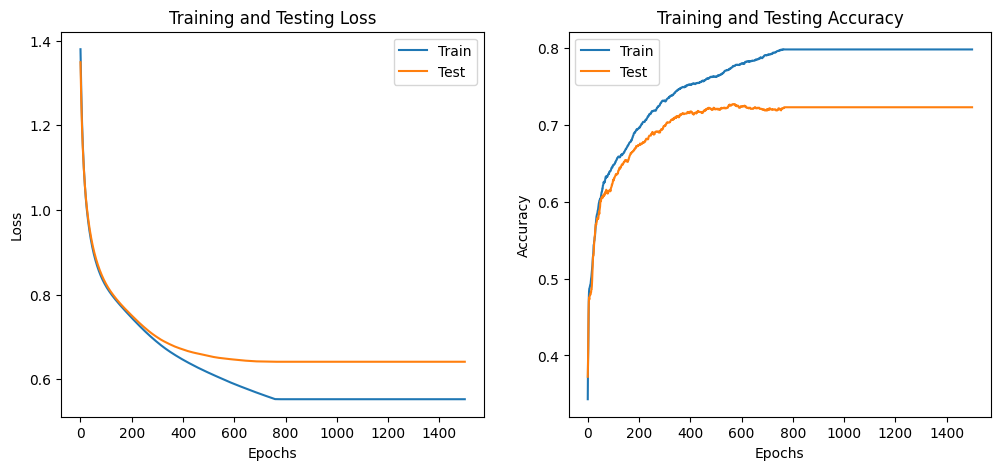

In [329]:
model1 = MLP1(input_size, hidden_size1, output_size)
optimizador = optimizer(model1)
MLP = modelo_MLP (model1, optimizador, datos)
Res1 = resultados_MLP ("MLP1", MLP, 1, y_test)
grafica_MLP (MLP)

#### 2 capas ocultas

In [330]:
# Neuronas en capa
hidden_size1 = 128   # Capa 1
hidden_size2 = 8   # Capa 2

set_seed(seed)

Entrenamiento completado
Parámetros totales modelo con 2 capas:  2092

Tiempo de entrenamiento: 9.265s
  - Accuracy de entrenamiento: 0.787

RESULTADOS DEL MODELO - MLP2

Matriz de confusión:
 [[367  69   2   0]
 [ 98 208  39   5]
 [ 22  73 210  30]
 [  3  18  40 280]]

Informe de clasificación:

Accuracy total: 0.735

   Clase Precision Recall F1 Score
       A     0.749  0.838    0.791
       B     0.565  0.594    0.579
       C     0.722  0.627    0.671
       D     0.889  0.821    0.854
                                  
Accuracy     0.731   0.72    0.724


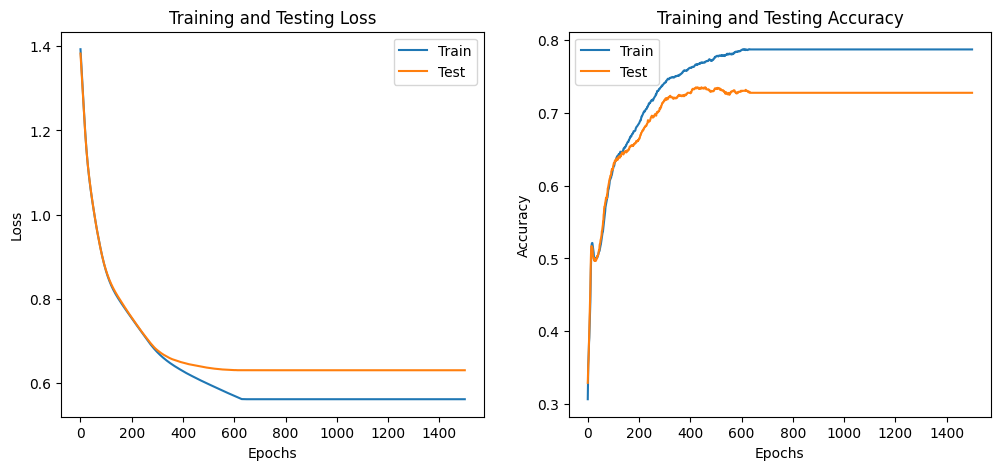

In [331]:
model2 = MLP2(input_size, hidden_size1, hidden_size2, output_size)
optimizador = optimizer(model2)
MLP = modelo_MLP (model2, optimizador, datos)
Res2 = resultados_MLP ("MLP2", MLP, 2, y_test)
grafica_MLP (MLP)

#### 3 capas ocultas

In [332]:
# Neuronas en capa
hidden_size1 = 64   # Capa 1
hidden_size2 = 64   # Capa 2
hidden_size3 = 128   # Capa 3

set_seed(seed)

Entrenamiento completado
Parámetros totales modelo con 3 capas:  13508

Tiempo de entrenamiento: 13.382s
  - Accuracy de entrenamiento: 0.808

RESULTADOS DEL MODELO - MLP3

Matriz de confusión:
 [[382  55   1   0]
 [ 97 218  29   6]
 [ 22  71 219  23]
 [  6  17  33 285]]

Informe de clasificación:

Accuracy total: 0.755

   Clase Precision Recall F1 Score
       A     0.753  0.872    0.808
       B     0.604  0.623    0.613
       C     0.777  0.654     0.71
       D     0.908  0.836    0.871
                                  
Accuracy      0.76  0.746     0.75


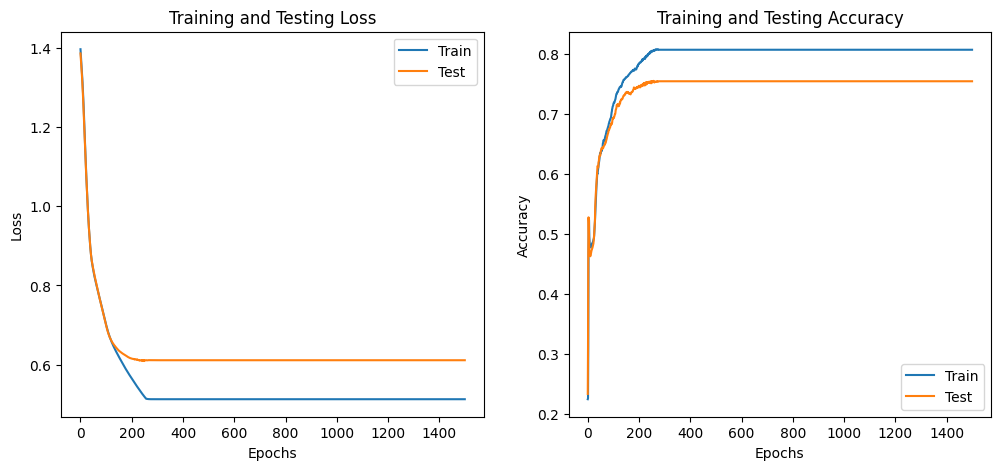

In [333]:
model3 = MLP3(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
optimizador = optimizer(model3)
MLP = modelo_MLP (model3, optimizador, datos)
Res3 = resultados_MLP ("MLP3", MLP, 3, y_test)
grafica_MLP (MLP)

#### 4 capas ocultas

In [334]:
# Neuronas en capa
hidden_size1 = 256   # Capa 1
hidden_size2 = 128   # Capa 2
hidden_size3 = 64   # Capa 3
hidden_size4 = 32   # Capa 4

set_seed(seed)

Entrenamiento completado
Parámetros totales modelo con 4 capas:  45412

Tiempo de entrenamiento: 23.782s
  - Accuracy de entrenamiento: 0.809

RESULTADOS DEL MODELO - MLP4

Matriz de confusión:
 [[367  68   2   1]
 [ 94 216  33   7]
 [ 22  70 227  16]
 [  6  17  39 279]]

Informe de clasificación:

Accuracy total: 0.751

   Clase Precision Recall F1 Score
       A     0.751  0.838    0.792
       B     0.582  0.617    0.599
       C     0.754  0.678    0.714
       D     0.921  0.818    0.866
                                  
Accuracy     0.752  0.738    0.743


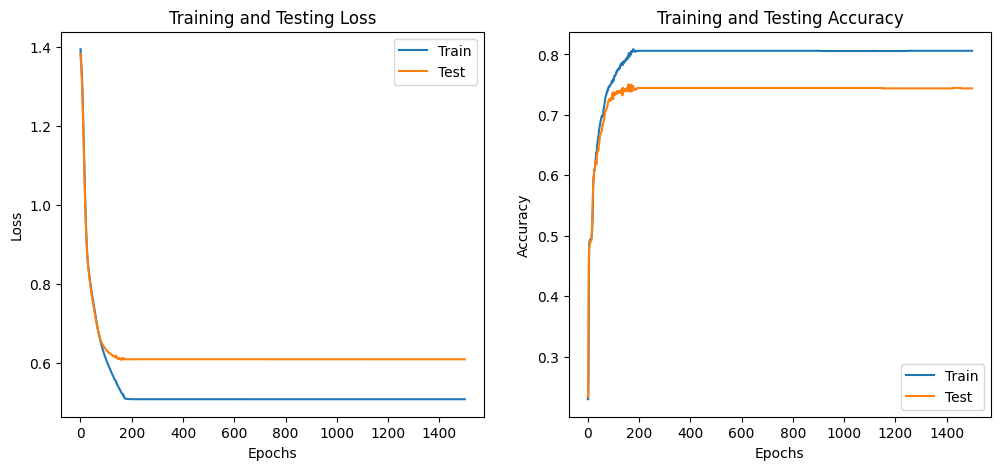

In [335]:
model4 = MLP4(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)
optimizador = optimizer(model4)
MLP = modelo_MLP (model4, optimizador, datos)
Res4 = resultados_MLP ("MLP4", MLP, 4, y_test)
grafica_MLP (MLP)

### Resultados

In [336]:
# FUNCIÓN PARA FORMAR TABLA DE RESULTADOS - NECESITA FUNCIÓN "diccionario()"
lista_de_diccionario = []

lista_de_diccionario.append(diccionario('Capas ocultas - 1',Res1))
lista_de_diccionario.append(diccionario('Capas ocultas - 2',Res2))
lista_de_diccionario.append(diccionario('Capas ocultas - 3',Res3))
lista_de_diccionario.append(diccionario('Capas ocultas - 4',Res4))

resultado_MLP = pd.DataFrame(lista_de_diccionario)

In [337]:
resultado_MLP.head()

MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0  Capas ocultas - 1       0.798      0.727      0.725   0.715     0.719
1  Capas ocultas - 2       0.787      0.735      0.731   0.720     0.724
2  Capas ocultas - 3       0.808      0.755      0.760   0.746     0.750
3  Capas ocultas - 4       0.809      0.751      0.752   0.738     0.743

# TIEMPO DE EJECUCIÓN

In [338]:
# Guardar el tiempo de finalización
final = time.time()

tiempo_total = final - Inicio

In [339]:
# Imprimir el tiempo de entrenamiento y la accuracy
print('Tiempo de ejecución: {:0.3f} minutos'.format(tiempo_total/60))

Tiempo de ejecución: 20.853 minutos


# RESULTADOS

In [340]:
def resultados_modelo(Titulo):
    print("\n==========================================")
    print('\033[1m'+'RESULTADOS DEL MODELO - {}'.format(Titulo)+'\033[0m')
    print("==========================================")

In [341]:
resultados_modelo('PCA')
resultadosM_PCA


RESULTADOS DEL MODELO - PCA


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.471      0.456      0.453   0.434   
1  Árbol de decisión - RandomS       0.471      0.456      0.453   0.434   
2        Random Forest - Bayes       0.549      0.468      0.428   0.448   
3      Random Forest - RandomS       0.589      0.467      0.429   0.445   
4                  KNN - Bayes       0.506      0.455      0.422   0.436   
5                KNN - RandomS       0.506      0.455      0.422   0.436   

   F1 SCORE  
0     0.424  
1     0.424  
2     0.418  
3     0.418  
4     0.419  
5     0.419

In [342]:
resultados_modelo('Normal')
resultadosM


RESULTADOS DEL MODELO - Normal


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.786      0.685      0.692   0.675   
1  Árbol de decisión - RandomS       0.772      0.691      0.698   0.679   
2        Random Forest - Bayes       0.852      0.741      0.743   0.734   
3      Random Forest - RandomS       0.861      0.746      0.748   0.738   
4                  KNN - Bayes       0.695      0.664      0.682   0.647   
5                KNN - RandomS       0.695      0.664      0.682   0.647   

   F1 SCORE  
0     0.678  
1     0.684  
2     0.736  
3     0.741  
4     0.654  
5     0.654

In [343]:
resultados_modelo('Full Data')
resultadosFD


RESULTADOS DEL MODELO - Full Data


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.797      0.674      0.678   0.673   
1  Árbol de decisión - RandomS       0.786      0.674      0.680   0.672   
2        Random Forest - Bayes       0.913      0.714      0.718   0.712   
3      Random Forest - RandomS       0.905      0.710      0.714   0.708   
4                  KNN - Bayes       0.704      0.642      0.660   0.642   
5                KNN - RandomS       0.704      0.642      0.660   0.642   

   F1 SCORE  
0     0.672  
1     0.671  
2     0.712  
3     0.708  
4     0.640  
5     0.640

In [344]:
resultados_modelo('Bagging')
resultadosBagging


RESULTADOS DEL MODELO - Bagging


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0  Random Forest RandomS       0.822      0.744      0.744   0.736     0.737

In [345]:
resultados_modelo('Over Sampling')
resultadosOS_M


RESULTADOS DEL MODELO - Over Sampling


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.858      0.708      0.715   0.705   
1  Árbol de decisión - RandomS       0.864      0.699      0.704   0.697   
2        Random Forest - Bayes       0.927      0.737      0.740   0.733   
3      Random Forest - RandomS       0.899      0.734      0.737   0.730   
4                  KNN - Bayes       1.000      0.602      0.607   0.595   
5                KNN - RandomS       1.000      0.602      0.607   0.595   

   F1 SCORE  
0     0.708  
1     0.700  
2     0.735  
3     0.733  
4     0.600  
5     0.600

In [346]:
resultados_modelo('Under Sampling')
resultadosUS_M


RESULTADOS DEL MODELO - Under Sampling


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.785      0.719      0.732   0.717   
1  Árbol de decisión - RandomS       0.791      0.714      0.729   0.712   
2        Random Forest - Bayes       0.925      0.730      0.735   0.727   
3      Random Forest - RandomS       0.902      0.734      0.738   0.731   
4                  KNN - Bayes       0.699      0.671      0.688   0.658   
5                KNN - RandomS       0.699      0.671      0.688   0.658   

   F1 SCORE  
0     0.722  
1     0.717  
2     0.730  
3     0.734  
4     0.666  
5     0.666

In [347]:
resultados_modelo('Class Weight')
resultadosW


RESULTADOS DEL MODELO - Class Weight


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0    RF - Bayes       0.878      0.736      0.741   0.732     0.736
1  RF - RandomS       0.871      0.740      0.744   0.735     0.739

In [348]:
resultados_modelo('Datos Sintéticos')
resultados_sinteticos


RESULTADOS DEL MODELO - Datos Sintéticos


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.882      0.694      0.694   0.695   
1  Árbol de decisión - RandomS       0.906      0.702      0.706   0.702   
2        Random Forest - Bayes       0.970      0.805      0.806   0.806   
3      Random Forest - RandomS       0.943      0.794      0.795   0.795   
4                  KNN - Bayes       1.000      0.774      0.780   0.774   
5                KNN - RandomS       1.000      0.774      0.780   0.774   

   F1 SCORE  
0     0.695  
1     0.703  
2     0.805  
3     0.794  
4     0.776  
5     0.776

In [349]:
resultados_modelo('Bi Clase')
resultados_biclase


RESULTADOS DEL MODELO - Bi Clase


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  \
0    Árbol de decisión - Bayes       0.918      0.848      0.904   0.876   
1  Árbol de decisión - RandomS       0.886      0.850      0.902   0.881   
2        Random Forest - Bayes       0.943      0.865      0.897   0.912   
3      Random Forest - RandomS       0.934      0.873      0.904   0.916   
4                  KNN - Bayes       0.864      0.863      0.927   0.874   
5                KNN - RandomS       0.862      0.861      0.925   0.871   

   F1 SCORE  
0     0.890  
1     0.891  
2     0.904  
3     0.910  
4     0.900  
5     0.897

In [350]:
resultados_modelo('Red Neuronal MLP')
resultado_MLP


RESULTADOS DEL MODELO - Red Neuronal MLP


MODELO  ACC. TRAIN  ACC. TEST  PRECISION  RECALL  F1 SCORE
0  Capas ocultas - 1       0.798      0.727      0.725   0.715     0.719
1  Capas ocultas - 2       0.787      0.735      0.731   0.720     0.724
2  Capas ocultas - 3       0.808      0.755      0.760   0.746     0.750
3  Capas ocultas - 4       0.809      0.751      0.752   0.738     0.743

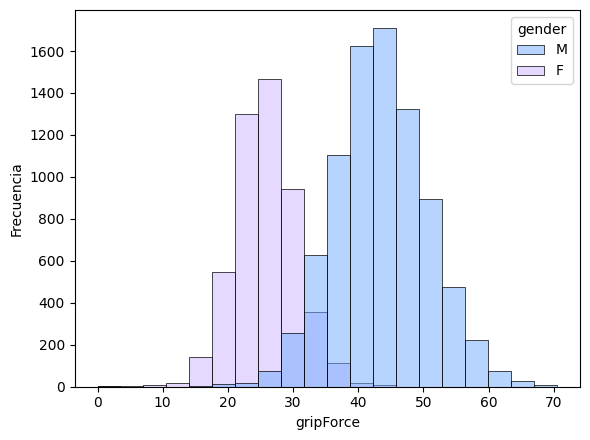

In [351]:
# Definir el tamaño de la figura
plt.figure(figsize=(6, 4.5))
sns.histplot(data=data, x="gripForce", hue="gender", kde=False, legend=True, palette=colores, bins=20, linewidth=0.5)
plt.xlabel("gripForce")
plt.ylabel("Frecuencia")

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Text(0, 0.5, 'broad jump_cm')

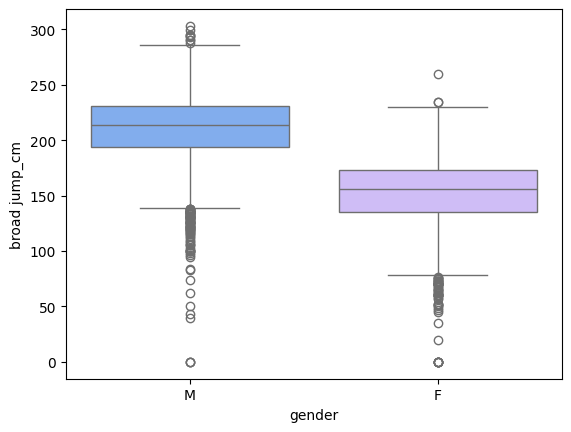

In [352]:
sns.boxplot(data=data, x="gender", y="broad jump_cm", hue="gender", palette=colores, dodge=False)
plt.ylabel("broad jump_cm")